# Section 1: Environment Setup and Imports
In this first section, we’ll:
1. Load environment variables containing API keys and Neo4j credentials.
1. Import the necessary Python libraries.
1. Create a connection to the Neo4j database.

**Key Points**:
- We’re using python-dotenv to load .env.
- We’ll verify that we can connect to Neo4j.
- No data manipulation happens here yet; just setup.


In [3]:
# Setup additional dependencies 
#!pip install rdflib
#!pip install py2neo networkx matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 7.2 MB/s eta 0:00:00


In [1]:
# Section 1: Environment Setup and Imports

import os
from dotenv import load_dotenv
from neo4j import GraphDatabase
from rdflib import Graph
import pandas as pd

# Load environment variables
load_dotenv("../.env")

# Retrieve environment variables
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Initialize Neo4j driver
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Test connection
with driver.session() as session:
    result = session.run("RETURN 1 AS test")
    print("Neo4j Connection Test Result:", result.single()["test"])


Neo4j Connection Test Result: 1


## **Step 2: Standardizing Data**

To ensure consistency, scalability, and alignment with best practices, we are standardizing all column names across the dataset to use **snake_case**. This approach simplifies ingestion, querying, and integration with tools like Neo4j, while also adhering to Python and database conventions.

Key changes include:
- Renaming columns in all tables to follow snake_case formatting.
- Introducing a consistent schema across all tables, including renaming ambiguous column names.
- Adding new columns like `survey_group_id` to ensure relationships between parent and child entities are clearly defined.

This standardization will prepare the data for seamless ingestion and future enrichment workflows.

In [138]:
import pandas as pd
import os

# File paths
input_dir = "../data/data_extraction/"
output_dir = "../data/standardized_data/"
os.makedirs(output_dir, exist_ok=True)

# Column maps
column_map = {
    "SurveyNode": {
        "Title": "title",
        "Description": "description",
        "Vintage": "release_year",
        "Dataset Name": "dataset_name",
        "Dataset Type": "dataset_type",
        "Geography List": "geography_list",
        "Variable List": "variable_list",
        "Group List": "group_list",
        "SortList": "sort_list",
        "Examples": "examples",
        "Developer Documentation": "developer_documentation",
        "API Base URL": "api_base_url",
        "Survey": "survey",
        "Subtype1": "subtype1",
        "Subtype2": "subtype2",
        "Subtype3": "subtype3",
        "Month": "month",
        "identifier": "identifier",
        "id_name": "id_name",
        "SurveyID": "survey_id",
        "Has Example": "has_example",
        "Has Sort": "has_sort",
        "Has Geography": "has_geography",
        "Has Group": "has_group",
        "SurveyGroupID": "survey_group_id"
    },
    "ExamplesNode": {
        "Geography Hierarchy": "geography_hierarchy",
        "Geography Level": "geography_level",
        "Example URL": "example_url",
        "Number": "number",
        "SurveyID": "survey_id"
    },
    "GeographyNode": {
        "ReferenceDate": "reference_date",
        "GeographyLevel": "geography_level",
        "GeographyHierarchy": "geography_hierarchy",
        "Limit": "limit",
        "SurveyID": "survey_id"
    },
    "SurveyGroupNode": {
        "SurveyID": "survey_id",
        "GroupName": "group_name",
        "GroupDescription": "group_description",
        "GroupLink": "group_link",
        "SurveyGroupID": "survey_group_id"
    },
    "SurveyVariablesNoGroupNode": {
        "SurveyID": "survey_id",
        "Variable Name": "variable_name",
        "Label": "label",
        "Concept": "concept",
        "Required": "required",
        "Attributes": "attributes",
        "Limit": "limit",
        "Predicate Type": "predicate_type",
        "Group": "group_name"
    }
}

# Function to fix survey_group_id in SurveyNode
def process_survey_node(df):
    # Ensure 'survey_group_id' has no nulls and default to "nogroup"
    df["survey_group_id"] = df["survey_group_id"].fillna("nogroup")
    expanded_rows = []

    for _, row in df.iterrows():
        group_ids = row["survey_group_id"].split(";")  # Split multiple group IDs
        group_ids = [group_id.strip() for group_id in group_ids]  # Strip whitespace

        # Generate new rows for each group_id
        for group_id in group_ids:
            new_row = row.copy()
            if group_id == "nogroup":
                new_row["survey_group_id"] = f"{row['survey_id']}_nogroup"
                new_row["has_group"] = "No Group"  # Ensure 'has_group' is set
            else:
                new_row["survey_group_id"] = group_id
            expanded_rows.append(new_row)

        # Ensure a "nogroup" row exists
        if "nogroup" not in group_ids:
            nogroup_row = row.copy()
            nogroup_row["survey_group_id"] = f"{row['survey_id']}_nogroup"
            nogroup_row["has_group"] = "No Group"  # Ensure 'has_group' is set
            expanded_rows.append(nogroup_row)

    return pd.DataFrame(expanded_rows)


# Process files
for table, col_map in column_map.items():
    input_file = os.path.join(input_dir, f"{table}.csv")
    output_file = os.path.join(output_dir, f"{table}.csv")
    
    if not os.path.exists(input_file):
        print(f"File not found: {input_file}, skipping...")
        continue
    
    try:
        # Load the file, force all columns to string
        df = pd.read_csv(input_file, dtype=str, low_memory=False)
        
        # Rename columns
        df.rename(columns=col_map, inplace=True)
        
        # Ensure required columns are present
        if "survey_id" not in df.columns:
            print(f"Critical column 'survey_id' missing in {table}. Skipping...")
            continue
        
        # Convert critical columns to strings
        df["survey_id"] = df["survey_id"].astype(str)
        
        # Handle special cases
        if table == "SurveyNode":
            df = process_survey_node(df)
        elif table == "ExamplesNode":
            df["survey_example_id"] = df["survey_id"] + "_" + df.index.astype(str)
        elif table == "GeographyNode":
            df["survey_geography_id"] = df["survey_id"] + "_" + df["geography_hierarchy"]
        elif table == "SurveyGroupNode":
            pass  # Already standardized
        elif table == "SurveyVariablesNoGroupNode":
            # Ensure group_name exists and is filled with 'nogroup'
            df["group_name"] = df["group_name"].fillna("nogroup")
            
            # Create survey_group_id
            df["survey_group_id"] = df["survey_id"] + "_nogroup"
            
            # Create survey_group_variable_id
            df["survey_group_variable_id"] = df["survey_group_id"] + "_" + df["variable_name"]
        
        # Save the updated file
        df.to_csv(output_file, index=False)
        print(f"Processed and saved: {output_file}")
    
    except Exception as e:
        print(f"Error processing {table}: {e}")


Processed and saved: ../data/standardized_data/SurveyNode.csv
Processed and saved: ../data/standardized_data/ExamplesNode.csv
Processed and saved: ../data/standardized_data/GeographyNode.csv
Processed and saved: ../data/standardized_data/SurveyGroupNode.csv
Processed and saved: ../data/standardized_data/SurveyVariablesNoGroupNode.csv


In [22]:
import pandas as pd
import os
from tqdm.auto import tqdm
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_chunked_files(files):
    """Load chunked files using multithreading."""
    def load_file(file_path):
        try:
            return pd.read_csv(file_path)
        except Exception as e:
            logging.error(f"Error loading file {file_path}: {e}")
            return pd.DataFrame()

    results = []
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = {executor.submit(load_file, f): f for f in files}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading chunks"):
            results.append(future.result())

    return pd.concat(results, ignore_index=True)

def validate_survey_ids(data):
    """Ensure survey_id_x and survey_id_y are equal."""
    if "survey_id_x" in data.columns and "survey_id_y" in data.columns:
        mismatched_rows = data[data["survey_id_x"] != data["survey_id_y"]]
        if not mismatched_rows.empty:
            logging.error("Found mismatched survey IDs in the merged data:")
            logging.error(mismatched_rows)
            raise ValueError("Mismatch detected between survey_id_x and survey_id_y.")
        else:
            logging.info("Validation passed: survey_id_x and survey_id_y are equal.")
    else:
        logging.info("Validation skipped: No overlapping survey_id columns.")

def load_and_combine_data(base_path, output_file):
    """
    Load data from SurveyNode, SurveyGroupNode, and GroupNodesWithVariables,
    combine them into a unified mapping, and save to a single CSV file.
    """
    try:
        # File paths
        survey_node_path = os.path.join(base_path, "SurveyNode.csv")
        survey_group_node_path = os.path.join(base_path, "SurveyGroupNode.csv")
        group_nodes_chunks_path = os.path.join(base_path, "GroupNodesWithVariables/")

        # Load SurveyNode.csv
        logging.info("Loading SurveyNode data...")
        survey_node = pd.read_csv(survey_node_path)
        survey_node["release_year"] = survey_node["release_year"].fillna(0).astype(int)
        logging.info(f"SurveyNode loaded with {len(survey_node)} records.")

        # Load SurveyGroupNode.csv
        logging.info("Loading SurveyGroupNode data...")
        survey_group_node = pd.read_csv(survey_group_node_path)
        logging.info(f"SurveyGroupNode loaded with {len(survey_group_node)} records.")

        # Load chunks for GroupNodesWithVariables
        logging.info("Loading GroupNodesWithVariables chunks...")
        group_nodes_files = [
            os.path.join(group_nodes_chunks_path, f)
            for f in os.listdir(group_nodes_chunks_path) if f.endswith(".csv")
        ]
        group_nodes = load_chunked_files(group_nodes_files)
        logging.info(f"GroupNodesWithVariables loaded with {len(group_nodes)} records.")

        # Merge SurveyNode with SurveyGroupNode
        logging.info("Merging SurveyNode with SurveyGroupNode...")
        merged_data = pd.merge(
            survey_group_node,
            survey_node[["survey_id", "survey_group_id", "release_year"]],
            how="inner",
            on="survey_group_id",
            suffixes=("_x", "_y")
        )

        # Validate survey_id columns
        validate_survey_ids(merged_data)

        # Merge with GroupNodesWithVariables
        logging.info("Merging with GroupNodesWithVariables...")
        final_mapping = pd.merge(
            merged_data,
            group_nodes[["survey_group_variable_id", "survey_group_id"]],
            how="inner",
            on="survey_group_id"
        )

        # Drop unwanted columns and redundant survey_id column
        unwanted_columns = ["group_description", "group_link", "survey_id_y"]
        final_mapping = final_mapping.drop(columns=[col for col in unwanted_columns if col in final_mapping])

        # Rename survey_id_x to survey_id for clarity
        if "survey_id_x" in final_mapping.columns:
            final_mapping = final_mapping.rename(columns={"survey_id_x": "survey_id"})

        # Save the final mapping to a single CSV file
        logging.info("Saving unified mapping to CSV...")
        final_mapping.to_csv(output_file, index=False)
        logging.info(f"Unified survey mapping saved to {output_file}")

    except Exception as e:
        logging.error(f"Error during processing: {e}")
        raise

if __name__ == "__main__":
    # Paths
    base_path = "../data/standardized_data/"
    output_file = os.path.join(base_path, "UnifiedSurveyMapping.csv")

    # Execute the process
    load_and_combine_data(base_path, output_file)


2024-12-29 23:47:45,701 - INFO - Loading SurveyNode data...
/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_15218/753389021.py:53: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_node = pd.read_csv(survey_node_path)
2024-12-29 23:47:46,321 - INFO - SurveyNode loaded with 66521 records.
2024-12-29 23:47:46,321 - INFO - Loading SurveyGroupNode data...
2024-12-29 23:47:46,426 - INFO - SurveyGroupNode loaded with 64873 records.
2024-12-29 23:47:46,426 - INFO - Loading GroupNodesWithVariables chunks...


Loading chunks:   0%|          | 0/134 [00:00<?, ?it/s]

2024-12-29 23:48:23,103 - INFO - GroupNodesWithVariables loaded with 7696043 records.
2024-12-29 23:48:23,104 - INFO - Merging SurveyNode with SurveyGroupNode...
2024-12-29 23:48:23,136 - INFO - Validation passed: survey_id_x and survey_id_y are equal.
2024-12-29 23:48:23,137 - INFO - Merging with GroupNodesWithVariables...
2024-12-29 23:48:26,021 - INFO - Saving unified mapping to CSV...
2024-12-29 23:48:36,432 - INFO - Unified survey mapping saved to ../data/standardized_data/UnifiedSurveyMapping.csv


# Map of survey_id to survey_group_id to survey_group_variable_id
- this will be a good map and integredity check
- We will use it to check and ingest data like the year as needed for more efficient queries
  

## **Plan to Populate `year` in `SurveyVariableNode`**
Since we now have a validated mapping file, the best path forward is to use this file as the authoritative source to populate the `year` property in the `SurveyVariableNode` table in Neo4j. This approach avoids the complexities and inefficiencies of in-database joins and focuses on leveraging the validated local data.

1. **Read the Mapping File**: Load the validated mapping file.
2. **Prepare Data for Ingestion**: Extract `survey_group_variable_id` and `release_year` from the mapping file for efficient ingestion.
3. **Batch Ingestion**: Use Neo4j's `SET` operation to update the `year` property in `SurveyVariableNode` for each batch of records.
4. **Add a Progress Bar**: Monitor ingestion progress using `tqdm`.
5. **Validation**: After ingestion, validate that `year` is populated for all relevant nodes.

---
# NOTE: this is done after ingest into the dB


In [26]:
import os
import logging
import pandas as pd
from tqdm.auto import tqdm
from neo4j import GraphDatabase
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
    
    def close(self):
        if self.driver:
            self.driver.close()

    def update_year_property(self, batch):
        """
        Update `year` property in SurveyVariableNode using the mapping file.
        """
        query = """
        UNWIND $batch AS row
        MATCH (v:SurveyVariableNode {survey_group_variable_id: row.survey_group_variable_id})
        SET v.year = row.release_year
        RETURN COUNT(v) AS updated_count
        """
        with self.driver.session() as session:
            result = session.run(query, batch=batch)
            return result.single()["updated_count"]

def populate_year_with_multithreading(mapping_file, batch_size, conn, num_threads=4):
    """
    Populate `year` property in SurveyVariableNode using multithreaded batches.
    """
    # Load the validated mapping file
    logging.info(f"Loading mapping file: {mapping_file}")
    mapping = pd.read_csv(mapping_file)
    total_rows = len(mapping)
    logging.info(f"Loaded {total_rows} rows from the mapping file.")

    # Prepare data for ingestion
    data = mapping[["survey_group_variable_id", "release_year"]].to_dict(orient="records")

    def process_batch(batch):
        """Process a single batch of updates."""
        try:
            return conn.update_year_property(batch)
        except Exception as e:
            logging.error(f"Error processing batch: {e}")
            return 0

    # Batch process with multithreading
    total_updated = 0
    batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]
    
    # Outer progress bar for overall progress
    with tqdm(total=len(data), desc="Updating `year` property", unit="node") as pbar:
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = {executor.submit(process_batch, batch): batch for batch in batches}
            # Per-thread progress bar
            thread_pbar = tqdm(total=len(batches), desc="Threads Progress", position=1, unit="batch", leave=False)
            
            for i, future in enumerate(as_completed(futures), 1):
                updated_count = future.result()
                total_updated += updated_count
                pbar.update(len(futures[future]))  # Update the main progress bar
                thread_pbar.update(1)  # Update the thread progress bar

            thread_pbar.close()

    logging.info(f"Total nodes updated: {total_updated}")

def main():
    # Neo4j connection details
    uri = os.getenv("NEO4J_URI", "")
    user = os.getenv("NEO4J_USER", "")
    password = os.getenv("NEO4J_PASSWORD", "")

    # Mapping file and batch size
    mapping_file = "../data/standardized_data/UnifiedSurveyMapping.csv"
    batch_size = 500
    num_threads = 4

    # Establish connection
    conn = Neo4jConnection(uri, user, password)

    try:
        logging.info("Starting to populate `year` in SurveyVariableNode with multithreading...")
        populate_year_with_multithreading(mapping_file, batch_size, conn, num_threads)
        logging.info("Year population completed successfully.")
    except Exception as e:
        logging.error(f"Error during year population: {e}")
    finally:
        conn.close()

if __name__ == "__main__":
    main()


2024-12-29 23:59:27,199 - INFO - Starting to populate `year` in SurveyVariableNode with multithreading...
2024-12-29 23:59:27,200 - INFO - Loading mapping file: ../data/standardized_data/UnifiedSurveyMapping.csv
2024-12-29 23:59:32,335 - INFO - Loaded 7749113 rows from the mapping file.


Updating `year` property:   0%|          | 0/7749113 [00:00<?, ?node/s]

Threads Progress:   0%|          | 0/15499 [00:00<?, ?batch/s]

2024-12-30 00:00:22,665 - INFO - Total nodes updated: 7749113
2024-12-30 00:00:23,185 - INFO - Year population completed successfully.


# Nogroup nodes will have a year too
- being done as their own special group to avoid complexity with the group nodes

In [33]:
import pandas as pd
import logging
from tqdm.auto import tqdm
from neo4j import GraphDatabase

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
    
    def close(self):
        if self.driver:
            self.driver.close()

    def fetch_variable_nodes(self):
        """
        Fetch all SurveyVariableNode entries with missing year.
        """
        query = """
        MATCH (v:SurveyVariableNode)
        WHERE v.year IS NULL
        RETURN v.survey_id AS survey_id, elementId(v) AS node_id
        """
        with self.driver.session() as session:
            result = session.run(query)
            return pd.DataFrame([dict(record) for record in result])

    def update_year(self, updates):
        """
        Batch update `year` for SurveyVariableNode using survey_id.
        """
        query = """
        UNWIND $batch AS row
        MATCH (v:SurveyVariableNode) WHERE elementId(v) = row.node_id
        SET v.year = row.year
        RETURN COUNT(v) AS updated_count
        """
        with self.driver.session() as session:
            result = session.run(query, batch=updates)
            return result.single()["updated_count"]

def main():
    # File paths and Neo4j credentials
    uri = os.getenv("NEO4J_URI", "")
    user = os.getenv("NEO4J_USER", "")
    password = os.getenv("NEO4J_PASSWORD", "")
    survey_node_file = "../data/standardized_data/SurveyNode.csv"
    batch_size = 10000

    # Load SurveyNode mapping
    logging.info(f"Loading survey mapping from {survey_node_file}...")
    survey_mapping = pd.read_csv(survey_node_file, usecols=["survey_id", "release_year"])
    survey_mapping = survey_mapping.drop_duplicates()
    survey_mapping_dict = survey_mapping.set_index("survey_id")["release_year"].to_dict()

    # Initialize Neo4j connection
    conn = Neo4jConnection(uri, user, password)

    try:
        logging.info("Fetching SurveyVariableNode entries with missing `year`...")
        variable_nodes = conn.fetch_variable_nodes()
        if variable_nodes.empty:
            logging.info("No SurveyVariableNode entries with missing `year` found.")
            return

        logging.info(f"Found {len(variable_nodes)} SurveyVariableNode entries with missing `year`.")

        # Map survey_id to release_year
        variable_nodes["year"] = variable_nodes["survey_id"].map(survey_mapping_dict)
        unmatched_nodes = variable_nodes[variable_nodes["year"].isna()]
        if not unmatched_nodes.empty:
            logging.warning(f"Unmatched survey_ids: {unmatched_nodes['survey_id'].unique()}")
            logging.warning(f"Total unmatched nodes: {len(unmatched_nodes)}")
            variable_nodes = variable_nodes.dropna(subset=["year"])

        # Batch update
        logging.info(f"Starting batch update for {len(variable_nodes)} nodes...")
        with tqdm(total=len(variable_nodes), desc="Updating `year`", unit="node") as pbar:
            for i in range(0, len(variable_nodes), batch_size):
                batch = variable_nodes.iloc[i:i + batch_size].to_dict("records")
                updated_count = conn.update_year(batch)
                pbar.update(len(batch))
                logging.info(f"Batch updated {updated_count} nodes.")

        logging.info("Year population completed successfully.")
    
    except Exception as e:
        logging.error(f"Error during processing: {e}")
    
    finally:
        conn.close()

if __name__ == "__main__":
    main()


2024-12-30 00:15:28,152 - INFO - Loading survey mapping from ../data/standardized_data/SurveyNode.csv...
2024-12-30 00:15:28,521 - INFO - Fetching SurveyVariableNode entries with missing `year`...
2024-12-30 00:15:29,443 - INFO - No SurveyVariableNode entries with missing `year` found.


# Cleaning Up Missing or Invalid Years in `SurveyNode`

## Overview
We used the Neo4j console to identify and clean up missing or invalid `year` values in the `SurveyNode` table. This process involved querying nodes with missing `year` values, identifying patterns in the `survey_id`, and applying targeted updates to populate the correct `year`.

## Steps Taken
1. **Identified Nodes with Missing or Invalid Years**:
   - Queried `SurveyNode` to find records where `year` was either missing, invalid (e.g., `<1000`), or greater than a reasonable threshold (`>2024`).

   ```cypher
   MATCH (s:SurveyNode)
   WHERE s.year IS NULL OR s.year < 1000 OR s.year > 2024
   RETURN s.survey_id, s.year
   LIMIT 20;
   ```

2. **Analyzed `survey_id` Patterns**:
   - Examined `survey_id` values for patterns that could reveal the correct year.
   - Identified consistent patterns, such as `CPSBASICyyyyMM` where the year was embedded in the 5th–8th characters of `survey_id`.

3. **Applied Pattern-Based Updates**:
   - Used the `substring()` function to extract the year from `survey_id` for specific patterns like `CPSBASIC`, `CPSVETS`, and others.

   Example for `CPSBASIC`:

   ```cypher
   MATCH (s:SurveyNode)
   WHERE s.survey_id =~ "CPSBASIC\\d{6}"
     AND (s.year IS NULL OR s.year < 1000 OR s.year > 2024)
   WITH s, toInteger(substring(s.survey_id, 8, 4)) AS extracted_year
   SET s.year = CASE 
       WHEN extracted_year >= 1980 AND extracted_year <= 2024 THEN extracted_year
       ELSE 9999
   END
   RETURN s.survey_id, s.year
   LIMIT 10;
   ```

4. **Manually Reviewed Outliers**:
   - For nodes that did not fit known patterns, manually assigned the correct year where possible.
   - Used a default value of `9999` for any node where the year could not be determined.

5. **Validated the Data**:
   - Queried the database to ensure there were no remaining missing or invalid `year` values:

   ```cypher
   MATCH (s:SurveyNode)
   WHERE s.year IS NULL OR s.year < 1980 OR s.year > 2024
   RETURN COUNT(*) AS invalid_count;
   ```

6. **Final Results**:
   - After completing the cleanup process, all `SurveyNode` entries had valid `year` values, either correctly derived from `survey_id` or set to `9999` as a fallback.

## Key Considerations
- Ensured that updates were applied only to affected nodes by validating `survey_id` patterns before running updates.
- Used the Neo4j console for iterative testing and validation, refining the update queries until no invalid years remained.
```

# Linking by Year
## Aggregated Year Relationship Strategy in Neo4j

## Overview

To optimize memory usage and enhance query performance within our Neo4j database, we implemented an **Aggregated Year Relationship Strategy**. This approach centralizes the association of nodes based on the `year` attribute, significantly reducing the number of relationships and preventing memory overload.

## Steps Undertaken

1. **Cleanup of Old Relationships**:
   - Removed redundant and memory-intensive relationships: `SHARES_YEAR`, `BELONGS_TO_YEAR`, `PART_OF_YEAR`, and `ASSOCIATED_WITH_YEAR`.

2. **Index Creation**:
   - Established indexes on the `year` property for the following node labels to accelerate query performance:
     - `SurveyGroupNode`
     - `SurveyNode`
     - `SurveyVariableNode`
     - `YearNode`

3. **Creation of Aggregated `YearNode` Entities**:
   - For each distinct `year` present in the dataset, a single `YearNode` was created to act as an aggregator.

4. **Linking Nodes to `YearNode`**:
   - Established `BELONGS_TO_YEAR` relationships from `SurveyGroupNode`, `SurveyNode`, and `SurveyVariableNode` to their corresponding `YearNode`.

5. **Validation**:
   - Conducted thorough validation to ensure all nodes are correctly linked and that only valid years (1980-2024) are represented.

## Benefits

- **Memory Efficiency**: Transitioned from potentially billions of relationships to a linear number, conserving memory.
- **Simplified Queries**: Facilitated straightforward retrieval of all surveys for a specific year via the centralized `YearNode`.
- **Enhanced Performance**: Reduced relationship overhead leads to faster traversal and query execution times.

## Considerations

- **Data Integrity**: Ensured that each `YearNode` is unique per year to maintain consistent relationships.
- **Scalability**: The strategy supports scalability by handling large datasets without compromising performance.


In [63]:
import os
import logging
from typing import List, Dict
from neo4j import GraphDatabase
from tqdm.auto import tqdm
from dotenv import load_dotenv
import time

# Load environment variables from .env file
load_dotenv()

class Neo4jYearLinker:
    def __init__(self):
        # Load credentials from environment variables
        uri = os.getenv("NEO4J_URI", "")
        user = os.getenv("NEO4J_USER", "")
        password = os.getenv("NEO4J_PASSWORD", "")

        # Validate that none of the credentials are empty
        if not uri or not user or not password:
            raise ValueError("Neo4j URI, user, and password must be set in the environment variables.")

        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.INFO)
        
        # Prevent adding multiple handlers if already present
        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)

    def close(self):
        self.driver.close()

    def run_query(self, query: str) -> int:
        """
        Executes a Cypher query and returns the number of relationships created.
        """
        with self.driver.session() as session:
            try:
                result = session.run(query)
                summary = result.consume()
                created = summary.counters.relationships_created
                self.logger.info(f"Executed query: {query.strip().splitlines()[0][:50]}... Relationships created: {created}")
                return created
            except Exception as e:
                self.logger.error(f"Error executing query: {str(e)}")
                raise

    def run_query_with_retry(self, query: str, retries: int = 3, delay: float = 5.0) -> int:
        """
        Executes a Cypher query with a retry mechanism.
        """
        for attempt in range(1, retries + 1):
            try:
                created = self.run_query(query)
                return created
            except Exception as e:
                self.logger.error(f"Attempt {attempt} failed for query: {e}")
                if attempt < retries:
                    self.logger.info(f"Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    self.logger.error(f"All {retries} attempts failed for query.")
                    raise

    def fetch_distinct_years(self) -> List[int]:
        """
        Fetches all distinct years present in the database.
        """
        with self.driver.session() as session:
            try:
                result = session.run("MATCH (n) WHERE n.year IS NOT NULL RETURN DISTINCT n.year AS year")
                years = [record["year"] for record in result]
                self.logger.info(f"Fetched {len(years)} distinct years.")
                return years
            except Exception as e:
                self.logger.error(f"Error fetching distinct years: {str(e)}")
                raise

    def link_nodes_to_year_nodes_in_batches(self, batch_size: int = 1):
        """
        Links nodes to their respective YearNode in batches.
        Each batch processes a specified number of years to manage memory usage.
        """
        years = self.fetch_distinct_years()
        total_years = len(years)
        self.logger.info(f"Starting to link nodes to YearNodes in batches of {batch_size} years each.")
        
        with tqdm(total=total_years, desc="Linking Years", unit="year") as pbar:
            for i in range(0, total_years, batch_size):
                batch_years = years[i:i + batch_size]
                # Prepare a list of queries for the current batch
                queries = []
                for year in batch_years:
                    # Escape the year value if it's not an integer
                    if isinstance(year, int):
                        year_value = year
                    else:
                        # Assuming year is a string
                        year_value = f"'{year}'"
                    
                    query = f"""
                    MATCH (n)
                    WHERE n.year = {year_value}
                    MATCH (y:YearNode {{year: {year_value}}})
                    MERGE (n)-[:BELONGS_TO_YEAR]->(y)
                    """
                    queries.append(query)
                
                # Execute all queries in the current batch
                for query in queries:
                    try:
                        self.run_query_with_retry(query)
                    except Exception as e:
                        self.logger.error(f"Failed to link nodes for year {year}: {e}")
                pbar.update(len(batch_years))
        
        self.logger.info("Completed linking nodes to YearNodes.")

    def create_year_index(self):
        # Define indexes for each relevant label
        index_queries = [
            "CREATE INDEX IF NOT EXISTS FOR (n:SurveyGroupNode) ON (n.year)",
            "CREATE INDEX IF NOT EXISTS FOR (n:SurveyNode) ON (n.year)",
            "CREATE INDEX IF NOT EXISTS FOR (n:SurveyVariableNode) ON (n.year)",
            "CREATE INDEX IF NOT EXISTS FOR (n:YearNode) ON (n.year)"
        ]
        
        self.logger.info("Starting to create year indexes...")
        for query in index_queries:
            try:
                self.run_query_with_retry(query)
            except Exception as e:
                self.logger.error(f"Failed to create index with query: {query}. Error: {e}")
        self.logger.info("Completed creating year indexes.")

    def create_year_nodes(self):
        query = """
        MATCH (n)
        WHERE n.year IS NOT NULL
        WITH DISTINCT n.year AS year
        MERGE (y:YearNode {year: year})
        """
        self.logger.info("Creating YearNode entities...")
        try:
            self.run_query_with_retry(query)
            self.logger.info("YearNode entities created successfully.")
        except Exception as e:
            self.logger.error(f"Failed to create YearNode entities: {e}")
            raise

    def create_year_relationships(self):
        queries = [
            # 1. Link SurveyGroupNode to SurveyNode
            """
            MATCH (g:SurveyGroupNode)
            MATCH (s:SurveyNode {year: g.year, survey_group_id: g.survey_group_id})
            MERGE (g)-[:BELONGS_TO_YEAR]->(s)
            """,
            
            # 2. Link SurveyVariableNode to SurveyGroupNode
            """
            MATCH (v:SurveyVariableNode)
            MATCH (g:SurveyGroupNode {year: v.year, survey_group_id: v.survey_group_id})
            MERGE (v)-[:PART_OF_YEAR]->(g)
            """,
            
            # 3. Link SurveyVariableNode to SurveyNode
            """
            MATCH (v:SurveyVariableNode)
            MATCH (s:SurveyNode {year: v.year, survey_id: v.survey_id})
            MERGE (v)-[:ASSOCIATED_WITH_YEAR]->(s)
            """
            # Removed SHARES_YEAR relationship
        ]
        
        self.logger.info("Starting to create year-based relationships...")
        for query in queries:
            try:
                self.run_query_with_retry(query)
            except Exception as e:
                self.logger.error(f"Failed to create year-based relationship with query: {query}. Error: {e}")
        self.logger.info("Completed creating year-based relationships.")

    def validate_relationships(self) -> dict:
        validation_queries = {
            "relationship_counts": """
                MATCH ()-[r]->()
                RETURN type(r) AS relationship_type, COUNT(r) AS count
                ORDER BY count DESC
            """,
            "year_node_links": """
                MATCH (n)-[:BELONGS_TO_YEAR]->(:YearNode)
                RETURN COUNT(n) AS linked_nodes
            """,
            "orphaned_nodes": """
                MATCH (n)
                WHERE n.year IS NOT NULL AND NOT (n)-[:BELONGS_TO_YEAR]->(:YearNode)
                RETURN COUNT(n) AS orphaned_nodes
            """,
            "incorrect_year_links": """
                MATCH (y:YearNode)<-[:BELONGS_TO_YEAR]-(n)
                WHERE n.year <> y.year
                RETURN COUNT(n) AS incorrect_links
            """
        }
        
        results = {}
        for name, query in validation_queries.items():
            with self.driver.session() as session:
                try:
                    result = session.run(query)
                    records = result.data()
                    results[name] = records
                    self.logger.info(f"Validation '{name}' executed successfully.")
                except Exception as e:
                    self.logger.error(f"Validation query '{name}' failed: {str(e)}")
                    results[name] = None
        return results

def main():
    # Initialize the linker
    linker = Neo4jYearLinker()
    
    try:
        # Step 1: Create indexes on the 'year' property for relevant node labels
        linker.logger.info("Step 1: Creating year indexes...")
        linker.create_year_index()
        
        # Step 2: Create YearNode entities (Aggregated Nodes)
        linker.logger.info("Step 2: Creating YearNode entities...")
        linker.create_year_nodes()
        
        # Step 3: Link all relevant nodes to their respective YearNode in batches
        linker.logger.info("Step 3: Linking nodes to YearNode in batches...")
        linker.link_nodes_to_year_nodes_in_batches(batch_size=1)  # Adjust batch_size as needed
        
        # Step 4: Create year-based relationships (excluding SHARES_YEAR)
        linker.logger.info("Step 4: Creating additional year-based relationships...")
        linker.create_year_relationships()
        
        # Step 5: Validate the relationships
        linker.logger.info("Step 5: Validating relationships...")
        validation_results = linker.validate_relationships()
        
        # Display validation results
        print("\nValidation Results:")
        for key, results in validation_results.items():
            print(f"\n{key}:")
            print(results)
            
    except Exception as e:
        linker.logger.error(f"An error occurred: {str(e)}")
        
    finally:
        linker.close()

if __name__ == "__main__":
    main()


NameError: name 'uri' is not defined

## Validation Cyphers for Year Linkage

### 1. Count of YearNodes
MATCH (y:YearNode)
RETURN COUNT(y) AS YearNode_Count;

### 2. Check for Years Outside 1980-2024
MATCH (y:YearNode)
WHERE y.year < 1980 OR y.year > 2024
RETURN y.year AS Invalid_Year;

### 3. Ensure All Relevant Nodes Are Linked to YearNode
MATCH (n)
WHERE n.year IS NOT NULL
AND NOT (n)-[:BELONGS_TO_YEAR]->(:YearNode)
RETURN COUNT(n) AS Unlinked_Nodes;

### 4. Verify Year Consistency in Relationships
MATCH (y:YearNode)<-[:BELONGS_TO_YEAR]-(n)
WHERE n.year <> y.year
RETURN n.year AS Node_Year, y.year AS YearNode_Year, COUNT(*) AS Mismatched_Links;


## Step 2.1 Standardizing GroupNodesWithVariables 
- due to shear size and number of these files, we're loading separately.
- There is more comlexity with handling this step
- we're adding special tricks like
    -  Parallel Processing with ThreadPoolExecutor to process multiple files simultaneously,and
    -  memory optimization by ensuring columns are explicitly treated as strings (dtype=str) to reduce ambiguity and memory issues.

In [127]:
import pandas as pd
import os
from tqdm import tqdm
import logging
from concurrent.futures import ThreadPoolExecutor

# Set up logging
logging.basicConfig(
    filename="standardization_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# File paths
input_dir = "../data/data_extraction/GroupNodesWithVariables"
output_dir = "../data/standardized_data/GroupNodesWithVariables"
os.makedirs(output_dir, exist_ok=True)

# Function to standardize column names, normalize data, and create unique IDs
def standardize_and_create_ids(input_file, output_file):
    try:
        df = pd.read_csv(input_file, dtype=str)
        
        # Standardize column names
        df.rename(columns={
            "SurveyID": "survey_id",
            "SurveyGroupID": "survey_group_id",
            "Group": "group_name",
            "Variable Name": "variable_name",
            "Variable Link": "variable_link",
            "Label": "label",
            "Concept": "concept",
            "Required": "required",
            "Attributes": "attributes",
            "Attribute Of": "attribute_of",
            "Attribute Type": "attribute_type",
            "Limit": "limit",
            "Predicate Type": "predicate_type"
        }, inplace=True)
        
        # Create survey_group_variable_id
        df["survey_group_variable_id"] = df["survey_group_id"] + "_" + df["variable_name"]
        
        # Normalize 'attributes' and 'attribute_of' columns
        df["attributes"] = df.get("attributes", "").str.strip('"').fillna("na").replace("na", "na")
        df["attribute_of"] = df.get("attribute_of", "").str.strip('"').fillna("na").replace("na", "na")
        
        # Fill remaining missing values with "na"
        df.fillna("na", inplace=True)
        
        # Save the standardized chunk
        df.to_csv(output_file, index=False)
        logging.info(f"Processed and saved: {output_file}")
    
    except Exception as e:
        logging.error(f"Error processing {input_file}: {e}")
        raise

# Process files in parallel
chunk_files = [f for f in os.listdir(input_dir) if f.startswith("Processed_GroupNode_chunk")]

with ThreadPoolExecutor() as executor:
    with tqdm(total=len(chunk_files), desc="Standardizing GroupNode chunks") as pbar:
        futures = {executor.submit(standardize_and_create_ids, 
                                   os.path.join(input_dir, chunk_file), 
                                   os.path.join(output_dir, chunk_file)): chunk_file 
                   for chunk_file in chunk_files}
        for future in futures:
            try:
                future.result()
            except Exception as e:
                logging.error(f"Error processing file {futures[future]}: {e}")
            finally:
                pbar.update(1)

print("All GroupNode chunks standardized. Check 'standardization_log.txt' for details.")


Standardizing GroupNode chunks: 100%|█████████| 134/134 [02:55<00:00,  1.31s/it]

All GroupNode chunks standardized. Check 'standardization_log.txt' for details.


# Step 3: Create relationships 
These steps ensure the graph has both structural and hierarchical relationships for all nodes. 

### **Step 3.1: Belong to Group (`BELONGS_TO_GROUP`)**
- **Purpose**: Link every `SurveyGroupVariableNode` (variable) to its parent `SurveyGroupNode` (group).
- **Logic**: 
  - Each `survey_group_variable_id` is associated with a `survey_group_id` using the `GroupNodesWithVariables` table.
- **Implementation**:
  - Loop through all chunks in the `GroupNodesWithVariables` directory.
  - For each chunk:
    - Match `survey_group_variable_id` to its `survey_group_id`.
    - Save the relationships as `BELONGS_TO_GROUP` in a CSV file.

---

### **Step 3.2: Parent/Child Relationships (`HAS_CHILD` and `HAS_PARENT`)**
- **Purpose**: Map hierarchical relationships between `SurveyGroupVariableNode`s (e.g., variables with attributes or parents).
- **Logic**:
  - A `survey_group_variable_id` has:
    - `HAS_CHILD` relationships to its attributes (`attributes` column).
    - `HAS_PARENT` relationships to its parent (`attribute_of` column).
- **Implementation**:
  - Process all chunks in the `GroupNodesWithVariables` directory.
  - For each chunk:
    - Use the `attributes` column to map children (`HAS_CHILD`).
    - Use the `attribute_of` column to map parents (`HAS_PARENT`).
    - Save these relationships in separate CSV files.

---

### **Summary**
1. **Belong to Group** (`BELONGS_TO_GROUP`): Links variables to their parent groups for structural organization.
2. **Parent/Child** (`HAS_CHILD`, `HAS_PARENT`): Defines hierarchical relationships within the `SurveyGroupVariableNode` layer.
___
## Step 3.1 


In [150]:
import pandas as pd
import os
from tqdm import tqdm

# File paths
input_dir = "../data/standardized_data/"
output_dir = "../data/relationships/"
os.makedirs(output_dir, exist_ok=True)

# Input files
survey_file = os.path.join(input_dir, "SurveyNode.csv")
group_file = os.path.join(input_dir, "SurveyGroupNode.csv")
nogroup_file = os.path.join(input_dir, "SurveyVariablesNoGroupNode.csv")
group_chunks_dir = os.path.join(input_dir, "GroupNodesWithVariables/")
geography_file = os.path.join(input_dir, "GeographyNode.csv")

# Output files
survey_to_group_file = os.path.join(output_dir, "survey_to_group_relationships.csv")
group_to_variable_file = os.path.join(output_dir, "group_to_variable_relationships.csv")
nogroup_relationships_file = os.path.join(output_dir, "nogroup_relationships.csv")
survey_to_geography_file = os.path.join(output_dir, "survey_to_geography_relationships.csv")


# Survey-to-Group Relationships
def create_survey_to_group_relationships(survey_file, output_file):
    surveys = pd.read_csv(survey_file, dtype=str)
    relationships = surveys[["survey_id", "survey_group_id"]].drop_duplicates()
    relationships["relationship"] = "HAS_GROUP"
    relationships.to_csv(output_file, index=False)
    print(f"Survey-to-group relationships saved to {output_file}")


# Group-to-Variable Relationships (from chunked files)
def create_group_to_variable_relationships(group_chunks_dir, output_file):
    chunk_files = [f for f in os.listdir(group_chunks_dir) if f.endswith(".csv")]
    all_relationships = []

    for chunk_file in tqdm(chunk_files, desc="Processing chunks"):
        chunk_path = os.path.join(group_chunks_dir, chunk_file)
        chunk = pd.read_csv(chunk_path, dtype=str)
        relationships = chunk[["survey_group_id", "survey_group_variable_id"]].drop_duplicates()
        relationships["relationship"] = "HAS_VARIABLE"
        all_relationships.append(relationships)

    pd.concat(all_relationships).to_csv(output_file, index=False)
    print(f"Group-to-variable relationships saved to {output_file}")


# No Group Relationships
def create_nogroup_relationships(nogroup_file, output_file):
    nogroup_variables = pd.read_csv(nogroup_file, dtype=str)
    relationships = nogroup_variables[["survey_group_id", "survey_group_variable_id"]].drop_duplicates()
    relationships["relationship"] = "BELONGS_TO_NOGROUP"
    relationships.to_csv(output_file, index=False)
    print(f"No group relationships saved to {output_file}")


# Survey-to-Geography Relationships
def create_survey_to_geography_relationships(geography_file, output_file):
    geography = pd.read_csv(geography_file, dtype=str)
    print("Creating survey-to-geography relationships...")
    relationships = geography[["survey_id", "geography_hierarchy"]].drop_duplicates()
    relationships.rename(columns={"survey_id": "source", "geography_hierarchy": "target"}, inplace=True)
    relationships["relationship"] = "HAS_GEOGRAPHY"
    relationships.to_csv(output_file, index=False)
    print(f"Survey-to-geography relationships saved to {output_file}")


# Create Relationships
print("Creating survey-to-group relationships...")
create_survey_to_group_relationships(survey_file, survey_to_group_file)

print("Creating group-to-variable relationships from chunks...")
create_group_to_variable_relationships(group_chunks_dir, group_to_variable_file)

print("Creating no group relationships...")
create_nogroup_relationships(nogroup_file, nogroup_relationships_file)

print("Creating survey-to-geography relationships...")
create_survey_to_geography_relationships(geography_file, survey_to_geography_file)

print("All relationships created successfully!")


Creating survey-to-group relationships...
Survey-to-group relationships saved to ../data/relationships/survey_to_group_relationships.csv
Creating group-to-variable relationships from chunks...


Processing chunks: 100%|██████████████████████| 134/134 [00:53<00:00,  2.51it/s]


Group-to-variable relationships saved to ../data/relationships/group_to_variable_relationships.csv
Creating no group relationships...
No group relationships saved to ../data/relationships/nogroup_relationships.csv
Creating survey-to-geography relationships...
Creating survey-to-geography relationships...
Survey-to-geography relationships saved to ../data/relationships/survey_to_geography_relationships.csv
All relationships created successfully!


___
## Step 3.2 Parent/Child Relationships (HAS_CHILD and HAS_PARENT)
Generate Full Relationship Table (Pre-Deduplication):
1. Identify source and target for all rows where attributes or attribute_of are filled.
1. Create a complete mapping of HAS_CHILD and HAS_PARENT relationships.

### NOTES: Optimized Code with Vectorization and Multithreading

### Key Optimizations
1. **Vectorized Operations**:
   - Uses `dict` mapping for fast lookups of `variable_name` to `survey_group_variable_id` relationships.
   - Replaces iterative `.loc` calls with dictionary lookups for attributes and parent mapping.

2. **Multithreading**:
   - Introduces `ThreadPoolExecutor` to process multiple chunk files in parallel.
   - Improves efficiency for large datasets by utilizing multiple CPU cores.

3. **Duplicate Resolution**:
   - Checks for duplicates in `variable_name` and `survey_group_variable_id` and resolves them efficiently using `.drop_duplicates`.

4. **Robustness**:
   - Catches errors in individual files and logs them without halting the entire process.
   - Ensures relationships are only saved when they exist.

### Expected Improvements
- **Speed**: The vectorized and multithreaded implementation should reduce processing time significantly.
- **Clarity**: Debugging warnings are preserved but streamlined to avoid excessive screen output.
- **Scalability**: Can handle large datasets efficiently.
 

In [158]:
import pandas as pd
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def process_chunk(df):
    """
    Process a DataFrame chunk to map parent-child relationships for annotations and estimates.
    """
    relationships = []

    # Ensure uniqueness in `variable_name` and `survey_group_variable_id`
    if df["variable_name"].duplicated().any():
        print("Warning: Duplicate variable_name entries detected. Resolving conflicts...")
        df = df.drop_duplicates(subset="variable_name", keep="first")

    if df["survey_group_variable_id"].duplicated().any():
        print("Warning: Duplicate survey_group_variable_id entries detected. Resolving conflicts...")
        df = df.drop_duplicates(subset="survey_group_variable_id", keep="first")

    # Create mappings for efficient lookups
    var_to_id = df.set_index("variable_name")["survey_group_variable_id"].to_dict()

    for variable_name, source_id in var_to_id.items():
        # Child Relationships
        if variable_name.endswith("E"):  # Estimate
            if variable_name + "A" in var_to_id:  # EA (Annotation of Estimate)
                relationships.append({
                    "source": source_id,
                    "target": var_to_id[variable_name + "A"],
                    "relationship": "HAS_CHILD"
                })
            if variable_name[:-1] + "M" in var_to_id:  # M (Margin of Error)
                relationships.append({
                    "source": source_id,
                    "target": var_to_id[variable_name[:-1] + "M"],
                    "relationship": "HAS_CHILD"
                })
        if variable_name.endswith("M"):  # Margin of Error
            if variable_name + "A" in var_to_id:  # MA (Annotation of Margin)
                relationships.append({
                    "source": source_id,
                    "target": var_to_id[variable_name + "A"],
                    "relationship": "HAS_CHILD"
                })

        # Parent Relationships
        if variable_name.endswith("A"):  # Annotation
            if variable_name[:-1] in var_to_id:  # Parent could be E or M
                relationships.append({
                    "source": source_id,
                    "target": var_to_id[variable_name[:-1]],
                    "relationship": "HAS_PARENT"
                })
        if variable_name.endswith("M"):  # Margin of Error
            if variable_name[:-1] + "E" in var_to_id:  # Parent is E
                relationships.append({
                    "source": source_id,
                    "target": var_to_id[variable_name[:-1] + "E"],
                    "relationship": "HAS_PARENT"
                })

    return pd.DataFrame(relationships)
 


def process_file(input_path, output_path):
    """
    Process a single file and save relationships.
    """
    try:
        df = pd.read_csv(input_path, dtype=str)
        relationships_df = process_chunk(df)
        if not relationships_df.empty:
            relationships_df.to_csv(output_path, index=False)
            return f"Processed {len(relationships_df)} relationships for {input_path}"
        else:
            return f"No relationships found in {input_path}"
    except Exception as e:
        return f"Error processing {input_path}: {e}"


# Multithreaded Processing
def map_relationships_multithreaded(input_dir, output_dir, max_workers=7):
    os.makedirs(output_dir, exist_ok=True)
    input_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for input_file in tqdm(input_files, desc="Mapping relationships"):
            input_path = os.path.join(input_dir, input_file)
            output_path = os.path.join(output_dir, f"Relationships_{input_file}")
            futures.append(executor.submit(process_file, input_path, output_path))

        # Collect results
        for future in tqdm(futures, desc="Processing results"):
            print(future.result())


# Paths
input_dir = "../data/standardized_data/GroupNodesWithVariables"
output_dir = "../data/relationships/GroupNodesWithVariables"

# Execute the optimized relationship mapping
map_relationships_multithreaded(input_dir, output_dir, max_workers=8)
print("Optimized relationship mapping completed.")


Mapping relationships:  30%|█████▋             | 40/134 [00:32<01:17,  1.21it/s]

Mapping relationships:  32%|██████             | 43/134 [00:35<01:30,  1.01it/s]

Mapping relationships:  46%|████████▋          | 61/134 [00:53<01:19,  1.09s/it]

Mapping relationships:  52%|█████████▉         | 70/134 [01:02<01:01,  1.05it/s]

Mapping relationships:  60%|███████████▍       | 81/134 [01:13<00:49,  1.06it/s]

Mapping relationships:  70%|█████████████▎     | 94/134 [01:25<00:32,  1.24it/s]

Mapping relationships:  75%|█████████████▍    | 100/134 [01:30<00:28,  1.20it/s]

Mapping relationships:  88%|███████████████▊  | 118/134 [01:49<00:14,  1.12it/s]

Mapping relationships:  96%|█████████████████▎| 129/134 [01:58<00:04,  1.12it/s]

Mapping relationships: 100%|██████████████████| 134/134 [02:04<00:00,  1.01it/s]

Mapping relationships: 100%|██████████████████| 134/134 [02:05<00:00,  1.07it/s]


Processing results:   0%|                               | 0/134 [00:00<?, ?it/s]

Processed 72224 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_070.csv
Processed 68908 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_064.csv
Processed 81494 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_058.csv
Processed 61804 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_104.csv
Processed 7817 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_110.csv
Processed 8471 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_111.csv
Processed 158346 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_105.csv
Processed 71580 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_059.csv


Processing results:   7%|█▌                     | 9/134 [00:09<02:10,  1.04s/it]

Processed 83128 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_065.csv
Processed 142168 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_071.csv


Processing results:   8%|█▊                    | 11/134 [00:20<04:22,  2.13s/it]

Processed 90210 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_098.csv
Processed 66046 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_067.csv


Processing results:  10%|██▏                   | 13/134 [00:47<14:20,  7.11s/it]

Processed 85978 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_073.csv
Processed 10973 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_113.csv


Processing results:  10%|██▎                   | 14/134 [00:48<11:08,  5.57s/it]

Processing results:  11%|██▍                   | 15/134 [01:13<20:53, 10.53s/it]

Processed 154074 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_107.csv


Processing results:  12%|██▋                   | 16/134 [01:15<16:00,  8.14s/it]

Processed 90420 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_106.csv
Processed 8577 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_112.csv


Processing results:  13%|██▊                   | 17/134 [01:15<11:45,  6.03s/it]

Processing results:  13%|██▉                   | 18/134 [01:32<17:29,  9.04s/it]

Processed 68842 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_072.csv
Processed 155536 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_066.csv


Processing results:  15%|███▎                  | 20/134 [01:58<18:56,  9.97s/it]

Processed 189568 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_099.csv
Processed 85440 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_089.csv


Processing results:  16%|███▌                  | 22/134 [01:59<09:56,  5.33s/it]

Processed 86516 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_062.csv


Processing results:  17%|███▊                  | 23/134 [02:28<22:29, 12.16s/it]

Processed 140444 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_076.csv


Processing results:  18%|███▉                  | 24/134 [03:08<37:36, 20.52s/it]

Processed 157632 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_116.csv


Processing results:  19%|████                  | 25/134 [03:11<27:41, 15.25s/it]

Processed 176864 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_102.csv
Processed 87606 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_103.csv


Processing results:  20%|████▍                 | 27/134 [03:15<15:22,  8.62s/it]

Processed 96662 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_117.csv
Processed 55688 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_077.csv


Processing results:  22%|████▊                 | 29/134 [03:16<08:05,  4.62s/it]

Processed 57517 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_063.csv


Processing results:  23%|█████                 | 31/134 [03:41<13:02,  7.60s/it]

Processed 148338 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_088.csv
Processed 148158 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_049.csv


Processing results:  24%|█████▎                | 32/134 [04:13<25:01, 14.72s/it]

Processed 72112 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_075.csv


Processing results:  25%|█████▍                | 33/134 [04:15<18:44, 11.14s/it]

Processed 74410 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_061.csv


Processing results:  25%|█████▌                | 34/134 [04:17<13:53,  8.33s/it]

Processed 107383 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_129.csv


Processing results:  26%|█████▋                | 35/134 [04:52<26:53, 16.30s/it]

Processed 96036 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_101.csv


Processing results:  27%|█████▉                | 36/134 [04:53<18:57, 11.61s/it]

Processed 93372 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_115.csv


Processing results:  28%|██████                | 37/134 [05:03<18:01, 11.15s/it]

Processed 101093 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_114.csv


Processing results:  28%|██████▏               | 38/134 [05:04<13:04,  8.17s/it]

Processed 71342 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_100.csv


Processing results:  29%|██████▍               | 39/134 [05:26<19:32, 12.34s/it]

Processed 90560 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_128.csv


Processing results:  30%|██████▌               | 40/134 [05:38<19:09, 12.23s/it]

Processed 139888 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_060.csv



Processing results:  31%|██████▉               | 42/134 [06:04<17:44, 11.57s/it]

Processed 154228 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_074.csv
Processed 70336 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_048.csv


Processing results:  33%|███████▏              | 44/134 [06:06<09:05,  6.06s/it]

Processed 69144 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_013.csv
Processed 605 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_007.csv


Processing results:  34%|███████▍              | 45/134 [06:06<06:31,  4.40s/it]

Processed 100 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_006.csv
Processed 71552 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_012.csv


Processing results:  36%|███████▉              | 48/134 [06:11<03:29,  2.44s/it]

Processed 4 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_004.csv
Processed 2053 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_010.csv
Processed 57896 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_038.csv


Processing results:  39%|████████▌             | 52/134 [06:14<01:38,  1.20s/it]

Processed 35802 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_039.csv
Processed 35334 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_011.csv
Processed 64 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_005.csv


Processing results:  40%|████████▋             | 53/134 [06:31<08:13,  6.09s/it]

Processed 60368 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_029.csv
Processed 61 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_001.csv


Processing results:  41%|█████████             | 55/134 [06:39<07:08,  5.42s/it]

Processed 72526 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_015.csv


Processing results:  43%|█████████▎            | 57/134 [06:41<03:54,  3.05s/it]

Processed 64720 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_014.csv
Processed 175 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_000.csv


Processing results:  43%|█████████▌            | 58/134 [07:03<11:04,  8.75s/it]

Processed 77126 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_028.csv
Processed 55728 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_016.csv


Processing results:  46%|██████████            | 61/134 [07:06<04:37,  3.81s/it]

Processed 190 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_002.csv
Processed 530 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_003.csv


Processing results:  46%|██████████▏           | 62/134 [07:07<03:32,  2.95s/it]

Processed 65042 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_017.csv
Processed 61292 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_032.csv


Processing results:  47%|██████████▎           | 63/134 [07:13<04:31,  3.82s/it]

Processing results:  48%|██████████▌           | 64/134 [07:30<08:57,  7.68s/it]

Processed 66252 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_026.csv


Processing results:  49%|██████████▋           | 65/134 [07:35<07:49,  6.80s/it]

Processed 70860 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_027.csv


Processing results:  49%|██████████▊           | 66/134 [07:36<05:52,  5.18s/it]

Processed 61318 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_033.csv


Processing results:  50%|███████████           | 67/134 [07:38<04:47,  4.30s/it]

Processed 71740 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_025.csv


Processing results:  51%|███████████▏          | 68/134 [07:57<09:29,  8.62s/it]

Processed 85704 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_031.csv
Processed 67340 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_019.csv


Processing results:  52%|███████████▍          | 70/134 [08:05<06:22,  5.97s/it]

Processed 65900 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_018.csv


Processing results:  54%|███████████▊          | 72/134 [08:08<03:39,  3.54s/it]

Processed 72994 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_030.csv
Processed 63966 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_024.csv


Processing results:  54%|███████████▉          | 73/134 [08:09<02:51,  2.82s/it]

Processed 469 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_008.csv


Processing results:  55%|████████████▏         | 74/134 [08:34<09:23,  9.38s/it]

Processed 70314 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_020.csv


Processing results:  57%|████████████▍         | 76/134 [08:36<04:56,  5.10s/it]

Processed 66284 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_034.csv
Processed 84300 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_035.csv


Processing results:  57%|████████████▋         | 77/134 [08:56<09:03,  9.54s/it]

Processed 64342 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_021.csv


Processing results:  58%|████████████▊         | 78/134 [08:56<06:24,  6.87s/it]

Processed 101 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_009.csv


Processing results:  59%|████████████▉         | 79/134 [09:13<09:08,  9.98s/it]

Processed 164104 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_037.csv


Processing results:  60%|█████████████▎        | 81/134 [09:15<04:45,  5.39s/it]

Processed 69292 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_023.csv
Processed 68334 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_022.csv


Processing results:  61%|█████████████▍        | 82/134 [09:16<03:34,  4.12s/it]

Processed 149528 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_036.csv
Processed 77628 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_092.csv


Processing results:  62%|█████████████▋        | 83/134 [09:30<05:50,  6.87s/it]

Processing results:  63%|█████████████▊        | 84/134 [09:40<06:30,  7.81s/it]

Processed 75956 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_086.csv
Processed 69644 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_051.csv


Processing results:  64%|██████████████        | 86/134 [09:41<03:18,  4.14s/it]

Processed 67 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_045.csv


Processing results:  65%|██████████████▎       | 87/134 [10:35<15:04, 19.24s/it]

Processed 164536 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_079.csv


Processing results:  66%|██████████████▍       | 88/134 [10:42<11:53, 15.51s/it]

Processed 166454 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_125.csv


Processing results:  67%|██████████████▊       | 90/134 [10:44<05:56,  8.10s/it]

Processed 5021 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_131.csv
Processed 62712 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_119.csv


Processing results:  69%|███████████████       | 92/134 [10:47<03:16,  4.67s/it]

Processed 84840 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_118.csv
Processed 20388 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_130.csv


Processing results:  69%|███████████████▎      | 93/134 [11:01<05:07,  7.50s/it]

Processed 87858 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_124.csv


Processing results:  70%|███████████████▍      | 94/134 [11:08<04:57,  7.45s/it]

Processed 81994 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_078.csv


Processing results:  72%|███████████████▊      | 96/134 [11:10<02:37,  4.15s/it]

Processed 52 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_044.csv
Processed 84418 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_050.csv


Processing results:  72%|███████████████▉      | 97/134 [11:11<02:03,  3.34s/it]

Processed 54144 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_087.csv


Processing results:  73%|████████████████      | 98/134 [11:33<05:20,  8.92s/it]

Processed 158362 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_093.csv


Processing results:  74%|████████████████▎     | 99/134 [12:25<12:44, 21.83s/it]

Processed 162876 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_085.csv


Processing results:  75%|███████████████▋     | 100/134 [12:34<10:06, 17.84s/it]

Processed 172490 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_091.csv


Processing results:  75%|███████████████▊     | 101/134 [12:35<07:10, 13.03s/it]

Processed 33601 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_046.csv


Processing results:  77%|████████████████▏    | 103/134 [12:37<03:32,  6.85s/it]

Processed 139716 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_052.csv
Processed 3496 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_132.csv


Processing results:  78%|████████████████▎    | 104/134 [12:38<02:29,  4.99s/it]

Processed 59150 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_126.csv


Processing results:  78%|████████████████▍    | 105/134 [12:47<03:00,  6.22s/it]

Processed 93948 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_127.csv


Processing results:  79%|████████████████▌    | 106/134 [12:48<02:06,  4.50s/it]

Processed 12 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_133.csv


Processing results:  81%|████████████████▉    | 108/134 [12:50<01:09,  2.69s/it]

Processed 77576 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_053.csv
Processed 85100 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_047.csv


Processing results:  81%|█████████████████    | 109/134 [13:03<02:24,  5.80s/it]

Processed 72244 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_090.csv


Processing results:  82%|█████████████████▏   | 110/134 [13:08<02:17,  5.72s/it]

Processed 84738 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_084.csv


Processing results:  83%|█████████████████▍   | 111/134 [13:33<04:21, 11.35s/it]

Processed 80766 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_080.csv


Processing results:  84%|█████████████████▌   | 112/134 [13:34<03:04,  8.37s/it]

Processed 38161 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_094.csv
Processed 47 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_043.csv


Processing results:  84%|█████████████████▋   | 113/134 [13:35<02:09,  6.19s/it]

Processing results:  85%|█████████████████▊   | 114/134 [14:10<04:55, 14.78s/it]

Processed 150862 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_057.csv


Processing results:  86%|██████████████████   | 115/134 [14:30<05:08, 16.22s/it]

Processed 170860 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_123.csv


Processing results:  87%|██████████████████▎  | 117/134 [14:32<02:23,  8.42s/it]

Processed 71332 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_122.csv
Processed 69854 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_056.csv


Processing results:  88%|██████████████████▍  | 118/134 [14:34<01:43,  6.48s/it]

Processed 189 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_042.csv


Processing results:  89%|██████████████████▋  | 119/134 [14:54<02:38, 10.54s/it]

Processed 97044 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_095.csv


Processing results:  90%|██████████████████▊  | 120/134 [14:55<01:47,  7.71s/it]

Processed 58300 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_081.csv


Processing results:  90%|██████████████████▉  | 121/134 [15:21<02:52, 13.28s/it]

Processed 171206 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_097.csv


Processing results:  91%|███████████████████  | 122/134 [15:22<01:52,  9.40s/it]

Processed 62550 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_083.csv
Processed 88230 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_068.csv


Processing results:  92%|███████████████████▎ | 123/134 [15:23<01:15,  6.88s/it]

Processing results:  93%|███████████████████▍ | 124/134 [15:46<01:58, 11.88s/it]

Processed 137996 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_054.csv


Processing results:  93%|███████████████████▌ | 125/134 [15:47<01:17,  8.62s/it]

Processed 91025 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_040.csv


Processing results:  94%|███████████████████▋ | 126/134 [15:50<00:54,  6.86s/it]

Processed 63248 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_108.csv


Processing results:  95%|███████████████████▉ | 127/134 [16:14<01:24, 12.04s/it]

Processed 130328 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_120.csv


Processing results:  96%|████████████████████▏| 129/134 [16:41<00:58, 11.60s/it]

Processed 99272 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_121.csv
Processed 42881 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_109.csv


Processing results:  97%|████████████████████▎| 130/134 [16:42<00:34,  8.53s/it]

Processed 213 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_041.csv


Processing results:  98%|████████████████████▌| 131/134 [17:12<00:44, 14.72s/it]

Processed 79054 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_055.csv


Processing results:  99%|████████████████████▊| 133/134 [17:14<00:07,  7.74s/it]

Processed 135142 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_069.csv
Processed 125752 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_082.csv


Processing results: 100%|█████████████████████| 134/134 [17:37<00:00, 12.33s/it]

Processed 71932 relationships for ../data/standardized_data/GroupNodesWithVariables/Processed_GroupNode_chunk_096.csv


Processing results: 100%|█████████████████████| 134/134 [17:38<00:00,  7.90s/it]


Optimized relationship mapping completed.


# Step 4: Initial Data and Relationship Ingestion

## 4.1: Data Ingest
- This script ingests all the data 
- Cleanup: a few unused columns removed and type corrections being applied 

In [169]:
import pandas as pd
from neo4j import GraphDatabase
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import os
import time
import logging
import sys

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('ingestion.log'),
        logging.StreamHandler(sys.stdout)
    ]
)

# Neo4j connection settings
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
BATCH_SIZE = 2000
MAX_WORKERS = 4

# Verify environment variables
if not all([NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD]):
    raise ValueError("Missing required environment variables")

# File paths with existence check
def verify_file_exists(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    return file_path

file_paths = {
    'survey': verify_file_exists("../data/standardized_data/SurveyNode.csv"),
    'examples': verify_file_exists("../data/standardized_data/ExamplesNode.csv"),
    'geography': verify_file_exists("../data/standardized_data/GeographyNode.csv"),
    'group': verify_file_exists("../data/standardized_data/SurveyGroupNode.csv"),
    'nogroup': verify_file_exists("../data/standardized_data/SurveyVariablesNoGroupNode.csv"),
    'group_chunks_dir': verify_file_exists("../data/standardized_data/GroupNodesWithVariables/")
}

# Test Neo4j connection
try:
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    with driver.session() as session:
        result = session.run("RETURN 1")
        result.single()
    logging.info("Successfully connected to Neo4j database")
except Exception as e:
    logging.error(f"Failed to connect to Neo4j: {e}")
    raise

def process_batches(df, batch_size):
    total_batches = (len(df) // batch_size) + (1 if len(df) % batch_size > 0 else 0)
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i + batch_size]
        logging.debug(f"Processing batch {i//batch_size + 1}/{total_batches}, size: {len(batch)}")
        yield batch

def handle_missing_values(df, required_columns, default="na"):
    before_count = len(df)
    # Create explicit copy at the start
    df = df.copy()
    
    for column in required_columns:
        if column not in df.columns:
            logging.warning(f"Required column '{column}' not found in DataFrame")
            df.loc[:, column] = default
        else:
            df.loc[:, column] = df[column].fillna(default).astype(str)
            
    after_count = len(df)
    if before_count != after_count:
        logging.warning(f"Row count changed during missing value handling: {before_count} -> {after_count}")
    return df

def ingest_data(file_name, query, node_label, cleanup_func=None, required_columns=None):
    try:
        start_time = time.time()
        logging.info(f"Starting ingestion of {node_label} from {file_name}")
        
        # Read CSV with error handling
        try:
            df = pd.read_csv(file_name, dtype=str)
            logging.info(f"Successfully read {len(df)} rows from {file_name}")
        except Exception as e:
            logging.error(f"Error reading CSV {file_name}: {e}")
            raise

        # Apply cleanup if provided
        if cleanup_func:
            try:
                df = cleanup_func(df)
                logging.info(f"Successfully cleaned data for {node_label}")
            except Exception as e:
                logging.error(f"Error during cleanup for {node_label}: {e}")
                raise

        # Handle missing values
        if required_columns:
            df = handle_missing_values(df, required_columns)

        # Batch processing with progress bar
        with driver.session() as session:
            successful_batches = 0
            failed_batches = 0
            
            for batch in tqdm(process_batches(df, BATCH_SIZE), 
                            total=(len(df) // BATCH_SIZE) + 1, 
                            desc=f"Ingesting {node_label}"):
                try:
                    session.run(query, batch=batch.to_dict("records"))
                    successful_batches += 1
                except Exception as e:
                    failed_batches += 1
                    logging.error(f"Error processing batch in {node_label}: {e}")
                    logging.error(f"Problematic batch sample: {batch.head(1).to_dict()}")
                    continue  # Continue with next batch instead of failing completely

        # Log results
        duration = time.time() - start_time
        logging.info(f"""
        Completed ingestion of {node_label}:
        - Total batches: {successful_batches + failed_batches}
        - Successful batches: {successful_batches}
        - Failed batches: {failed_batches}
        - Duration: {duration:.2f} seconds
        """)

    except Exception as e:
        logging.error(f"Fatal error during ingestion of {node_label}: {e}")
        raise

def ingest_chunks(directory, query, node_label, cleanup_func=None):
    chunk_files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    logging.info(f"Found {len(chunk_files)} chunk files in {directory}")
    
    if not chunk_files:
        logging.error(f"No CSV files found in directory: {directory}")
        return

    def process_chunk(file):
        file_path = os.path.join(directory, file)
        try:
            # Log start of individual chunk processing
            logging.info(f"Starting processing of chunk: {file}")
            
            # Read the chunk file
            df = pd.read_csv(file_path, dtype=str)
            logging.info(f"Successfully read chunk {file} with {len(df)} rows")
            
            # Apply cleanup if provided
            if cleanup_func:
                df = cleanup_func(df)
            
            # Process in smaller sub-batches for better progress tracking
            with driver.session() as session:
                for batch in process_batches(df, BATCH_SIZE):
                    try:
                        session.run(query, batch=batch.to_dict("records"))
                        logging.info(f"Processed batch of {len(batch)} rows from {file}")
                    except Exception as e:
                        logging.error(f"Error processing batch in {file}: {str(e)}")
                        raise
                        
            logging.info(f"Completed processing chunk: {file}")
            return True
            
        except Exception as e:
            logging.error(f"Failed to process chunk {file}: {str(e)}")
            return False

    # Process chunks with proper progress tracking
    successful_chunks = 0
    failed_chunks = 0
    
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Submit all tasks and get futures
        future_to_file = {executor.submit(process_chunk, file): file 
                         for file in chunk_files}
        
        # Monitor progress with detailed logging
        for future in tqdm(
            as_completed(future_to_file),
            total=len(chunk_files),
            desc=f"Processing {node_label} chunks"
        ):
            file = future_to_file[future]
            try:
                if future.result():
                    successful_chunks += 1
                else:
                    failed_chunks += 1
            except Exception as e:
                logging.error(f"Exception processing {file}: {str(e)}")
                failed_chunks += 1
    
    # Final summary
    logging.info(f"""
    Chunks processing summary for {node_label}:
    - Total chunks: {len(chunk_files)}
    - Successful: {successful_chunks}
    - Failed: {failed_chunks}
    """)

# Main Ingestion Process
def main():
    ingest_data(
        survey_file,
        """
        UNWIND $batch AS row
        MERGE (s:SurveyNode {survey_id: row.survey_id})
        SET s += row
        """,
        node_label="SurveyNode",
        cleanup_func=clean_survey_data,
        required_columns=["survey_id", "title", "release_year", "dataset_name", "has_geography"]
    )

    ingest_data(
        examples_file,
        """
        UNWIND $batch AS row
        MATCH (s:SurveyNode {survey_id: row.survey_id})
        MERGE (e:ExamplesNode {example_url: row.example_url})
        SET e += row
        MERGE (s)-[:HAS_EXAMPLE]->(e)
        """,
        node_label="ExamplesNode",
        cleanup_func=clean_examples_data,
        required_columns=["survey_id", "example_url", "geography_hierarchy", "geography_level"]
    )

    ingest_data(
        geography_file,
        """
        UNWIND $batch AS row
        MATCH (s:SurveyNode {survey_id: row.survey_id})
        MERGE (g:GeographyNode {geography_hierarchy: row.geography_hierarchy})
        SET g += row
        MERGE (s)-[:HAS_GEOGRAPHY]->(g)
        """,
        node_label="GeographyNode",
        cleanup_func=clean_geography_data,
        required_columns=["survey_id", "geography_hierarchy", "geography_level", "limit"]
    )

    ingest_data(
        group_file,
        """
        UNWIND $batch AS row
        MATCH (s:SurveyNode {survey_id: row.survey_id})
        MERGE (g:SurveyGroupNode {survey_group_id: row.survey_group_id})
        SET g += row
        MERGE (s)-[:HAS_GROUP]->(g)
        """,
        node_label="SurveyGroupNode",
        required_columns=["survey_id", "survey_group_id", "group_name"]
    )

    ingest_chunks(
        group_chunks_dir,
        """
        UNWIND $batch AS row
        MATCH (g:SurveyGroupNode {survey_group_id: row.survey_group_id})
        MERGE (v:SurveyVariableNode {survey_group_variable_id: row.survey_group_variable_id})
        SET v += row
        MERGE (g)-[:HAS_VARIABLE]->(v)
        """,
        node_label="GroupNodesWithVariables"
    )

    ingest_data(
        nogroup_file,
        """
        UNWIND $batch AS row
        MATCH (s:SurveyNode {survey_id: row.survey_id})
        MERGE (g:SurveyGroupNode {survey_group_id: row.survey_group_id})
        SET g += row
        MERGE (v:SurveyVariableNode {survey_group_variable_id: row.survey_group_variable_id})
        SET v += row
        MERGE (g)-[:HAS_VARIABLE]->(v)
        """,
        node_label="NoGroupVariables",
        cleanup_func=clean_nogroup_data,
        required_columns=["survey_id", "survey_group_id", "variable_name"]
    )

    print("Ingestion completed successfully!")

if __name__ == "__main__":
    try:
        logging.info("Starting ingestion process")
        main()
        logging.info("Ingestion process completed successfully")
    except Exception as e:
        logging.error(f"Fatal error in main process: {e}")
        raise

/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_7000/643421532.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1986' '1987' '1988' ... '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = df[column].fillna(default).astype(str)


Ingesting SurveyNode:   0%|          | 0/34 [00:00<?, ?it/s]

/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_7000/3877761744.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["example_url"] = df["example_url"].fillna("na")  # Replace any remaining NaN with 'na'


Ingesting ExamplesNode:   0%|          | 0/12 [00:00<?, ?it/s]

/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_7000/643421532.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '51' '255' ... '30' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = df[column].fillna(default).astype(str)


Ingesting GeographyNode:   0%|          | 0/6 [00:00<?, ?it/s]

Ingesting SurveyGroupNode:   0%|          | 0/33 [00:00<?, ?it/s]

Processing GroupNodesWithVariables chunks:   0%|          | 0/134 [00:00<?, ?it/s]

Ingesting NoGroupVariables:   0%|          | 0/270 [00:00<?, ?it/s]

Ingestion completed successfully!


## 4.2: Relationship Ingest
- adding our pre-defined relationships from step 3

In [65]:
import os
import logging
import pandas as pd
from tqdm.auto import tqdm
from neo4j import GraphDatabase

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the batch size globally
BATCH_SIZE = 2000  # Adjust based on your system's capability

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
    
    def close(self):
        if self.driver:
            self.driver.close()

# Function Definitions
def verify_file(file_path):
    """Ensure the file exists and is not empty."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    if os.path.getsize(file_path) == 0:
        raise ValueError(f"File is empty: {file_path}")
    return True

def test_neo4j_connection():
    """Test Neo4j connection and verify access."""
    try:
        with driver.session() as session:
            result = session.run("RETURN 1")
            result.single()
        logging.info("Successfully connected to Neo4j")
    except Exception as e:
        logging.error(f"Failed to connect to Neo4j: {e}")
        raise

def ingest_relationships(file_path, query, batch_size, label):
    """Ingest relationships into Neo4j with enhanced error handling."""
    verify_file(file_path)
    
    try:
        df = pd.read_csv(file_path, dtype=str)
        if df.empty:
            raise ValueError(f"No data to ingest in {file_path}")

        total_relationships = 0
        failed_batches = 0
        
        logging.info(f"Starting ingestion of {label} with {len(df)} rows from {file_path}")
        
        with driver.session() as session:
            for batch in tqdm(process_batches(df, batch_size), desc=f"Ingesting {label}"):
                try:
                    result = session.run(query, batch=batch.to_dict("records"))
                    summary = result.consume()
                    relationships_created = summary.counters.relationships_created
                    total_relationships += relationships_created
                    
                except Exception as e:
                    failed_batches += 1
                    logging.error(f"Error in batch processing for {label}: {e}")
                    continue  # Continue with the next batch
        
        logging.info(f"""
        Completed ingestion of {label}:
        - Total rows processed: {len(df)}
        - Relationships created: {total_relationships}
        - Failed batches: {failed_batches}
        """)
        
    except Exception as e:
        logging.error(f"Error during ingestion of {label} from {file_path}: {e}")
        raise

# Batch Processing Helper
def process_batches(df, batch_size):
    """Split data into batches."""
    for i in range(0, len(df), batch_size):
        yield df.iloc[i:i + batch_size]

# Main Function
def main():
    """Main execution function."""
    # Verify and test Neo4j connection
    test_neo4j_connection()

    # Define relationships
    relationships = [
        {
            "file": "../data/relationships/survey_to_geography_relationships.csv",
            "query": """
                UNWIND $batch AS row
                MATCH (s:SurveyNode {survey_id: row.source})
                MATCH (g:GeographyNode {geography_hierarchy: row.target})
                MERGE (s)-[:HAS_GEOGRAPHY]->(g)
            """,
            "label": "Survey-to-Geography Relationships"
        },
        {
            "file": "../data/relationships/survey_to_group_relationships.csv",
            "query": """
                UNWIND $batch AS row
                MATCH (s:SurveyNode {survey_id: row.source})
                MATCH (g:SurveyGroupNode {survey_group_id: row.target})
                MERGE (s)-[:HAS_GROUP]->(g)
            """,
            "label": "Survey-to-Group Relationships"
        },
        {
            "file": "../data/relationships/group_to_variable_relationships.csv",
            "query": """
                UNWIND $batch AS row
                MATCH (g:SurveyGroupNode {survey_group_id: row.source})
                MATCH (v:SurveyVariableNode {survey_group_variable_id: row.target})
                MERGE (g)-[:HAS_VARIABLE]->(v)
            """,
            "label": "Group-to-Variable Relationships"
        }
    ]

    # Process relationships
    for rel in relationships:
        ingest_relationships(rel["file"], rel["query"], BATCH_SIZE, rel["label"])

# Entry Point
if __name__ == "__main__":
    try:
        logging.info("Starting relationship ingestion process")
        main()
        logging.info("Relationship ingestion process completed successfully!")
    except Exception as e:
        logging.error(f"Fatal error: {e}")


2024-12-30 09:11:54,618 - INFO - Starting relationship ingestion process
2024-12-30 09:11:54,621 - INFO - Successfully connected to Neo4j
2024-12-30 09:11:54,634 - INFO - Starting ingestion of Survey-to-Geography Relationships with 9963 rows from ../data/relationships/survey_to_geography_relationships.csv


Ingesting Survey-to-Geography Relationships: 0it [00:00, ?it/s]

2024-12-30 09:12:01,255 - INFO - 
        Completed ingestion of Survey-to-Geography Relationships:
        - Total rows processed: 9963
        - Relationships created: 0
        - Failed batches: 0
        
2024-12-30 09:12:01,340 - INFO - Starting ingestion of Survey-to-Group Relationships with 66346 rows from ../data/relationships/survey_to_group_relationships.csv


Ingesting Survey-to-Group Relationships: 0it [00:00, ?it/s]

2024-12-30 09:12:22,333 - INFO - 
        Completed ingestion of Survey-to-Group Relationships:
        - Total rows processed: 66346
        - Relationships created: 0
        - Failed batches: 0
        
2024-12-30 09:12:26,839 - INFO - Starting ingestion of Group-to-Variable Relationships with 7695485 rows from ../data/relationships/group_to_variable_relationships.csv


Ingesting Group-to-Variable Relationships: 0it [00:00, ?it/s]

KeyboardInterrupt: 

# Fixing Parent-Child Relationships in the dB
- We had somehow created circular relationships with the parent-child
- we ran thise query in neo4j to check, and discovered this issue with:
    ```
    MATCH (child:SurveyVariableNode)-[:HAS_PARENT]->(parent:SurveyVariableNode)
    RETURN child.variable_name, parent.variable_name LIMIT 10
    ```

## Deeper Check

```
// Detect circular relationships
MATCH (child:SurveyVariableNode)-[:HAS_PARENT]->(parent:SurveyVariableNode)
WHERE child.variable_name = parent.variable_name
RETURN child.variable_name AS circular_relationship;

// Detect duplicate parent-child relationships
MATCH (child:SurveyVariableNode)-[:HAS_PARENT]->(parent:SurveyVariableNode)
WITH child, parent, COUNT(*) AS count
WHERE count > 1
RETURN child.variable_name AS child, parent.variable_name AS parent, count;

// Detect incorrect parent-child relationships
MATCH (child:SurveyVariableNode)-[:HAS_PARENT]->(parent:SurveyVariableNode)
WHERE NOT (
    (child.variable_name ENDS WITH "EA" AND parent.variable_name = LEFT(child.variable_name, SIZE(child.variable_name) - 2) + "E") OR
    (child.variable_name ENDS WITH "M" AND parent.variable_name = LEFT(child.variable_name, SIZE(child.variable_name) - 1) + "E") OR
    (child.variable_name ENDS WITH "MA" AND parent.variable_name = LEFT(child.variable_name, SIZE(child.variable_name) - 2) + "M")
)
RETURN child.variable_name AS child, parent.variable_name AS parent;

```

**NOTE**: When we ran that query, we got 5232393 records were detected

## Dropping all parent records 
- This is not good for very large dBs, but in theory this is how ot delete the easy way without the need for batching and multithreaded processing. 
    ```
    MATCH ()-[r:HAS_PARENT]->()
    DELETE r;
    ```

___
## Deleting old relationship


In [219]:
import os
from neo4j import GraphDatabase
from tqdm.auto import tqdm
import logging
from dotenv import load_dotenv
from time import sleep

# Load environment variables
load_dotenv()

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

class Neo4jBatchDeleter:
    def __init__(self, uri, user, password, batch_size=500, max_retries=3):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.batch_size = batch_size
        self.max_retries = max_retries

    def close(self):
        self.driver.close()

    def delete_relationships(self, relationship_type):
        """
        Delete relationships of a specific type in batches with retry logic.
        """
        with self.driver.session() as session:
            # Fetch the total count of relationships
            total_relationships = session.run(
                f"MATCH ()-[r:{relationship_type}]->() RETURN count(r) AS total"
            ).single()["total"]

            if total_relationships == 0:
                logging.info(f"No {relationship_type} relationships to delete.")
                return

            logging.info(f"Total {relationship_type} relationships to delete: {total_relationships}")
            progress_bar = tqdm(total=total_relationships, desc=f"Deleting {relationship_type}")

            while True:
                try:
                    deleted_count = self._delete_batch(session, relationship_type)
                    if deleted_count == 0:
                        break  # No more relationships to delete

                    progress_bar.update(deleted_count)
                except Exception as e:
                    logging.error(f"Error deleting {relationship_type} batch: {e}")
                    sleep(1)  # Pause before retrying
            progress_bar.close()

    def _delete_batch(self, session, relationship_type):
        """
        Delete a single batch of relationships with retries.
        """
        for attempt in range(self.max_retries):
            try:
                result = session.run(
                    f"""
                    MATCH ()-[r:{relationship_type}]->()
                    WITH r LIMIT $batch_size
                    DELETE r
                    RETURN count(r) AS deleted_count
                    """,
                    batch_size=self.batch_size
                )
                return result.single()["deleted_count"]
            except Exception as e:
                logging.warning(f"Retrying batch deletion for {relationship_type} (attempt {attempt + 1}/{self.max_retries}): {e}")
                sleep(1)  # Pause before retrying
        raise RuntimeError(f"Failed to delete batch for {relationship_type} after {self.max_retries} retries.")

if __name__ == "__main__":
    # Neo4j connection configuration from .env
    uri = os.getenv("NEO4J_URI")
    user = os.getenv("NEO4J_USER")
    password = os.getenv("NEO4J_PASSWORD")

    if not all([uri, user, password]):
        raise ValueError("Missing Neo4j credentials in .env file.")

    # Initialize the batch deleter
    deleter = Neo4jBatchDeleter(uri, user, password, batch_size=500, max_retries=3)

    try:
        logging.info("Starting deletion process for HAS_PARENT relationships...")
        deleter.delete_relationships("HAS_PARENT")
        logging.info("Starting deletion process for HAS_CHILD relationships...")
        deleter.delete_relationships("HAS_CHILD")
        logging.info("Deletion process completed successfully.")
    finally:
        deleter.close()


Deleting HAS_CHILD:   0%|          | 0/10267328 [00:00<?, ?it/s]

___
### Validating deletions
- Run this is neo4j
  ```
      MATCH ()-[r]->()
      RETURN type(r) AS relationship_type, COUNT(r) AS count
      ORDER BY count DESC;
  ```

___
## Rebuilding the Relationships 

In [221]:
import os
import pandas as pd
from tqdm.auto import tqdm
from neo4j import GraphDatabase
import logging

# Neo4j connection settings
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
BATCH_SIZE = 2000
MAX_RETRIES = 3

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('relationship_ingestion.log'),
        logging.StreamHandler()
    ]
)

def ingest_chunk(session, chunk, rel_type):
    """Ingest a single chunk of relationships into Neo4j."""
    query = f"""
    UNWIND $batch AS row
    MATCH (source:SurveyVariableNode {{survey_group_variable_id: row.source}})
    MATCH (target:SurveyVariableNode {{survey_group_variable_id: row.target}})
    MERGE (source)-[:{rel_type}]->(target)
    """
    retries = 0
    while retries < MAX_RETRIES:
        try:
            session.run(query, batch=chunk.to_dict("records"))
            break
        except Exception as e:
            retries += 1
            logging.error(f"Retry {retries}/{MAX_RETRIES} for {rel_type} batch: {e}")

def ingest_relationships(file_path):
    """Ingest relationships into Neo4j."""
    df = pd.read_csv(file_path, dtype=str)

    # Verify required columns
    required_columns = ["source", "target", "relationship"]
    if not all(col in df.columns for col in required_columns):
        logging.error(f"Missing required columns in {file_path}. Skipping...")
        return

    # Group by relationship type
    grouped = df.groupby("relationship")

    with driver.session() as session:
        for rel_type, group in grouped:
            for i in tqdm(range(0, len(group), BATCH_SIZE), desc=f"Ingesting {rel_type} relationships", leave=False):
                batch = group.iloc[i:i + BATCH_SIZE]
                ingest_chunk(session, batch, rel_type)

def main():
    parent_child_dir = "../data/relationships/GroupNodesWithVariables/"
    chunk_files = [os.path.join(parent_child_dir, f) for f in os.listdir(parent_child_dir) if f.endswith(".csv")]

    for file in tqdm(chunk_files, desc="Processing files", leave=True):
        try:
            ingest_relationships(file)
        except Exception as e:
            logging.error(f"Error processing {file}: {e}")

    logging.info("Parent-child relationships ingestion completed.")

if __name__ == "__main__":
    main()


Processing files:   0%|          | 0/134 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/23 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/29 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/31 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/23 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/6 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/53 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/40 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/23 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/23 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/5 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/48 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/48 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/39 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/39 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/25 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/24 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/28 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/21 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/21 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/16 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/5 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/5 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/5 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/5 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/54 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/41 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/25 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/28 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/48 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/36 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/38 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/38 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/27 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/27 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/25 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/25 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/24 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/24 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/34 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/23 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/23 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/35 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/35 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/39 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/39 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/36 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/36 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/40 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/40 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/45 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/45 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/25 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/25 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/38 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/38 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/14 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/14 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/15 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/15 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/2 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/15 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/15 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/9 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/9 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/9 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/10 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/14 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/14 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/16 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/16 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/20 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/20 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/16 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/16 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/16 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/16 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/16 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/16 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/42 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/42 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/38 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/38 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/17 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/9 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/9 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/35 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/35 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/41 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/41 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/44 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/44 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/15 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/15 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/24 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/24 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/20 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/20 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/42 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/42 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/20 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/20 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/19 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/42 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/42 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/2 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/2 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/16 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/16 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/5 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/6 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/14 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/14 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/40 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/40 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/21 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/21 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/30 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/39 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/31 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/58 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/22 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/47 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/30 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/25 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/25 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/31 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/9 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/50 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/7 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/20 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/20 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/46 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/38 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/38 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/21 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/21 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/10 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/10 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/43 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/43 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/25 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/25 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/20 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

Ingesting HAS_CHILD relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/18 [00:00<?, ?it/s]

Ingesting HAS_PARENT relationships:   0%|          | 0/1 [00:00<?, ?it/s]

## Adding variable to group relationships
### First create a 'group' node
- Orginally, the data tables did not have a group table, with unique group_id and group_name, and group link
- Now we are going to create a seperate node to reduce complexity when linking variables back to groups.
- this is because each survey_id+group_id combination represents a unique value and we were creating an excessive number of 'has group' relationships in the variables instead of linking them back to the shared 'group_name' in the surveygroupnode table

In [271]:
import os
import pandas as pd
from tqdm.auto import tqdm
from neo4j import GraphDatabase
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Neo4j connection settings
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
BATCH_SIZE = 500
MAX_RETRIES = 3
NUM_WORKERS = 5  # Number of workers for multithreading

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('group_node_normalization.log'),
        logging.StreamHandler()
    ]
)

def fetch_group_data():
    """Fetch distinct group_name, group_description, and group_link from SurveyGroupNode."""
    with driver.session() as session:
        result = session.run("""
        MATCH (g:SurveyGroupNode)
        WHERE g.group_name IS NOT NULL AND g.group_name <> 'nogroup'
        RETURN DISTINCT g.group_name AS group_name, g.group_description AS group_description, g.group_link AS group_link
        """)
        data = pd.DataFrame([{
            "group_name": record["group_name"],
            "group_description": record["group_description"],
            "group_link": record["group_link"]
        } for record in result])
    return data

def ingest_group_nodes(session, chunk):
    """Ingest a single batch of GroupNode entries into Neo4j."""
    query = """
    UNWIND $batch AS row
    MERGE (n:GroupNode {group_name: row.group_name})
    SET n.group_description = row.group_description,
        n.group_link = row.group_link
    """
    retries = 0
    while retries < MAX_RETRIES:
        try:
            session.run(query, batch=chunk.to_dict("records"))
            break
        except Exception as e:
            retries += 1
            logging.error(f"Retry {retries}/{MAX_RETRIES} for GroupNode batch: {e}")
            if retries == MAX_RETRIES:
                logging.error(f"Failed batch: {chunk}")
                raise

def add_nogroup_to_groupnode():
    """Add 'nogroup' to GroupNode with a default description."""
    query = """
    MERGE (n:GroupNode {group_name: 'nogroup'})
    SET n.group_description = 'Not part of any special table'
    """
    with driver.session() as session:
        session.run(query)
    logging.info("'nogroup' added to GroupNode.")

def process_batches(data, batch_size=BATCH_SIZE):
    """Process data in batches with multithreading and progress tracking."""
    batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]
    logging.info(f"Total batches to process: {len(batches)}")

    with tqdm(total=len(batches), desc="Creating GroupNodes", leave=True) as pbar:
        with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
            futures = [
                executor.submit(run_batch, batch)
                for batch in batches
            ]
            for future in as_completed(futures):
                pbar.update(1)
                try:
                    future.result()
                except Exception as e:
                    logging.error(f"Batch processing failed: {e}")

def run_batch(batch):
    """Run a single batch through a Neo4j session."""
    with driver.session() as session:
        ingest_group_nodes(session, batch)

def main():
    logging.info("Starting GroupNode normalization.")
    try:
        # Step 1: Fetch and process regular GroupNodes
        data = fetch_group_data()
        if data.empty:
            logging.warning("No group data found. Exiting.")
            return

        logging.info(f"Fetched {len(data)} distinct groups.")
        logging.info(f"Sample data: {data.head()}")

        process_batches(data, batch_size=BATCH_SIZE)

        # Step 2: Add and handle 'nogroup' GroupNode
        add_nogroup_to_groupnode()

        logging.info("GroupNode normalization completed.")
    except Exception as e:
        logging.error(f"Error during normalization: {e}")
    finally:
        driver.close()

if __name__ == "__main__":
    main()


Creating GroupNodes:   0%|          | 0/130 [00:00<?, ?it/s]

## **Link GroupNodes in Graph:**
- **Goal:** Link nodes in the knowledge graph.
- **Steps:**
  1. **Link `SurveyGroupNode` to `GroupNode`:**  
     Match `group_name` and establish a `BELONGS_TO` relationship.
  2. **Link `SurveyVariableNode` to `SurveyGroupNode`:**  
     Use `survey_group_variable_id` and `survey_group_id` to create relationships.
  3. **Batch Processing:**  
     Process the relationships in batches of 500 for efficiency and progress tracking.


In [272]:
import os
import pandas as pd
from tqdm.auto import tqdm
from neo4j import GraphDatabase
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Neo4j connection settings
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
BATCH_SIZE = 500
MAX_RETRIES = 3
NUM_WORKERS = 5

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('link_nodes.log'),
        logging.StreamHandler()
    ]
)

def fetch_data_for_variable_links():
    """Fetch survey_group_variable_id and survey_group_id pairs."""
    with driver.session() as session:
        result = session.run("""
        MATCH (v:SurveyVariableNode), (g:SurveyGroupNode)
        WHERE v.survey_group_variable_id STARTS WITH g.survey_group_id
        RETURN DISTINCT v.survey_group_variable_id AS survey_group_variable_id,
                        g.survey_group_id AS survey_group_id
        """)
        data = pd.DataFrame([{
            "survey_group_variable_id": record["survey_group_variable_id"],
            "survey_group_id": record["survey_group_id"]
        } for record in result])
    logging.info(f"Fetched {len(data)} variable-to-group pairs.")
    logging.info(f"Sample data: {data.head()}")
    return data

def ingest_links(session, chunk, query):
    """Ingest a single batch of relationships into Neo4j."""
    retries = 0
    while retries < MAX_RETRIES:
        try:
            logging.info(f"Ingesting batch with {len(chunk)} records")
            session.run(query, batch=chunk.to_dict("records"))
            logging.info(f"Batch successfully ingested: {len(chunk)} records")
            break
        except Exception as e:
            retries += 1
            logging.error(f"Retry {retries}/{MAX_RETRIES} for batch: {e}")
            if retries == MAX_RETRIES:
                logging.error(f"Failed batch: {chunk}")
                raise

def process_batches(data, query, batch_size=BATCH_SIZE):
    """Process data in batches with multithreading and progress tracking."""
    batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]
    logging.info(f"Total batches to process: {len(batches)}")

    with tqdm(total=len(batches), desc="Linking Nodes", leave=True) as pbar:
        with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
            futures = [
                executor.submit(run_batch, batch, query)
                for batch in batches
            ]
            for future in as_completed(futures):
                pbar.update(1)
                try:
                    future.result()
                except Exception as e:
                    logging.error(f"Batch processing failed: {e}")

def run_batch(batch, query):
    """Run a single batch through a Neo4j session."""
    logging.info(f"Processing batch of size {len(batch)}")
    logging.info(f"Sample batch: {batch.head()}")
    with driver.session() as session:
        ingest_links(session, batch, query)

def test_single_batch():
    """Test a single batch for relationship creation."""
    sample_batch = pd.DataFrame({
        "survey_group_variable_id": ["ACSDT1Y2014_B17024_B17024_041EA"],  # Replace with actual ID
        "survey_group_id": ["ACSDT1Y2014_B17024_B17024"]  # Replace with actual ID
    })

    query = """
    UNWIND $batch AS row
    MATCH (v:SurveyVariableNode {survey_group_variable_id: row.survey_group_variable_id})
    MATCH (g:SurveyGroupNode {survey_group_id: row.survey_group_id})
    MERGE (v)-[:BELONGS_TO]->(g)
    """

    with driver.session() as session:
        session.run(query, batch=sample_batch.to_dict("records"))
    logging.info("Single batch tested successfully.")

def fetch_and_process_links():
    """Fetch and process variable-to-group links in batches."""
    query = """
    UNWIND $batch AS row
    MATCH (v:SurveyVariableNode {survey_group_variable_id: row.survey_group_variable_id})
    MATCH (g:SurveyGroupNode {survey_group_id: row.survey_group_id})
    MERGE (v)-[:BELONGS_TO]->(g)
    """
    variable_data = fetch_data_for_variable_links()
    if variable_data.empty:
        logging.warning("No variable links found. Skipping.")
    else:
        process_batches(variable_data, query)

def link_nogroup_entries():
    """Link 'nogroup' SurveyGroupNode entries to the 'nogroup' GroupNode."""
    query = """
    MATCH (g:SurveyGroupNode {group_name: 'nogroup'}), (n:GroupNode {group_name: 'nogroup'})
    MERGE (g)-[:BELONGS_TO]->(n)
    """
    with driver.session() as session:
        session.run(query)
    logging.info("'nogroup' SurveyGroupNode entries linked to 'nogroup' GroupNode.")

def main():
    logging.info("Starting node linking process.")
    try:
        fetch_and_process_links()
        link_nogroup_entries()
        logging.info("Node linking process completed.")
    except Exception as e:
        logging.error(f"Error during linking process: {e}")
    finally:
        driver.close()

if __name__ == "__main__":
    main()


Linking Nodes:   0%|          | 0/20310 [00:00<?, ?it/s]

### **Handling Unlinked SurveyGroupNode Entries**

#### **Step 1: Identify Unlinked Nodes**
To find `SurveyGroupNode` entries that are not linked to any `GroupNode`:
```cypher
MATCH (g:SurveyGroupNode)
WHERE NOT (g)-[:BELONGS_TO]->(:GroupNode)
RETURN g.group_name AS missing_group_name, COUNT(*) AS count
ORDER BY count DESC
```

---

#### **Step 2: Create Missing GroupNode Entries**
For each missing `group_name`, create a corresponding `GroupNode` with the description set to `"NA"`:
```cypher
MATCH (g:SurveyGroupNode)
WHERE NOT (g)-[:BELONGS_TO]->(:GroupNode)
WITH DISTINCT g.group_name AS missing_group_name
MERGE (n:GroupNode {group_name: missing_group_name})
SET n.group_description = 'NA'
RETURN COUNT(n) AS created_group_nodes
```

---

#### **Step 3: Link Remaining Unlinked Nodes**
After ensuring all missing `GroupNode` entries are created, link the unlinked `SurveyGroupNode` entries to their corresponding `GroupNode`:
```cypher
MATCH (g:SurveyGroupNode)
WHERE NOT (g)-[:BELONGS_TO]->(:GroupNode)
MATCH (n:GroupNode {group_name: g.group_name})
MERGE (g)-[:BELONGS_TO]->(n)
RETURN COUNT(g) AS newly_linked_nodes
```

---

### **Validation**

#### **Check for Remaining Unlinked Nodes**
To confirm that all `SurveyGroupNode` entries are now linked:
```cypher
MATCH (g:SurveyGroupNode)
WHERE NOT (g)-[:BELONGS_TO]->(:GroupNode)
RETURN COUNT(g) AS unlinked_nodes
```

**Expected Output:**
```
unlinked_nodes│
╞══════════════╡
│0             │
```

#### **Verify Auto-Created GroupNode Entries**
To inspect the `GroupNode` entries that were auto-created with `"NA"` as their description:
```cypher
MATCH (n:GroupNode)
WHERE n.group_description = 'NA'
RETURN n.group_name, n.group_description
```

---

## **Linking SurveyGroupNode back to GroupNode:**
This script automates the process of linking `SurveyGroupNode` to `GroupNode` in Neo4j using the `group_name` as the connecting property. It consolidates redundant information by establishing a `BELONGS_TO` relationship between these nodes.

- **Objective:** To normalize repetitive data in `SurveyGroupNode` by linking it to `GroupNode`, which contains unique `group_name` and associated metadata (e.g., `group_description`).
- **Key Features:**
  1. **Batch Processing:** Links nodes in batches of 500 for efficient handling of large datasets.
  2. **Multithreading:** Uses `ThreadPoolExecutor` to speed up the process.
  3. **Error Handling:** Includes retry logic for robust execution.
  4. **Progress Tracking:** Monitors progress using `tqdm`.

---

In [270]:
import os
import pandas as pd
from tqdm.auto import tqdm
from neo4j import GraphDatabase
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Neo4j connection settings
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
BATCH_SIZE = 500
MAX_RETRIES = 3
NUM_WORKERS = 5

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('link_group_nodes.log'),
        logging.StreamHandler()
    ]
)

def fetch_data_for_group_links():
    """Fetch group_name pairs to link SurveyGroupNode to GroupNode."""
    with driver.session() as session:
        result = session.run("""
        MATCH (g:SurveyGroupNode), (n:GroupNode)
        WHERE g.group_name = n.group_name
        RETURN DISTINCT g.group_name AS group_name
        """)
        data = pd.DataFrame([{
            "group_name": record["group_name"]
        } for record in result])
    logging.info(f"Fetched {len(data)} group links.")
    logging.info(f"Sample data: {data.head()}")
    return data

def ingest_group_links(session, chunk):
    """Ingest a single batch of SurveyGroupNode to GroupNode links into Neo4j."""
    query = """
    UNWIND $batch AS row
    MATCH (g:SurveyGroupNode {group_name: row.group_name})
    MATCH (n:GroupNode {group_name: row.group_name})
    MERGE (g)-[:BELONGS_TO]->(n)
    """
    retries = 0
    while retries < MAX_RETRIES:
        try:
            session.run(query, batch=chunk.to_dict("records"))
            logging.info(f"Batch successfully ingested: {len(chunk)} records")
            break
        except Exception as e:
            retries += 1
            logging.error(f"Retry {retries}/{MAX_RETRIES} for batch: {e}")
            if retries == MAX_RETRIES:
                logging.error(f"Failed batch: {chunk}")
                raise

def process_batches(data, query, batch_size=BATCH_SIZE):
    """Process data in batches with multithreading and progress tracking."""
    batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]
    logging.info(f"Total batches to process: {len(batches)}")

    with tqdm(total=len(batches), desc="Linking GroupNodes", leave=True) as pbar:
        with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
            futures = [
                executor.submit(run_batch, batch, query)
                for batch in batches
            ]
            for future in as_completed(futures):
                pbar.update(1)
                try:
                    future.result()
                except Exception as e:
                    logging.error(f"Batch processing failed: {e}")

def run_batch(batch, query):
    """Run a single batch through a Neo4j session."""
    logging.info(f"Processing batch of size {len(batch)}")
    logging.info(f"Sample batch: {batch.head()}")
    with driver.session() as session:
        ingest_group_links(session, batch)

def process_group_links():
    """Fetch and process SurveyGroupNode to GroupNode links in batches."""
    data = fetch_data_for_group_links()
    if data.empty:
        logging.warning("No group links found. Skipping.")
        return

    logging.info(f"Processing {len(data)} group links.")
    process_batches(data, """
    UNWIND $batch AS row
    MATCH (g:SurveyGroupNode {group_name: row.group_name})
    MATCH (n:GroupNode {group_name: row.group_name})
    MERGE (g)-[:BELONGS_TO]->(n)
    """)

def main():
    logging.info("Starting SurveyGroupNode to GroupNode linking process.")
    try:
        process_group_links()
        logging.info("SurveyGroupNode to GroupNode linking process completed.")
    except Exception as e:
        logging.error(f"Error during linking process: {e}")
    finally:
        driver.close()

if __name__ == "__main__":
    main()


Linking GroupNodes:   0%|          | 0/13 [00:00<?, ?it/s]

In [266]:
import os
import pandas as pd
from tqdm.auto import tqdm
from neo4j import GraphDatabase
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Neo4j connection settings
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
BATCH_SIZE = 500
MAX_RETRIES = 3
NUM_WORKERS = 5  # Number of workers for multithreading

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('belongs_to_ingestion.log'),
        logging.StreamHandler()
    ]
)

def ingest_belongs_to(session, chunk):
    """Ingest a single chunk of BELONGS_TO relationships into Neo4j."""
    query = """
    UNWIND $batch AS row
    MATCH (v:SurveyVariableNode {group_name: row.group_name})
    MATCH (g:SurveyGroupNode {group_name: row.group_name})
    MERGE (v)-[:BELONGS_TO]->(g)
    """
    retries = 0
    while retries < MAX_RETRIES:
        try:
            logging.info(f"Ingesting batch with {len(chunk)} records")
            session.run(query, batch=chunk.to_dict("records"))
            logging.info(f"Batch successfully ingested: {len(chunk)} records")
            break
        except Exception as e:
            retries += 1
            logging.error(f"Retry {retries}/{MAX_RETRIES} for BELONGS_TO batch: {e}")
            if retries == MAX_RETRIES:
                logging.error(f"Failed batch with {len(chunk)} records: {chunk}")
                raise

def process_batches(neo4j_conn, data, batch_size=BATCH_SIZE):
    """Process data in batches with multithreading and progress tracking."""
    batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]
    logging.info(f"Total batches to process: {len(batches)}")
    if not batches:
        logging.warning("No batches to process. Exiting.")
        return

    with tqdm(total=len(batches), desc="Creating BELONGS_TO relationships", leave=True) as pbar:
        with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
            futures = []
            for batch in batches:
                logging.info(f"Submitting batch of size {len(batch)}")
                futures.append(executor.submit(run_batch, neo4j_conn, batch))

            for future in as_completed(futures):
                pbar.update(1)
                try:
                    future.result()
                    logging.info("Batch processed successfully.")
                except Exception as e:
                    logging.error(f"Error processing batch: {e}")

def run_batch(neo4j_conn, batch):
    """Run a single batch through a Neo4j session."""
    with neo4j_conn.driver.session() as session:
        ingest_belongs_to(session, batch)

def create_relationships():
    """Fetch group names and ingest BELONGS_TO relationships into Neo4j."""
    with driver.session() as session:
        # Fetch distinct group names
        result = session.run("""
        MATCH (v:SurveyVariableNode), (g:SurveyGroupNode)
        WHERE v.group_name = g.group_name AND v.group_name <> 'nogroup'
        RETURN DISTINCT v.group_name AS group_name
        """)
        data = pd.DataFrame([{"group_name": record["group_name"]} for record in result])

    if data.empty:
        logging.warning("No matching group names found. Skipping ingestion.")
        return

    # Process data in batches
    process_batches(driver, data, batch_size=BATCH_SIZE)

def main():
    logging.info("Starting BELONGS_TO relationships ingestion.")
    try:
        create_relationships()
        logging.info("BELONGS_TO relationships ingestion completed.")
    except Exception as e:
        logging.error(f"Error during ingestion: {e}")
    finally:
        driver.close()

if __name__ == "__main__":
    main()


Creating BELONGS_TO relationships:   0%|          | 0/13 [00:00<?, ?it/s]

___
## Validating Relationship ingestions

- Run this is neo4j to see relationship counts
  ```
      MATCH ()-[r]->()
      RETURN type(r) AS relationship_type, COUNT(r) AS count
      ORDER BY count DESC;
  ```
- Then check some rows
  ```
      MATCH (child:SurveyVariableNode)-[:HAS_PARENT]->(parent:SurveyVariableNode)
      RETURN child.variable_name, parent.variable_name LIMIT 10
  ```
___
### **Validation Summary**

- **Tested Relationship Counts:**
  - Each `GroupNode` is correctly linked to the expected number of `SurveyGroupNode` entries, reflecting a **one-to-many** relationship.
  - Example: `"B99163"` is linked to **86** `SurveyGroupNode` entries.

- **Validation Results:**
  - Each `SurveyGroupNode` has exactly **one** `BELONGS_TO` relationship pointing to a `GroupNode`.
  - High counts for `GroupNode` relationships are expected and correct due to the one-to-many structure.

- **Conclusion:**
  - All relationships behave as expected
  - the graph is correctly structured.

---

## Create `BELONGS_TO` relationships between `SurveyVariableNode` and `GroupNode

#### **Purpose:**
This script creates `BELONGS_TO` relationships between `SurveyVariableNode` and `GroupNode` in a Neo4j graph database, ensuring that variables are properly linked to their corresponding groups for analysis.

#### **Key Features:**
- **Batch Processing:** Handles data in chunks of 500 for efficient relationship creation, with progress tracking via `tqdm`.
- **Concurrency:** Utilizes multithreading to speed up the process with up to 5 workers.
- **Resilient Relationship Creation:** Ensures relationships are established using `MERGE`, avoiding duplicates.

#### **Steps:**
1. Fetch unique `group_name` values shared between `SurveyVariableNode` and `GroupNode`.
2. Process the data in batches to establish `BELONGS_TO` relationships.
3. Log progress and errors during execution for traceability.


In [9]:
import os
import pandas as pd
from neo4j import GraphDatabase
import logging
from tqdm import tqdm

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    stream=sys.stdout
)

class Neo4jConnection:
    def __init__(self):
        self.uri = os.getenv("NEO4J_URI")
        self.user = os.getenv("NEO4J_USER")
        self.password = os.getenv("NEO4J_PASSWORD")
        
        self.driver = GraphDatabase.driver(
            self.uri, 
            auth=(self.user, self.password)
        )
        
    def close(self):
        self.driver.close()

def fetch_duplicates(driver, query):
    """Fetch duplicate records from Neo4j."""
    with driver.session() as session:
        result = session.run(query)
        data = [
            dict(record) for record in result
        ]
    return pd.DataFrame(data)

def consolidate_descriptions(group_name, descriptions):
    """Consolidate descriptions for a group."""
    # Example: Choose the longest or most descriptive text
    return max(descriptions, key=len)

def resolve_group_node_duplicates(driver):
    """Resolve duplicates in GroupNode."""
    query_fetch_duplicates = """
    MATCH (g:GroupNode)
    WITH g.group_name AS name, COUNT(*) AS count, COLLECT(g.group_description) AS descriptions, COLLECT(g) AS nodes
    WHERE count > 1
    RETURN name, descriptions, nodes
    """
    
    with driver.session() as session:
        result = session.run(query_fetch_duplicates)
        for record in result:
            group_name = record["name"]
            descriptions = record["descriptions"]
            
            # Consolidate descriptions
            unified_description = consolidate_descriptions(group_name, descriptions)
            
            # Update a single node with the consolidated description
            session.run("""
                MATCH (g:GroupNode {group_name: $group_name})
                SET g.group_description = $unified_description
                WITH g LIMIT 1
                RETURN g
            """, group_name=group_name, unified_description=unified_description)
            
            # Delete remaining duplicates
            session.run("""
                MATCH (g:GroupNode {group_name: $group_name})
                WITH g SKIP 1
                DETACH DELETE g
            """, group_name=group_name)

def apply_constraints(driver):
    """Apply unique constraints after resolving duplicates."""
    with driver.session() as session:
        existing_constraints = session.run("SHOW CONSTRAINTS")
        existing = {record["name"] for record in existing_constraints}
        
        if "unique_group_node_group_name" not in existing:
            session.run("""
            CREATE CONSTRAINT unique_group_node_group_name FOR (g:GroupNode)
            REQUIRE g.group_name IS UNIQUE;
            """)
            logging.info("Constraint unique_group_node_group_name created.")
        else:
            logging.info("Constraint unique_group_node_group_name already exists.")

def create_links(driver, batch_size=5000):
    """Create BELONGS_TO relationships in batches."""
    with driver.session() as session:
        # Fetch distinct group names
        logging.info("Fetching distinct group names...")
        group_result = session.run("""
            MATCH (v:SurveyVariableNode)
            WHERE v.group_name IS NOT NULL
            RETURN DISTINCT v.group_name AS group_name
        """)
        groups = [record["group_name"] for record in group_result]
        logging.info(f"Found {len(groups)} distinct group names to process")

        # Process groups in batches
        total_created = 0
        progress_bar = tqdm(groups, desc="Processing Groups", leave=True)
        for idx, group_name in enumerate(progress_bar):
            result = session.run("""
                MATCH (v:SurveyVariableNode {group_name: $group_name})
                MATCH (g:GroupNode {group_name: $group_name})
                WHERE NOT (v)-[:BELONGS_TO]->(g)
                WITH v, g LIMIT $batch_size
                MERGE (v)-[:BELONGS_TO]->(g)
                RETURN COUNT(*) AS created
            """, group_name=group_name, batch_size=batch_size)
            
            created = result.single()["created"]
            total_created += created

            # Update progress bar description
            progress_bar.set_postfix({"Total Created": total_created})

            # Log progress less frequently
            if idx % 50 == 0 or created > 0:
                logging.debug(f"Group {idx+1}/{len(groups)}: Created {created} links.")

        # Final summary
        logging.info(f"Total relationships created: {total_created}")


def main():
    logging.info("Starting relationship creation process")
    conn = Neo4jConnection()
    try:
        # Resolve duplicates in GroupNode
        logging.info("Resolving duplicates...")
        resolve_group_node_duplicates(conn.driver)
        
        # Apply unique constraints
        logging.info("Applying constraints...")
        apply_constraints(conn.driver)

        # Create relationships
        logging.info("Creating relationships...")
        create_links(conn.driver, batch_size=5000)

        logging.info("Relationship creation process completed.")
    except Exception as e:
        logging.error(f"Error during process: {e}")
    finally:
        conn.close()

if __name__ == "__main__":
    main()


2024-12-28 22:59:09,468 - INFO - Starting relationship creation process
2024-12-28 22:59:09,469 - INFO - Resolving duplicates...
2024-12-28 22:59:09,497 - INFO - Applying constraints...
2024-12-28 22:59:09,501 - INFO - Constraint unique_group_node_group_name already exists.
2024-12-28 22:59:09,502 - INFO - Creating relationships...
2024-12-28 22:59:09,502 - INFO - Fetching distinct group names...
2024-12-28 22:59:11,020 - INFO - Found 6143 distinct group names to process


Processing Groups: 100%|█| 6143/6143 [2:20:46<00:00,  1.37s/it, Total Created=24

2024-12-29 01:19:57,183 - INFO - Total relationships created: 2470609
2024-12-29 01:19:57,186 - INFO - Relationship creation process completed.



### **GroupNode Deduplication and Constraint Application**

#### **Purpose:**
This script resolves duplicate entries in the `GroupNode` table, consolidates their descriptions, and enforces a unique constraint on the `group_name` property.

#### **Key Steps:**
1. **Fetch Duplicates:**
   - Identifies duplicate `GroupNode` entries by grouping nodes with the same `group_name`.

2. **Consolidate Descriptions:**
   - Merges descriptions for duplicate nodes using the longest or most detailed description.

3. **Deduplicate Nodes:**
   - Updates a single node with the consolidated description.
   - Deletes all other duplicate nodes for the same `group_name`.

4. **Apply Unique Constraints:**
   - Ensures that `group_name` remains unique in the `GroupNode` table going forward.

#### **Outcome:**
- Cleaned `GroupNode` table with unique `group_name` values.
- Improved data integrity and performance for future queries and operations.



In [3]:
import os
import pandas as pd
from neo4j import GraphDatabase
import logging
from datetime import datetime
import sys

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    stream=sys.stdout
)

class Neo4jConnection:
    def __init__(self):
        self.uri = os.getenv("NEO4J_URI")
        self.user = os.getenv("NEO4J_USER")
        self.password = os.getenv("NEO4J_PASSWORD")
        
        self.driver = GraphDatabase.driver(
            self.uri, 
            auth=(self.user, self.password)
        )
        
    def close(self):
        self.driver.close()

def fetch_duplicates(driver, query):
    """Fetch duplicate records from Neo4j."""
    with driver.session() as session:
        result = session.run(query)
        data = [
            dict(record) for record in result
        ]
    return pd.DataFrame(data)

def consolidate_descriptions(group_name, descriptions):
    """Consolidate descriptions for a group."""
    # Example: Choose the longest or most descriptive text
    return max(descriptions, key=len)

def resolve_group_node_duplicates(driver):
    """Resolve duplicates in GroupNode."""
    query_fetch_duplicates = """
    MATCH (g:GroupNode)
    WITH g.group_name AS name, COUNT(*) AS count, COLLECT(g.group_description) AS descriptions, COLLECT(g) AS nodes
    WHERE count > 1
    RETURN name, descriptions, nodes
    """
    
    with driver.session() as session:
        result = session.run(query_fetch_duplicates)
        for record in result:
            group_name = record["name"]
            descriptions = record["descriptions"]
            
            # Consolidate descriptions
            unified_description = consolidate_descriptions(group_name, descriptions)
            
            # Update a single node with the consolidated description
            session.run("""
                MATCH (g:GroupNode {group_name: $group_name})
                SET g.group_description = $unified_description
                WITH g LIMIT 1
                RETURN g
            """, group_name=group_name, unified_description=unified_description)
            
            # Delete remaining duplicates
            session.run("""
                MATCH (g:GroupNode {group_name: $group_name})
                WITH g SKIP 1
                DETACH DELETE g
            """, group_name=group_name)

def apply_constraints(driver):
    """Apply unique constraints after resolving duplicates."""
    with driver.session() as session:
        session.run("""
        CREATE CONSTRAINT unique_group_node_group_name IF NOT EXISTS FOR (g:GroupNode)
        REQUIRE g.group_name IS UNIQUE;
        """)

def main():
    logging.info("Starting GroupNode deduplication process.")
    conn = Neo4jConnection()
    try:
        # Resolve duplicates in GroupNode
        logging.info("Resolving duplicates...")
        resolve_group_node_duplicates(conn.driver)
        
        # Apply unique constraints
        logging.info("Applying constraints...")
        apply_constraints(conn.driver)
        
        logging.info("GroupNode deduplication and constraint application completed.")
    except Exception as e:
        logging.error(f"Error during deduplication process: {e}")
    finally:
        conn.close()

if __name__ == "__main__":
    main()


2024-12-28 22:25:59,754 - INFO - Starting GroupNode deduplication process.
2024-12-28 22:25:59,757 - INFO - Resolving duplicates...
2024-12-28 22:25:59,789 - INFO - Applying constraints...
2024-12-28 22:25:59,990 - INFO - GroupNode deduplication and constraint application completed.


# Fun Test Query: Find all discontinuous variables in the ACS data

In [190]:
import os
from dotenv import load_dotenv
from neo4j import GraphDatabase
import pandas as pd
import math
from tqdm.auto import tqdm

# Load environment variables from .env file
load_dotenv()

# Neo4j connection settings
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

# Batch size for processing
BATCH_SIZE = 100

# Verify that Neo4j credentials are loaded
if not all([NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD]):
    raise ValueError("Missing Neo4j connection details. Please check your .env file.")

# Connect to Neo4j
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Helper Functions
def get_all_acs_surveys(driver):
    """Retrieve all survey IDs starting with 'ACS'."""
    query = """
    MATCH (v:SurveyVariableNode)
    WHERE v.survey_id STARTS WITH 'ACS'
    RETURN DISTINCT v.survey_id AS survey
    ORDER BY survey
    """
    with driver.session() as session:
        result = session.run(query)
        return [record["survey"] for record in result]

def process_batch(driver, batch):
    """Run the query for a batch of survey IDs."""
    query = """
    MATCH (v:SurveyVariableNode)
    WHERE v.survey_id IN $batch
    WITH v.variable_name AS variable, COLLECT(v.survey_id) AS surveys, COUNT(DISTINCT v.survey_id) AS total_surveys
    WITH variable, surveys, SIZE(surveys) AS num_surveys, total_surveys
    WHERE num_surveys < total_surveys
    RETURN variable, surveys, num_surveys
    ORDER BY num_surveys ASC
    """
    with driver.session() as session:
        result = session.run(query, batch=batch)
        return [record.data() for record in result]

def process_all_batches(driver, surveys, batch_size):
    """Process all batches and collect results."""
    num_batches = math.ceil(len(surveys) / batch_size)
    results = []

    for i in tqdm(range(num_batches), desc="Processing Batches"):
        batch = surveys[i * batch_size:(i + 1) * batch_size]
        print(f"Processing batch {i + 1}/{num_batches} with {len(batch)} survey_ids...")
        batch_results = process_batch(driver, batch)
        results.extend(batch_results)

    return results

def process_batch(driver, batch):
    """Run the query for a batch of survey IDs."""
    query = """
    MATCH (v:SurveyVariableNode)
    WHERE v.survey_id IN $batch
    WITH v.variable_name AS variable, COLLECT(v.survey_id) AS surveys, COUNT(DISTINCT v.survey_id) AS total_surveys
    WITH variable, surveys, SIZE(surveys) AS num_surveys, total_surveys
    WHERE num_surveys < total_surveys
    RETURN variable, surveys, num_surveys
    ORDER BY num_surveys ASC
    """
    with driver.session() as session:
        result = session.run(query, batch=batch)
        results = [record.data() for record in result]
        # Debugging: Print sample results for the batch
        if results:
            print(f"Batch Results (Sample): {results[:5]}")
        else:
            print(f"No results found for batch: {batch}")
        return results

# Updated main to include batch results
def main():
    # Retrieve all ACS surveys
    all_surveys = get_all_acs_surveys(driver)
    print(f"Total ACS Surveys: {len(all_surveys)}")

    # Process in batches and collect results
    results = process_all_batches(driver, all_surveys, BATCH_SIZE)

    # Check if results are empty
    if not results:
        print("No discontinuous variables found.")
        return

    # Save results to a DataFrame
    df_results = pd.DataFrame(results)

    # Save to a CSV file
    output_file = "acs_variable_discontinuities.csv"
    df_results.to_csv(output_file, index=False)

    print(f"Results saved to {output_file}")
    print(df_results.head())


# Run the script
if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"An error occurred: {e}")


Total ACS Surveys: 241


Processing Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Processing batch 1/3 with 100 survey_ids...
No results found for batch: ['ACSCD1132011', 'ACSCD1152015', 'ACSCP1Y2010', 'ACSCP1Y2011', 'ACSCP1Y2012', 'ACSCP1Y2013', 'ACSCP1Y2014', 'ACSCP1Y2015', 'ACSCP1Y2016', 'ACSCP1Y2017', 'ACSCP1Y2018', 'ACSCP1Y2019', 'ACSCP1Y2021', 'ACSCP1Y2022', 'ACSCP1Y2023', 'ACSCP3Y2012', 'ACSCP3Y2013', 'ACSCP5Y2015', 'ACSCP5Y2016', 'ACSCP5Y2017', 'ACSCP5Y2018', 'ACSCP5Y2019', 'ACSCP5Y2020', 'ACSCP5Y2021', 'ACSCP5Y2022', 'ACSDP1Y2005', 'ACSDP1Y2006', 'ACSDP1Y2007', 'ACSDP1Y2008', 'ACSDP1Y2009', 'ACSDP1Y2010', 'ACSDP1Y2011', 'ACSDP1Y2012', 'ACSDP1Y2013', 'ACSDP1Y2014', 'ACSDP1Y2015', 'ACSDP1Y2016', 'ACSDP1Y2017', 'ACSDP1Y2018', 'ACSDP1Y2019', 'ACSDP1Y2021', 'ACSDP1Y2022', 'ACSDP1Y2023', 'ACSDP3Y2007', 'ACSDP3Y2008', 'ACSDP3Y2009', 'ACSDP3Y2010', 'ACSDP3Y2011', 'ACSDP3Y2012', 'ACSDP3Y2013', 'ACSDP5Y2009', 'ACSDP5Y2010', 'ACSDP5Y2011', 'ACSDP5Y2012', 'ACSDP5Y2013', 'ACSDP5Y2014', 'ACSDP5Y2015', 'ACSDP5Y2016', 'ACSDP5Y2017', 'ACSDP5Y2018', 'ACSDP5Y2019', 'ACSDP5Y20

# BASE!



In [261]:
import os
import pandas as pd
from tqdm.auto import tqdm
from neo4j import GraphDatabase, exceptions
import logging
from datetime import datetime
import gc
import sys
from typing import List, Dict, Any
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configure logging with both file and console handlers
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'neo4j_processing_{datetime.now().strftime("%Y%m%d")}.log'),
        logging.StreamHandler(sys.stdout)
    ]
)

class Neo4jConnection:
    def __init__(self, timeout=30):
        self.uri = os.getenv("NEO4J_URI")
        self.user = os.getenv("NEO4J_USER")
        self.password = os.getenv("NEO4J_PASSWORD")
        
        if not all([self.uri, self.user, self.password]):
            raise ValueError("Missing required Neo4j environment variables")
            
        try:
            self.driver = GraphDatabase.driver(
                self.uri, 
                auth=(self.user, self.password),
                max_connection_lifetime=timeout
            )
            # Test connection
            with self.driver.session(database="neo4j") as session:
                session.run("RETURN 1").single()
        except exceptions.ServiceUnavailable as e:
            logging.error(f"Unable to connect to Neo4j: {e}")
            raise
        except Exception as e:
            logging.error(f"Unexpected error during Neo4j connection: {e}")
            raise

    def close(self):
        if hasattr(self, 'driver') and self.driver:
            self.driver.close()

def get_parent_child_relationships(session, starts_with='ACSDT1Y'):
    """Retrieve parent-child relationships from Neo4j with progress bar, filtered to ACSDT1Y."""
    count_query = f"""
    MATCH (child:SurveyVariableNode)-[:HAS_PARENT]->(parent:SurveyVariableNode)
    WHERE child.survey_id STARTS WITH '{starts_with}'
    RETURN count(*) as count
    """
    total_count = session.run(count_query).single()["count"]
    
    query = f"""
    MATCH (child:SurveyVariableNode)-[:HAS_PARENT]->(parent:SurveyVariableNode)
    WHERE child.survey_id STARTS WITH '{starts_with}'
    RETURN child.variable_name AS child, child.label AS child_label, 
           parent.variable_name AS parent, parent.label AS parent_label,
           child.survey_id as survey_id
    """
    
    results = []
    with tqdm(total=total_count, desc="Fetching ACSDT1Y parent-child relationships") as pbar:
        result = session.run(query)
        for record in result:
            results.append({
                "child": record["child"],
                "child_label": record["child_label"],
                "parent": record["parent"],
                "parent_label": record["parent_label"],
                "survey_id": record["survey_id"]
            })
            pbar.update(1)
    
    return pd.DataFrame(results)

def get_survey_ids(session, starts_with='ACSDT1Y') -> List[str]:
    """Retrieve survey IDs with progress tracking."""
    query = f"""
    MATCH (v:SurveyVariableNode)
    WHERE v.survey_id STARTS WITH '{starts_with}'
    RETURN count(DISTINCT v.survey_id) as count
    """
    total_count = session.run(query).single()["count"]
    
    query = f"""
    MATCH (v:SurveyVariableNode)
    WHERE v.survey_id STARTS WITH '{starts_with}'
    RETURN DISTINCT v.survey_id AS survey_id
    ORDER BY survey_id
    """
    
    survey_ids = []
    with tqdm(total=total_count, desc="Fetching survey IDs") as pbar:
        result = session.run(query)
        for record in result:
            survey_ids.append(record["survey_id"])
            pbar.update(1)
    
    return survey_ids

def process_batch(session, batch: List[str]) -> pd.DataFrame:
    """Process a single batch of survey IDs."""
    query = """
    UNWIND $survey_ids AS survey_id
    MATCH (v:SurveyVariableNode {survey_id: survey_id})
    RETURN v.variable_name AS variable, v.label AS label, v.survey_id AS survey_id
    """
    try:
        result = session.run(query, survey_ids=batch)
        return pd.DataFrame([
            {
                "variable": record["variable"],
                "label": record["label"],
                "survey_id": record["survey_id"]
            }
            for record in result
        ])
    except exceptions.ServiceUnavailable as e:
        logging.error(f"Neo4j service unavailable during batch processing: {e}")
        raise
    except Exception as e:
        logging.error(f"Error processing batch: {e}")
        raise

def process_batches(session, survey_ids: List[str], batch_size=50) -> pd.DataFrame:
    """Process batches with parallel execution and progress tracking."""
    batches = [survey_ids[i:i + batch_size] for i in range(0, len(survey_ids), batch_size)]
    results = []
    
    with tqdm(total=len(batches), desc="Processing batches") as pbar:
        with ThreadPoolExecutor(max_workers=4) as executor:
            future_to_batch = {
                executor.submit(process_batch, session, batch): batch 
                for batch in batches
            }
            
            for future in as_completed(future_to_batch):
                try:
                    batch_result = future.result()
                    results.append(batch_result)
                    pbar.update(1)
                    
                    # Periodic garbage collection
                    if len(results) % 10 == 0:
                        gc.collect()
                        
                except Exception as e:
                    batch = future_to_batch[future]
                    logging.error(f"Batch processing failed for {len(batch)} survey IDs: {e}")
                    raise
    
    return pd.concat(results, ignore_index=True)

def filter_parent_variables(df: pd.DataFrame, parent_child_df: pd.DataFrame) -> pd.DataFrame:
    """Filter parent variables with memory optimization."""
    children = set(parent_child_df["child"])
    filtered_df = df[~df["variable"].isin(children)].copy()
    return filtered_df

    
def analyze_discontinuities(df: pd.DataFrame, surveys_count: int, known_gaps: List[int]) -> pd.DataFrame:
    """
    Analyze discontinuities with vectorized operations while preserving exact functionality.
    Now includes variable labels in output.
    """
    logging.info("Starting optimized discontinuity analysis...")
    
    # Group by variable and aggregate to get both survey_ids and preserve the label
    logging.info("Grouping variables...")
    grouped = df.groupby('variable').agg({
        'survey_id': list,  # Keep as list to preserve order
        'label': 'first'    # Preserve the label for each variable
    }).reset_index()
    
    # Calculate num_surveys
    grouped['num_surveys'] = grouped['survey_id'].str.len()
    
    # Filter before doing more expensive operations
    grouped = grouped[grouped['num_surveys'] < surveys_count]
    
    logging.info(f"Processing {len(grouped)} variables with discontinuities...")
    
    def get_start_stop_vectorized(surveys):
        sorted_surveys = sorted(surveys)
        start = sorted_surveys[0]
        stop = sorted_surveys[-1] if sorted_surveys[-1] not in known_gaps else None
        return pd.Series([start, stop], index=['start', 'stop'])
    
    # Apply the function that preserves the original logic
    start_stop_df = grouped['survey_id'].apply(get_start_stop_vectorized)
    grouped[['start', 'stop']] = start_stop_df
    
    logging.info("Discontinuity analysis complete")
    
    # Return all relevant columns including the label
    return grouped[['variable', 'label', 'num_surveys', 'start', 'stop']]

def main():
    start_time = datetime.now()
    logging.info("Starting Neo4j-based variable analysis.")
    memory_usage = []

    neo4j_conn = Neo4jConnection(timeout=60)  # Increased timeout

    try:
        with neo4j_conn.driver.session(database="neo4j") as session:
            logging.info("Fetching ACSDT1Y survey IDs...")
            survey_ids = get_survey_ids(session)
            memory_usage.append(("After survey IDs", sys.getsizeof(survey_ids)))
            logging.info(f"Retrieved {len(survey_ids)} survey IDs")
            
            logging.info("Fetching parent-child relationships...")
            parent_child_df = get_parent_child_relationships(session)
            memory_usage.append(("After parent-child", sys.getsizeof(parent_child_df)))
            logging.info(f"Retrieved {len(parent_child_df)} parent-child relationships")
            
            logging.info("Processing variables...")
            variables_df = process_batches(session, survey_ids)
            memory_usage.append(("After variables", sys.getsizeof(variables_df)))
            logging.info(f"Retrieved {len(variables_df)} variables")

        logging.info("Filtering parent variables...")
        parent_df = filter_parent_variables(variables_df, parent_child_df)
        logging.info(f"Filtered to {len(parent_df)} non-parent variables")
        
        # Free memory
        del variables_df
        gc.collect()
        
        known_gaps = [2013]
        surveys_count = len(survey_ids)
        
        logging.info("Starting discontinuity analysis...")
        t0 = datetime.now()
        discontinuities_df = analyze_discontinuities(parent_df, surveys_count, known_gaps)
        logging.info(f"Discontinuity analysis completed in {datetime.now() - t0}")
        logging.info(f"Found {len(discontinuities_df)} variables with discontinuities")

        output_file = f"acs_variable_discontinuities_{datetime.now().strftime('%Y%m%d')}.csv"
        discontinuities_df.to_csv(output_file, index=False)
        logging.info(f"Results saved to {output_file}")
        
        # Log memory usage
        for stage, usage in memory_usage:
            logging.info(f"Memory usage {stage}: {usage / 1024 / 1024:.2f} MB")
    
    except Exception as e:
        logging.error(f"Error during analysis: {e}")
        raise
    finally:
        neo4j_conn.close()
        execution_time = datetime.now() - start_time
        logging.info(f"Total execution time: {execution_time}")

if __name__ == "__main__":
    main()

Fetching survey IDs:   0%|          | 0/11 [00:00<?, ?it/s]

Fetching ACSDT1Y parent-child relationships:   0%|          | 0/1073177 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]

# Adding  Group name and group description to the table

In [66]:
import os
import pandas as pd
from tqdm.auto import tqdm
from neo4j import GraphDatabase, exceptions
import logging
from datetime import datetime
import gc
import sys
from typing import List, Dict, Any
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configure logging with both file and console handlers
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'neo4j_processing_v2_{datetime.now().strftime("%Y%m%d")}.log'),
        logging.StreamHandler(sys.stdout)
    ]
)

class Neo4jConnection:
    def __init__(self, timeout=30):
        self.uri = os.getenv("NEO4J_URI")
        self.user = os.getenv("NEO4J_USER")
        self.password = os.getenv("NEO4J_PASSWORD")
        
        if not all([self.uri, self.user, self.password]):
            raise ValueError("Missing required Neo4j environment variables")
            
        try:
            self.driver = GraphDatabase.driver(
                self.uri, 
                auth=(self.user, self.password),
                max_connection_lifetime=timeout
            )
            # Test connection
            with self.driver.session(database="neo4j") as session:
                session.run("RETURN 1").single()
        except exceptions.ServiceUnavailable as e:
            logging.error(f"Unable to connect to Neo4j: {e}")
            raise
        except Exception as e:
            logging.error(f"Unexpected error during Neo4j connection: {e}")
            raise

    def close(self):
        if hasattr(self, 'driver') and self.driver:
            self.driver.close()

def get_parent_child_relationships(session, starts_with='ACSDT1Y'):
    """Retrieve parent-child relationships from Neo4j with progress bar, filtered to ACSDT1Y."""
    count_query = f"""
    MATCH (child:SurveyVariableNode)-[:HAS_PARENT]->(parent:SurveyVariableNode)
    WHERE child.survey_id STARTS WITH '{starts_with}'
    RETURN count(*) as count
    """
    total_count = session.run(count_query).single()["count"]
    
    query = f"""
    MATCH (child:SurveyVariableNode)-[:HAS_PARENT]->(parent:SurveyVariableNode)
    WHERE child.survey_id STARTS WITH '{starts_with}'
    RETURN child.variable_name AS child, child.label AS child_label, 
           parent.variable_name AS parent, parent.label AS parent_label,
           child.survey_id as survey_id
    """
    
    results = []
    with tqdm(total=total_count, desc="Fetching ACSDT1Y parent-child relationships") as pbar:
        result = session.run(query)
        for record in result:
            results.append({
                "child": record["child"],
                "child_label": record["child_label"],
                "parent": record["parent"],
                "parent_label": record["parent_label"],
                "survey_id": record["survey_id"]
            })
            pbar.update(1)
    
    return pd.DataFrame(results)

def get_survey_ids(session, starts_with='ACSDT1Y') -> List[str]:
    """Retrieve survey IDs with progress tracking."""
    query = f"""
    MATCH (v:SurveyVariableNode)
    WHERE v.survey_id STARTS WITH '{starts_with}'
    RETURN count(DISTINCT v.survey_id) as count
    """
    total_count = session.run(query).single()["count"]
    
    query = f"""
    MATCH (v:SurveyVariableNode)
    WHERE v.survey_id STARTS WITH '{starts_with}'
    RETURN DISTINCT v.survey_id AS survey_id
    ORDER BY survey_id
    """
    
    survey_ids = []
    with tqdm(total=total_count, desc="Fetching survey IDs") as pbar:
        result = session.run(query)
        for record in result:
            survey_ids.append(record["survey_id"])
            pbar.update(1)
    
    return survey_ids

def process_batch(session, batch: List[str]) -> pd.DataFrame:
    """Process a single batch of survey IDs."""
    query = """
    UNWIND $survey_ids AS survey_id
    MATCH (v:SurveyVariableNode {survey_id: survey_id})-[:BELONGS_TO]->(g:GroupNode)
    RETURN v.variable_name AS variable, v.label AS label, v.survey_id AS survey_id,
           g.group_name AS group_name, g.group_description AS group_description
    """
    try:
        result = session.run(query, survey_ids=batch)
        return pd.DataFrame([
            {
                "variable": record["variable"],
                "label": record["label"],
                "survey_id": record["survey_id"],
                "group_name": record["group_name"],
                "group_description": record["group_description"]
            }
            for record in result
        ])
    except exceptions.ServiceUnavailable as e:
        logging.error(f"Neo4j service unavailable during batch processing: {e}")
        raise
    except Exception as e:
        logging.error(f"Error processing batch: {e}")
        raise

def process_batches(session, survey_ids: List[str], batch_size=50) -> pd.DataFrame:
    """Process batches with parallel execution and progress tracking."""
    batches = [survey_ids[i:i + batch_size] for i in range(0, len(survey_ids), batch_size)]
    results = []
    
    with tqdm(total=len(batches), desc="Processing batches") as pbar:
        with ThreadPoolExecutor(max_workers=4) as executor:
            future_to_batch = {
                executor.submit(process_batch, session, batch): batch 
                for batch in batches
            }
            
            for future in as_completed(future_to_batch):
                try:
                    batch_result = future.result()
                    results.append(batch_result)
                    pbar.update(1)
                    
                    # Periodic garbage collection
                    if len(results) % 10 == 0:
                        gc.collect()
                        
                except Exception as e:
                    batch = future_to_batch[future]
                    logging.error(f"Batch processing failed for {len(batch)} survey IDs: {e}")
                    raise
    
    return pd.concat(results, ignore_index=True)

def filter_parent_variables(df: pd.DataFrame, parent_child_df: pd.DataFrame) -> pd.DataFrame:
    """Filter parent variables with memory optimization."""
    children = set(parent_child_df["child"])
    filtered_df = df[~df["variable"].isin(children)].copy()
    return filtered_df

    
def analyze_discontinuities(df: pd.DataFrame, surveys_count: int, known_gaps: List[int]) -> pd.DataFrame:
    """
    Analyze discontinuities with vectorized operations while preserving exact functionality.
    Now includes variable labels, group name, and group description in the output.
    """
    logging.info("Starting optimized discontinuity analysis...")
    
    # Group by variable and aggregate survey_ids, labels, and group info
    logging.info("Grouping variables...")
    grouped = df.groupby('variable').agg({
        'survey_id': list,  # Keep as list to preserve order
        'label': 'first',   # Preserve the label for each variable
        'group_name': 'first',  # Preserve group_name
        'group_description': 'first'  # Preserve group_description
    }).reset_index()
    
    # Calculate num_surveys
    grouped['num_surveys'] = grouped['survey_id'].str.len()
    
    # Filter before doing more expensive operations
    grouped = grouped[grouped['num_surveys'] < surveys_count]
    
    logging.info(f"Processing {len(grouped)} variables with discontinuities...")
    
    def get_start_stop_vectorized(surveys):
        sorted_surveys = sorted(surveys)
        start = sorted_surveys[0]
        stop = sorted_surveys[-1] if sorted_surveys[-1] not in known_gaps else None
        return pd.Series([start, stop], index=['start', 'stop'])
    
    # Apply the function that preserves the original logic
    start_stop_df = grouped['survey_id'].apply(get_start_stop_vectorized)
    grouped[['start', 'stop']] = start_stop_df
    
    logging.info("Discontinuity analysis complete")
    
    # Return all relevant columns including group info
    return grouped[['variable', 'label', 'group_name', 'group_description', 'num_surveys', 'start', 'stop']]

def main():
    start_time = datetime.now()
    logging.info("Starting Neo4j-based variable analysis.")
    memory_usage = []

    neo4j_conn = Neo4jConnection(timeout=60)  # Increased timeout

    try:
        with neo4j_conn.driver.session(database="neo4j") as session:
            logging.info("Fetching ACSDT1Y survey IDs...")
            survey_ids = get_survey_ids(session)
            memory_usage.append(("After survey IDs", sys.getsizeof(survey_ids)))
            logging.info(f"Retrieved {len(survey_ids)} survey IDs")
            
            logging.info("Fetching parent-child relationships...")
            parent_child_df = get_parent_child_relationships(session)
            logging.info(f"Columns in parent_child_df: {parent_child_df.columns}")
            memory_usage.append(("After parent-child", sys.getsizeof(parent_child_df)))
            logging.info(f"Retrieved {len(parent_child_df)} parent-child relationships")
            
            logging.info("Processing variables...")
            variables_df = process_batches(session, survey_ids)
            logging.info(f"Columns in variables_df: {variables_df.columns}")
            memory_usage.append(("After variables", sys.getsizeof(variables_df)))
            logging.info(f"Retrieved {len(variables_df)} variables")

        logging.info("Filtering parent variables...")
        parent_df = filter_parent_variables(variables_df, parent_child_df)
        logging.info(f"Filtered to {len(parent_df)} non-parent variables")
        
        # Free memory
        del variables_df
        gc.collect()
        
        known_gaps = [2013]
        surveys_count = len(survey_ids)
        
        logging.info("Starting discontinuity analysis...")
        t0 = datetime.now()
        discontinuities_df = analyze_discontinuities(parent_df, surveys_count, known_gaps)
        logging.info(f"Discontinuity analysis completed in {datetime.now() - t0}")
        logging.info(f"Found {len(discontinuities_df)} variables with discontinuities")

        output_file = f"acs_variable_discontinuities_{datetime.now().strftime('%Y%m%d')}.csv"
        discontinuities_df.to_csv(output_file, index=False)
        logging.info(f"Results saved to {output_file}")
        
        # Log memory usage
        for stage, usage in memory_usage:
            logging.info(f"Memory usage {stage}: {usage / 1024 / 1024:.2f} MB")
    
    except Exception as e:
        logging.error(f"Error during analysis: {e}")
        raise
    finally:
        neo4j_conn.close()
        execution_time = datetime.now() - start_time
        logging.info(f"Total execution time: {execution_time}")

        

if __name__ == "__main__":
    main()


2024-12-30 23:23:28,399 - INFO - Starting Neo4j-based variable analysis.
2024-12-30 23:23:28,430 - INFO - Fetching ACSDT1Y survey IDs...


Fetching survey IDs:   0%|          | 0/11 [00:00<?, ?it/s]

2024-12-30 23:23:31,755 - INFO - Retrieved 11 survey IDs
2024-12-30 23:23:31,757 - INFO - Fetching parent-child relationships...


Fetching ACSDT1Y parent-child relationships:   0%|          | 0/1073177 [00:00<?, ?it/s]

2024-12-30 23:23:54,925 - INFO - Columns in parent_child_df: Index(['child', 'child_label', 'parent', 'parent_label', 'survey_id'], dtype='object')
2024-12-30 23:23:55,377 - INFO - Retrieved 1073177 parent-child relationships
2024-12-30 23:23:55,378 - INFO - Processing variables...


Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-12-30 23:24:26,642 - INFO - Columns in variables_df: Index(['variable', 'label', 'survey_id', 'group_name', 'group_description'], dtype='object')
2024-12-30 23:24:27,288 - INFO - Retrieved 1337304 variables
2024-12-30 23:24:27,288 - INFO - Filtering parent variables...
2024-12-30 23:24:27,653 - INFO - Filtered to 344229 non-parent variables
2024-12-30 23:24:27,803 - INFO - Starting discontinuity analysis...
2024-12-30 23:24:27,803 - INFO - Starting optimized discontinuity analysis...
2024-12-30 23:24:27,803 - INFO - Grouping variables...
2024-12-30 23:24:28,273 - INFO - Processing 17406 variables with discontinuities...
2024-12-30 23:24:29,287 - INFO - Discontinuity analysis complete
2024-12-30 23:24:29,291 - INFO - Discontinuity analysis completed in 0:00:01.488040
2024-12-30 23:24:29,292 - INFO - Found 17406 variables with discontinuities
2024-12-30 23:24:29,361 - INFO - Results saved to acs_variable_discontinuities_20241230.csv
2024-12-30 23:24:29,362 - INFO - Memory usage Afte

# Adding Years Column


In [68]:
import os
import pandas as pd
from tqdm.auto import tqdm
from neo4j import GraphDatabase, exceptions
import logging
from datetime import datetime
import gc
import sys
from typing import List, Dict, Any
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configure logging with both file and console handlers
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'neo4j_processing_{datetime.now().strftime("%Y%m%d")}.log'),
        logging.StreamHandler(sys.stdout)
    ]
)

class Neo4jConnection:
    def __init__(self, timeout=30):
        self.uri = os.getenv("NEO4J_URI")
        self.user = os.getenv("NEO4J_USER")
        self.password = os.getenv("NEO4J_PASSWORD")
        
        if not all([self.uri, self.user, self.password]):
            raise ValueError("Missing required Neo4j environment variables")
            
        try:
            self.driver = GraphDatabase.driver(
                self.uri, 
                auth=(self.user, self.password),
                max_connection_lifetime=timeout
            )
            # Test connection
            with self.driver.session(database="neo4j") as session:
                session.run("RETURN 1").single()
        except exceptions.ServiceUnavailable as e:
            logging.error(f"Unable to connect to Neo4j: {e}")
            raise
        except Exception as e:
            logging.error(f"Unexpected error during Neo4j connection: {e}")
            raise

    def close(self):
        if hasattr(self, 'driver') and self.driver:
            self.driver.close()

def get_parent_child_relationships(session, starts_with='ACSDT1Y'):
    """Retrieve parent-child relationships from Neo4j with progress bar, filtered to ACSDT1Y."""
    count_query = f"""
    MATCH (child:SurveyVariableNode)-[:HAS_PARENT]->(parent:SurveyVariableNode)
    WHERE child.survey_id STARTS WITH '{starts_with}'
    RETURN count(*) as count
    """
    total_count = session.run(count_query).single()["count"]
    
    query = f"""
    MATCH (child:SurveyVariableNode)-[:HAS_PARENT]->(parent:SurveyVariableNode)
    WHERE child.survey_id STARTS WITH '{starts_with}'
    RETURN child.variable_name AS child, child.label AS child_label, 
           parent.variable_name AS parent, parent.label AS parent_label,
           child.survey_id as survey_id
    """
    
    results = []
    with tqdm(total=total_count, desc="Fetching ACSDT1Y parent-child relationships") as pbar:
        result = session.run(query)
        for record in result:
            results.append({
                "child": record["child"],
                "child_label": record["child_label"],
                "parent": record["parent"],
                "parent_label": record["parent_label"],
                "survey_id": record["survey_id"]
            })
            pbar.update(1)
    
    return pd.DataFrame(results)

def get_survey_ids(session, starts_with='ACSDT1Y') -> List[str]:
    """Retrieve survey IDs with progress tracking."""
    query = f"""
    MATCH (v:SurveyVariableNode)
    WHERE v.survey_id STARTS WITH '{starts_with}'
    RETURN count(DISTINCT v.survey_id) as count
    """
    total_count = session.run(query).single()["count"]
    
    query = f"""
    MATCH (v:SurveyVariableNode)
    WHERE v.survey_id STARTS WITH '{starts_with}'
    RETURN DISTINCT v.survey_id AS survey_id
    ORDER BY survey_id
    """
    
    survey_ids = []
    with tqdm(total=total_count, desc="Fetching survey IDs") as pbar:
        result = session.run(query)
        for record in result:
            survey_ids.append(record["survey_id"])
            pbar.update(1)
    
    return survey_ids

def process_batch(session, batch: List[str]) -> pd.DataFrame:
    """Process a single batch of survey IDs."""
    query = """
    UNWIND $survey_ids AS survey_id
    MATCH (v:SurveyVariableNode {survey_id: survey_id})-[:BELONGS_TO]->(g:GroupNode)
    RETURN v.variable_name AS variable, v.label AS label, v.survey_id AS survey_id,
           g.group_name AS group_name, g.group_description AS group_description
    """
    try:
        result = session.run(query, survey_ids=batch)
        return pd.DataFrame([
            {
                "variable": record["variable"],
                "label": record["label"],
                "survey_id": record["survey_id"],
                "group_name": record["group_name"],
                "group_description": record["group_description"]
            }
            for record in result
        ])
    except exceptions.ServiceUnavailable as e:
        logging.error(f"Neo4j service unavailable during batch processing: {e}")
        raise
    except Exception as e:
        logging.error(f"Error processing batch: {e}")
        raise

def process_batches(session, survey_ids: List[str], batch_size=50) -> pd.DataFrame:
    """Process batches with parallel execution and progress tracking."""
    batches = [survey_ids[i:i + batch_size] for i in range(0, len(survey_ids), batch_size)]
    results = []
    
    with tqdm(total=len(batches), desc="Processing batches") as pbar:
        with ThreadPoolExecutor(max_workers=4) as executor:
            future_to_batch = {
                executor.submit(process_batch, session, batch): batch 
                for batch in batches
            }
            
            for future in as_completed(future_to_batch):
                try:
                    batch_result = future.result()
                    results.append(batch_result)
                    pbar.update(1)
                    
                    # Periodic garbage collection
                    if len(results) % 10 == 0:
                        gc.collect()
                        
                except Exception as e:
                    batch = future_to_batch[future]
                    logging.error(f"Batch processing failed for {len(batch)} survey IDs: {e}")
                    raise
    
    return pd.concat(results, ignore_index=True)

def filter_parent_variables(df: pd.DataFrame, parent_child_df: pd.DataFrame) -> pd.DataFrame:
    """Filter parent variables with memory optimization."""
    children = set(parent_child_df["child"])
    filtered_df = df[~df["variable"].isin(children)].copy()
    return filtered_df

    
def analyze_discontinuities(df: pd.DataFrame, surveys_count: int, known_gaps: List[int]) -> pd.DataFrame:
    """
    Analyze discontinuities with vectorized operations while preserving exact functionality.
    Includes variable labels, group name, group description, and yearly survey ID mappings.
    """
    logging.info("Starting optimized discontinuity analysis...")
    
    # Group by variable and aggregate survey_ids, labels, and group info
    logging.info("Grouping variables...")
    grouped = df.groupby('variable').agg({
        'survey_id': list,  # Keep as list to preserve order
        'label': 'first',   # Preserve the label for each variable
        'group_name': 'first',  # Preserve group_name
        'group_description': 'first'  # Preserve group_description
    }).reset_index()
    
    # Calculate num_surveys
    grouped['num_surveys'] = grouped['survey_id'].str.len()
    
    # Filter before doing more expensive operations
    grouped = grouped[grouped['num_surveys'] < surveys_count]
    
    logging.info(f"Processing {len(grouped)} variables with discontinuities...")
    
    # Add columns for years 2009-2023
    years = list(range(2009, 2024))
    for year in years:
        grouped[str(year)] = grouped['survey_id'].apply(
            lambda x: next((sid for sid in x if str(year) in sid), 'na')
        )
    
    def get_start_stop_vectorized(surveys):
        sorted_surveys = sorted(surveys)
        start = sorted_surveys[0]
        stop = sorted_surveys[-1] if sorted_surveys[-1] not in known_gaps else None
        return pd.Series([start, stop], index=['start', 'stop'])
    
    # Apply the function that preserves the original logic
    start_stop_df = grouped['survey_id'].apply(get_start_stop_vectorized)
    grouped[['start', 'stop']] = start_stop_df
    
    logging.info("Discontinuity analysis complete")
    
    # Return all relevant columns including group info and yearly mapping
    return grouped[['variable', 'label', 'group_name', 'group_description', 'num_surveys', 'start', 'stop'] + [str(year) for year in years]]


def main():
    start_time = datetime.now()
    logging.info("Starting Neo4j-based variable analysis.")
    memory_usage = []

    neo4j_conn = Neo4jConnection(timeout=60)  # Increased timeout

    try:
        with neo4j_conn.driver.session(database="neo4j") as session:
            logging.info("Fetching ACSDT1Y survey IDs...")
            survey_ids = get_survey_ids(session)
            memory_usage.append(("After survey IDs", sys.getsizeof(survey_ids)))
            logging.info(f"Retrieved {len(survey_ids)} survey IDs")
            
            logging.info("Fetching parent-child relationships...")
            parent_child_df = get_parent_child_relationships(session)
            logging.info(f"Columns in parent_child_df: {parent_child_df.columns}")
            memory_usage.append(("After parent-child", sys.getsizeof(parent_child_df)))
            logging.info(f"Retrieved {len(parent_child_df)} parent-child relationships")
            
            logging.info("Processing variables...")
            variables_df = process_batches(session, survey_ids)
            logging.info(f"Columns in variables_df: {variables_df.columns}")
            memory_usage.append(("After variables", sys.getsizeof(variables_df)))
            logging.info(f"Retrieved {len(variables_df)} variables")

        logging.info("Filtering parent variables...")
        parent_df = filter_parent_variables(variables_df, parent_child_df)
        logging.info(f"Filtered to {len(parent_df)} non-parent variables")
        
        # Free memory
        del variables_df
        gc.collect()
        
        known_gaps = [2013]
        surveys_count = len(survey_ids)
        
        logging.info("Starting discontinuity analysis...")
        t0 = datetime.now()
        discontinuities_df = analyze_discontinuities(parent_df, surveys_count, known_gaps)
        logging.info(f"Discontinuity analysis completed in {datetime.now() - t0}")
        logging.info(f"Found {len(discontinuities_df)} variables with discontinuities")

        output_file = "../data/acs_discontinuity_analysis/acs_variable_discontinuities_identified.csv"
        discontinuities_df.to_csv(output_file, index=False)
        logging.info(f"Results saved to {output_file}")
        
        # Log memory usage
        for stage, usage in memory_usage:
            logging.info(f"Memory usage {stage}: {usage / 1024 / 1024:.2f} MB")
    
    except Exception as e:
        logging.error(f"Error during analysis: {e}")
        raise
    finally:
        neo4j_conn.close()
        execution_time = datetime.now() - start_time
        logging.info(f"Total execution time: {execution_time}")

        

if __name__ == "__main__":
    main()


2024-12-30 23:34:23,077 - INFO - Starting Neo4j-based variable analysis.
2024-12-30 23:34:23,102 - INFO - Fetching ACSDT1Y survey IDs...


Fetching survey IDs:   0%|          | 0/11 [00:00<?, ?it/s]

2024-12-30 23:34:26,800 - INFO - Retrieved 11 survey IDs
2024-12-30 23:34:26,801 - INFO - Fetching parent-child relationships...


Fetching ACSDT1Y parent-child relationships:   0%|          | 0/1073177 [00:00<?, ?it/s]

2024-12-30 23:34:50,206 - INFO - Columns in parent_child_df: Index(['child', 'child_label', 'parent', 'parent_label', 'survey_id'], dtype='object')
2024-12-30 23:34:50,673 - INFO - Retrieved 1073177 parent-child relationships
2024-12-30 23:34:50,674 - INFO - Processing variables...


Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-12-30 23:35:21,196 - INFO - Columns in variables_df: Index(['variable', 'label', 'survey_id', 'group_name', 'group_description'], dtype='object')
2024-12-30 23:35:21,827 - INFO - Retrieved 1337304 variables
2024-12-30 23:35:21,827 - INFO - Filtering parent variables...
2024-12-30 23:35:22,195 - INFO - Filtered to 344229 non-parent variables
2024-12-30 23:35:22,383 - INFO - Starting discontinuity analysis...
2024-12-30 23:35:22,383 - INFO - Starting optimized discontinuity analysis...
2024-12-30 23:35:22,383 - INFO - Grouping variables...
2024-12-30 23:35:22,820 - INFO - Processing 17406 variables with discontinuities...
2024-12-30 23:35:24,032 - INFO - Discontinuity analysis complete
2024-12-30 23:35:24,041 - INFO - Discontinuity analysis completed in 0:00:01.657727
2024-12-30 23:35:24,041 - INFO - Found 17406 variables with discontinuities
2024-12-30 23:35:24,139 - INFO - Results saved to ../data/acs_discontinuity_analysis/acs_variable_discontinuities_identified.csv
2024-12-30 23

# Updated Progress and Documentation on ACS Variable Discontinuity Analysis and Neo4j Optimization

## Updated Summary: ACS Variable Discontinuity Analysis

### Objective:
To identify and resolve gaps (`na` values) in ACS variable discontinuities across year columns (2009–2023) using Neo4j, with an optimized backend and batching process.

### Steps:
1. **Load Data:**
   - Load the identified CSV file: `../data/acs_discontinuity_analysis/acs_variable_discontinuities_identified.csv`.
   
2. **Gap Identification:**
   - Iterate over year columns (2009–2023).
   - Skip 2013 (`na` is pre-defined for that year).

3. **Search for Missing Variables:**
   - Query Neo4j for missing variables in ACS tables.
   - Exclude results containing the year `2013`.

4. **Update Results:**
   - Populate gaps (`na` values) with matching `survey_id` values if found.

5. **Save Results:**
   - Save the updated DataFrame to `../data/acs_discontinuity_analysis/acs_variable_discontinuities_filled.csv`.

### Output:
- Updated CSV with resolved gaps (`na` replaced with `survey_id` values).
- Optimized query performance with indexes and multithreaded processing.

---

## Backend Improvements

### Purpose:
Enhance Neo4j backend to support faster querying and robust relationships for analysis.

### Activities:
1. **Constraints and Indexes:**
   - Added unique constraints on key properties (`survey_id`, `survey_group_id`, `survey_group_variable_id`) for nodes like `SurveyNode`, `SurveyGroupNode`, and `SurveyVariableNode`.
   - Ensured properties like `year` are properly indexed for fast lookups.

2. **Release Year Propagation:**
   - Mapped and propagated `release_year` to `year` in nodes:
     - `SurveyGroupNode` (from `SurveyNode`).
     - `SurveyVariableNode` (from `SurveyNode` via `SurveyGroupNode`).

3. **Relationship Creation:**
   - Linked `SurveyGroupNode` to `SurveyNode` using `survey_group_id`.
   - Linked `SurveyVariableNode` to `SurveyNode` through `SurveyGroupNode`.

4. **Data Cleanup:**
   - Removed invalid `year` entries (<1980, >2024).
   - Fixed inconsistencies in `survey_id`, `survey_group_id`, and `year` properties (e.g., `0` year or mismatched formats).
   - Consolidated duplicate nodes with identical values.

5. **Optimized Execution:**
   - Implemented multithreading for batch queries and updates.
   - Progress tracking via `tqdm` for all major operations.

---

## Updated Workflow for Neo4j Optimization

### Key Neo4j Operations:
1. **Fixing Duplicates in Year Nodes:**
   ```cypher
   MATCH (y:YearNode)
   WITH y.year AS year_value, COLLECT(y) AS year_nodes
   WHERE SIZE(year_nodes) > 1
   WITH year_nodes[1..] AS duplicate_nodes
   UNWIND duplicate_nodes AS node
   DETACH DELETE node;
   ```

2. **Identifying Missing Properties:**
   ```cypher
   MATCH (n)
   WHERE n.year IS NULL AND labels(n) IN [['GroupNode'], ['ExamplesNode'], ['GeographyNode']]
   RETURN labels(n) AS node_labels, COUNT(*) AS count;
   ```

3. **Setting Relationships Between Nodes:**
   ```cypher
   MATCH (g:SurveyGroupNode)-[:METADATA]->(m:GroupNode)
   WHERE NOT EXISTS(m.group_name)
   SET m.group_name = g.group_name;
   ```

4. **Validating and Fixing Relationships:**
   - Identified orphaned or missing relationships.
   - Repaired links with appropriate constraints (`MERGE` operations).

---

## Next Steps:
- Validate the final dataset against expected totals (node and relationship counts).
- Rerun the ACS variable discontinuity analysis script with the updated Neo4j backend.
- Investigate remaining issues (`na` values, invalid nodes) for edge cases.

Let me know if there are additional adjustments or validations you’d like to perform!

In [73]:
import os
import pandas as pd
import logging
from tqdm.auto import tqdm
from neo4j import GraphDatabase
from typing import List, Dict, Optional, Set
from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor
from functools import partial

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

@dataclass
class Config:
    """Global configuration settings."""
    batch_size: int = 500  # Increased batch size for better throughput
    exclude_year: str = "2013"
    input_file: str = "../data/acs_discontinuity_analysis/acs_variable_discontinuities_identified.csv"
    output_file: str = "../data/acs_discontinuity_analysis/acs_variable_discontinuities_filled.csv"
    max_workers: int = 4  # Number of concurrent threads

@dataclass
class Neo4jConfig:
    """Configuration for Neo4j connection."""
    uri: str = os.getenv("NEO4J_URI", "")
    user: str = os.getenv("NEO4J_USER", "")
    password: str = os.getenv("NEO4J_PASSWORD", "")
    
    def validate(self) -> None:
        if not all([self.uri, self.user, self.password]):
            raise ValueError("Missing required Neo4j configuration parameters")

class Neo4jConnection:
    def __init__(self, config: Neo4jConfig):
        self.config = config
        self.config.validate()
        self._driver = None
        
    @property
    def driver(self):
        if self._driver is None:
            self._driver = GraphDatabase.driver(
                self.config.uri,
                auth=(self.config.user, self.config.password),
                max_connection_lifetime=3600
            )
        return self._driver
    
    def close(self) -> None:
        if self._driver:
            self._driver.close()
            self._driver = None

    def search_variables_batch(
        self,
        variable_names: Set[str],  # Changed to Set for faster lookups
        exclude_year: str,
        batch_size: int,
        progress_bar: Optional[tqdm] = None
    ) -> Dict[str, List[str]]:
        """Optimized batch search for variables."""
        # Improved query with index hints and optimization
        query = """
        CALL {
            UNWIND $batch AS variable_name
            RETURN variable_name
        }
        MATCH (v:SurveyVariableNode)
        USING INDEX v:SurveyVariableNode(variable_name)
        WHERE v.variable_name IN $batch
          AND v.survey_id STARTS WITH 'ACS'
          AND NOT v.survey_id CONTAINS $exclude_year
        WITH v.variable_name AS variable_name, 
             COLLECT(DISTINCT v.survey_id) AS survey_ids
        RETURN variable_name, survey_ids
        """
        
        results = {}
        batch_list = list(variable_names)
        
        for i in range(0, len(batch_list), batch_size):
            batch = batch_list[i:i + batch_size]
            with self.driver.session() as session:
                try:
                    result = session.run(query, batch=batch, exclude_year=exclude_year)
                    batch_results = {record["variable_name"]: record["survey_ids"] 
                                   for record in result}
                    results.update(batch_results)
                    
                    if progress_bar:
                        progress_bar.update(len(batch))
                        
                except Exception as e:
                    logging.error(f"Error processing batch {i}-{i+batch_size}: {str(e)}")
                    raise
        
        return results

def process_year_data(
    df: pd.DataFrame,
    year: int,
    conn: Neo4jConnection,
    config: Config
) -> pd.DataFrame:
    """Process data for a specific year with optimizations."""
    year_col = str(year)
    
    # Use boolean indexing instead of creating intermediate DataFrame
    gap_mask = df[year_col] == 'na'
    if not gap_mask.any():
        logging.info(f"No gaps found for year {year}")
        return df
    
    # Convert to set for faster lookups
    variables_to_search = set(df.loc[gap_mask, 'variable'])
    total_variables = len(variables_to_search)
    
    logging.info(f"Processing {total_variables} variables for year {year}")
    
    try:
        with tqdm(total=total_variables, desc=f"Year {year}", leave=True) as pbar:
            results = conn.search_variables_batch(
                variable_names=variables_to_search,
                exclude_year=config.exclude_year,
                batch_size=config.batch_size,
                progress_bar=pbar
            )
            
            # Vectorized update using loc
            df.loc[gap_mask, year_col] = df.loc[gap_mask, 'variable'].map(
                lambda x: next(iter(results.get(x, [])), 'na')
            )
        
    except Exception as e:
        logging.error(f"Error processing year {year}: {str(e)}")
        raise
    
    return df

def process_year_chunk(years: List[int], df: pd.DataFrame, config: Config) -> pd.DataFrame:
    """Process a chunk of years with a dedicated connection."""
    conn = Neo4jConnection(Neo4jConfig())
    try:
        for year in years:
            df = process_year_data(df, year, conn, config)
        return df
    finally:
        conn.close()

def main():
    """Main execution function with parallel processing."""
    try:
        config = Config()
        
        logging.info(f"Loading data from {config.input_file}")
        df = pd.read_csv(config.input_file)
        
        # Split years into chunks for parallel processing
        years = [year for year in range(2009, 2024) if year != int(config.exclude_year)]
        chunk_size = len(years) // config.max_workers
        year_chunks = [years[i:i + chunk_size] for i in range(0, len(years), chunk_size)]
        
        # Process chunks in parallel
        with ThreadPoolExecutor(max_workers=config.max_workers) as executor:
            process_func = partial(process_year_chunk, df=df.copy(), config=config)
            results = list(executor.map(process_func, year_chunks))
        
        # Merge results
        for i, chunk_df in enumerate(results):
            if i == 0:
                final_df = chunk_df
            else:
                for year in year_chunks[i]:
                    final_df[str(year)] = chunk_df[str(year)]
        
        final_df.to_csv(config.output_file, index=False)
        logging.info(f"Results saved to {config.output_file}")

    except Exception as e:
        logging.error(f"Fatal error: {str(e)}")
        raise

if __name__ == "__main__":
    main()

2024-12-31 00:05:57,829 - INFO - Loading data from ../data/acs_discontinuity_analysis/acs_variable_discontinuities_identified.csv
2024-12-31 00:05:57,894 - INFO - Processing 12502 variables for year 2012
2024-12-31 00:05:57,896 - INFO - Processing 7996 variables for year 2009
2024-12-31 00:05:57,897 - INFO - Processing 5309 variables for year 2019
2024-12-31 00:05:57,899 - INFO - Processing 14440 variables for year 2016


Year 2012:   0%|          | 0/12502 [00:00<?, ?it/s]

Year 2009:   0%|          | 0/7996 [00:00<?, ?it/s]

Year 2019:   0%|          | 0/5309 [00:00<?, ?it/s]

Year 2016:   0%|          | 0/14440 [00:00<?, ?it/s]

2024-12-31 02:37:50,913 - WARNING - Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 2, column: 9, offset: 9} for query: "\n        CALL {\n            UNWIND $batch AS variable_name\n            RETURN variable_name\n        }\n        MATCH (v:SurveyVariableNode)\n        USING INDEX v:SurveyVariableNode(variable_name)\n        WHERE v.variable_name IN $batch\n          AND v.survey_id STARTS WITH 'ACS'\n          AND NOT v.survey_id CONTAINS $exclude_year\n        WITH v.variable_name AS variable_name, \n             COLLECT(DISTINCT v.survey_id) AS survey_ids\n        RETURN variable_name, survey_ids\n        "
2024-12-31 02:37:50,915 - WARNING - Received notification from DBMS server: {sever

KeyboardInterrupt: 

# several key optimizations to improve performance of above codeblock:

1. **Increased Batch Size**: Changed from 10 to 500 to reduce the number of Neo4j queries needed.

2. **Parallel Processing**:
   - Added ThreadPoolExecutor to process multiple years concurrently
   - Each thread gets its own Neo4j connection to avoid contention
   - Configurable number of workers (default: 4)

3. **Query Optimization**:
   - Added index hints for Neo4j
   - Restructured query for better performance
   - Uses `IN` clause instead of `UNWIND` for better query planning

4. **Data Structure Improvements**:
   - Changed variable_names to Set for O(1) lookups
   - Used boolean indexing instead of creating intermediate DataFrames
   - Vectorized DataFrame operations where possible

5. **Memory Efficiency**:
   - Processes data in chunks to manage memory better
   - Removes unnecessary DataFrame copies
   - More efficient data structure usage

To use this optimized version:

1. Adjust the `batch_size` in Config based on your data size and memory constraints
2. Set `max_workers` based on your CPU cores and available memory
3. Monitor memory usage and adjust if needed

You should see significant performance improvements, especially with:
- Larger datasets due to batching
- Multiple years of data due to parallel processing
- Complex queries due to optimized Neo4j query structure

Would you like me to explain any of these optimizations in more detail or suggest additional improvements for your specific use case?

# New optimization from above.
## This solution offers several key advantages:

Processes variables row by row but in parallel chunks for efficiency
Searches for all missing years for a variable in a single database query
Shows real-time progress with tqdm
Saves intermediate results every 1000 rows
Uses a queue system to handle results asynchronously
Maintains memory efficiency by processing in chunks
Provides checkpointing through temporary files

This updated version also:

Checks for existing temp files and resumes from where it left off
Has better error handling and logging
Includes a timeout for database queries
Writes intermediate results more frequently (every 100 rows instead of 1000)
Keeps all temp files until successful completion
Handles duplicate variables by keeping the most recent processed version
Ensures all original variables are included in the final output
To use this:

### IF it crashes...
1. restart the kernal and re-init any environment configurations
2. Leave your existing temp files in place
3. Run it!
    - This script will automatically detect completed work and only process the remaining variables
    - The final output will combine all results, including both previously processed and newly processed variables

In [2]:
import os
import pandas as pd
import logging
from tqdm.auto import tqdm
from neo4j import GraphDatabase
from concurrent.futures import ThreadPoolExecutor
from typing import List, Dict, Set
import queue
import threading
import glob

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(
            uri,
            auth=(user, password),
            max_connection_lifetime=3600
        )

    def close(self):
        self.driver.close()

    def search_variable_years(self, variable: str, years: List[int]) -> Dict[int, str]:
        query = """
        MATCH (v:SurveyVariableNode)
        WHERE v.variable_name = $variable_name
          AND v.survey_id STARTS WITH 'ACS'
          AND substring(v.survey_id, 8, 4) IN $years
        RETURN v.survey_id, substring(v.survey_id, 8, 4) as year
        """
        results = {}
        with self.driver.session() as session:
            result = session.run(query, 
                               variable_name=variable,
                               years=[str(y) for y in years])
            for record in result:
                results[int(record["year"])] = record["v.survey_id"]
        return results

def get_processed_rows(temp_dir: str) -> set:
    """Get list of already processed variables from temp files"""
    processed_variables = set()
    temp_files = glob.glob(f"{temp_dir}/intermediate_*.csv")
    
    for temp_file in temp_files:
        try:
            temp_df = pd.read_csv(temp_file)
            processed_variables.update(temp_df['variable'].values)
        except Exception as e:
            logging.warning(f"Error reading temp file {temp_file}: {e}")
    
    return processed_variables

def process_chunk(chunk_df: pd.DataFrame, 
                 neo4j_config: Dict, 
                 result_queue: queue.Queue,
                 progress_bar: tqdm,
                 timeout: int = 300) -> None:  # 5 minute timeout
    """Process a chunk of variables with timeout"""
    conn = Neo4jConnection(
        neo4j_config['uri'],
        neo4j_config['user'],
        neo4j_config['password']
    )
    
    try:
        for _, row in chunk_df.iterrows():
            try:
                variable = row['variable']
                years_to_check = []
                
                # Identify which years need checking (where value is 'na')
                for year in range(2009, 2024):
                    if str(year) != '2013' and row[str(year)] == 'na':
                        years_to_check.append(year)
                
                if years_to_check:
                    # Search for all missing years at once with timeout
                    results = conn.search_variable_years(variable, years_to_check)
                    
                    # Update the row with found values
                    for year in years_to_check:
                        row[str(year)] = results.get(year, 'na')
                
                result_queue.put(row)
                progress_bar.update(1)
                
            except Exception as e:
                logging.error(f"Error processing variable {variable}: {e}")
                # Put the row back with original values
                result_queue.put(row)
                progress_bar.update(1)
                
    finally:
        conn.close()

def main():
    # Configuration
    CHUNK_SIZE = 100
    MAX_WORKERS = 4
    
    neo4j_config = {
        'uri': os.getenv('NEO4J_URI'),
        'user': os.getenv('NEO4J_USER'),
        'password': os.getenv('NEO4J_PASSWORD')
    }
    
    input_file = "../data/acs_discontinuity_analysis/acs_variable_discontinuities_identified.csv"
    output_file = "../data/acs_discontinuity_analysis/acs_variable_discontinuities_filled.csv"
    temp_dir = "../data/acs_discontinuity_analysis/temp"
    
    # Create temp directory if it doesn't exist
    os.makedirs(temp_dir, exist_ok=True)
    
    # Get already processed variables
    processed_variables = get_processed_rows(temp_dir)
    logging.info(f"Found {len(processed_variables)} already processed variables")
    
    # Read input file
    df = pd.read_csv(input_file)
    
    # Filter out already processed variables
    df_to_process = df[~df['variable'].isin(processed_variables)].copy()
    total_rows = len(df_to_process)
    
    if total_rows == 0:
        logging.info("All variables have been processed. Combining results...")
    else:
        logging.info(f"Processing remaining {total_rows} variables")
        
        # Create chunks
        chunks = [df_to_process[i:i + CHUNK_SIZE] for i in range(0, len(df_to_process), CHUNK_SIZE)]
        
        # Setup progress bar and result queue
        progress_bar = tqdm(total=total_rows, desc="Processing variables")
        result_queue = queue.Queue()
        
        # Process chunks in parallel
        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            futures = []
            for chunk_num, chunk in enumerate(chunks):
                future = executor.submit(
                    process_chunk,
                    chunk,
                    neo4j_config,
                    result_queue,
                    progress_bar
                )
                futures.append(future)
            
            # Start a separate thread to write results
            processed_rows = []
            def result_writer():
                count = 0
                while count < total_rows:
                    try:
                        row = result_queue.get(timeout=1)
                        processed_rows.append(row)
                        count += 1
                        
                        # Write intermediate results every 100 rows
                        if len(processed_rows) % 100 == 0:
                            temp_df = pd.DataFrame(processed_rows)
                            temp_df.to_csv(
                                f"{temp_dir}/intermediate_new_{len(processed_rows)}.csv",
                                index=False
                            )
                    except queue.Empty:
                        continue
            
            writer_thread = threading.Thread(target=result_writer)
            writer_thread.start()
            
            # Wait for all processing to complete
            for future in futures:
                future.result()
            
            writer_thread.join()
    
    # Combine all results
    logging.info("Combining all results...")
    all_files = glob.glob(f"{temp_dir}/intermediate_*.csv")
    all_dfs = []
    
    for file in all_files:
        try:
            temp_df = pd.read_csv(file)
            all_dfs.append(temp_df)
        except Exception as e:
            logging.error(f"Error reading file {file}: {e}")
    
    if all_dfs:
        final_df = pd.concat(all_dfs, ignore_index=True)
        final_df.drop_duplicates(subset='variable', keep='last', inplace=True)
        
        # Merge with original DataFrame to ensure all variables are included
        final_df = pd.merge(df[['variable']], final_df, on='variable', how='left')
        
        final_df.to_csv(output_file, index=False)
        logging.info(f"Processing complete. Results saved to {output_file}")
    else:
        logging.error("No valid results found to combine")

if __name__ == "__main__":
    main()

2024-12-31 09:28:52,440 - INFO - Found 15000 already processed variables
2024-12-31 09:28:52,488 - INFO - Processing remaining 2406 variables


Processing variables:   0%|          | 0/2406 [00:00<?, ?it/s]

2024-12-31 09:44:38,238 - INFO - Combining all results...
2024-12-31 09:44:38,828 - INFO - Processing complete. Results saved to ../data/acs_discontinuity_analysis/acs_variable_discontinuities_filled.csv


# Analyzing columns for unique values

In [7]:
import os
import pandas as pd
import logging
from tqdm.auto import tqdm

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def summarize_discontinuities(file_path):
    """
    Summarize the number of occurrences of each unique value in year columns.
    
    Args:
        file_path (str): Path to the CSV file.
    
    Returns:
        pd.DataFrame: Summary DataFrame.
    """
    # Load data
    logging.info(f"Loading data from {file_path}")
    try:
        df = pd.read_csv(file_path, dtype=str)
    except Exception as e:
        logging.error(f"Failed to load data: {e}")
        return None

    # Initialize summary dictionary
    summary = {}

    # Process each year column
    year_columns = [str(year) for year in range(2009, 2024)]
    for col in year_columns:
        if col not in df.columns:
            logging.warning(f"Year column {col} not found in data.")
            continue
        summary[col] = df[col].value_counts().to_dict()

    # Convert to a DataFrame for better display
    summary_df = pd.DataFrame.from_dict(summary, orient='index').fillna(0).astype(int)
    logging.info("Summary computation complete.")

    # Display the summary DataFrame
    print("ACS Variable Discontinuities Summary")
    print(summary_df)

    # Save the summary to a CSV file
    output_file = os.path.join(os.path.dirname(file_path), "acs_variable_discontinuities_summary.csv")
    summary_df.to_csv(output_file)
    logging.info(f"Summary saved to {output_file}")

    return summary_df

def main():
    input_file = "../data/acs_discontinuity_analysis/acs_variable_discontinuities_filled.csv"
    
    # Summarize discontinuities
    summary_df = summarize_discontinuities(input_file)

if __name__ == "__main__":
    main()


2024-12-31 10:24:21,691 - INFO - Loading data from ../data/acs_discontinuity_analysis/acs_variable_discontinuities_filled.csv
2024-12-31 10:24:21,763 - INFO - Summary computation complete.
2024-12-31 10:24:21,770 - INFO - Summary saved to ../data/acs_discontinuity_analysis/acs_variable_discontinuities_summary.csv


ACS Variable Discontinuities Summary
      ACSDT1Y2009     na  ACSDT1Y2010  ACSDT1Y2011  ACSDT1Y2012  ACSDT1Y2014  \
2009         9410   7990            0            0            0            0   
2010            0   9676         7724            0            0            0   
2011            0   9199            0         8201            0            0   
2012            0  12496            0            0         4904            0   
2013            0  17400            0            0            0            0   
2014            0  12265            0            0            0         5135   
2015            0  12871            0            0            0            0   
2016            0  14434            0            0            0            0   
2017            0  17400            0            0            0            0   
2018            0  11720            0            0            0            0   
2019            0   5309            0            0            0            0   
202

# Another approach: Analyzing year columns for non-unique variable_name 

In [10]:
import os
import pandas as pd
import logging
from neo4j import GraphDatabase
from tqdm.auto import tqdm

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
    
    def close(self):
        if self.driver:
            self.driver.close()
    
    def fetch_variables_for_year(self, year: int):
        """
        Fetch all variables for a given year, including group_name.
        """
        query = """
        MATCH (v:SurveyVariableNode)
        WHERE v.survey_id STARTS WITH 'ACS' AND v.year = $year
        RETURN v.variable_name AS variable_name, 
               v.survey_id AS survey_id, 
               v.survey_group_variable_id AS survey_group_variable_id,
               v.year AS year,
               v.group_name AS group_name
        """
        with self.driver.session() as session:
            result = session.run(query, year=year)
            return [record.data() for record in result]

def summarize_duplicates(data: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize duplicates in the variable_name field.
    """
    # Count occurrences of each variable_name
    counts = data.groupby('variable_name').size().reset_index(name='count')
    # Filter for duplicates
    duplicates = counts[counts['count'] > 1]['variable_name']
    # Extract details for duplicate variable_names
    return data[data['variable_name'].isin(duplicates)]

def main():
    # Neo4j connection configuration
    NEO4J_URI = os.getenv("NEO4J_URI", "")
    NEO4J_USER = os.getenv("NEO4J_USER", "")
    NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "")

    # Output file
    output_file = "../data/acs_discontinuity_analysis/acs_all_years_duplicates.csv"
    
    conn = Neo4jConnection(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)

    try:
        # Initialize final DataFrame
        all_years_df = pd.DataFrame()

        # Process years from 2009 to 2023
        for year in tqdm(range(2009, 2024), desc="Processing Years"):
            logging.info(f"Fetching variables for {year}...")
            variables = conn.fetch_variables_for_year(year)
            logging.info(f"Fetched {len(variables)} variables for {year}")
            
            # Convert to DataFrame
            df = pd.DataFrame(variables)
            
            # Exclude unwanted variable names
            exclude_vars = ['GEO_ID', 'NAME', 'FOR', 'IN', 'UCGID']
            df = df[~df['variable_name'].isin(exclude_vars)]
            
            # Summarize duplicates
            duplicate_summary = summarize_duplicates(df)
            logging.info(f"Found {len(duplicate_summary)} duplicate variable names for {year}")
            
            # Add to all_years_df
            all_years_df = pd.concat([all_years_df, duplicate_summary], ignore_index=True)

        # Sort the final DataFrame by year and variable_name
        all_years_df.sort_values(by=['year', 'variable_name'], inplace=True)

        # Save to CSV
        all_years_df.to_csv(output_file, index=False)
        logging.info(f"Results saved to {output_file}")
    
    except Exception as e:
        logging.error(f"Error: {e}")
    
    finally:
        conn.close()

if __name__ == "__main__":
    main()


Processing Years:   0%|          | 0/15 [00:00<?, ?it/s]

2024-12-31 10:59:55,651 - INFO - Fetching variables for 2009...
2024-12-31 11:00:04,229 - INFO - Fetched 366437 variables for 2009
2024-12-31 11:00:04,631 - INFO - Found 343864 duplicate variable names for 2009
2024-12-31 11:00:04,632 - INFO - Fetching variables for 2010...
2024-12-31 11:00:15,648 - INFO - Fetched 473924 variables for 2010
2024-12-31 11:00:16,169 - INFO - Found 403483 duplicate variable names for 2010
2024-12-31 11:00:16,197 - INFO - Fetching variables for 2011...
2024-12-31 11:00:28,984 - INFO - Fetched 567318 variables for 2011
2024-12-31 11:00:29,674 - INFO - Found 546294 duplicate variable names for 2011
2024-12-31 11:00:29,722 - INFO - Fetching variables for 2012...
2024-12-31 11:00:42,856 - INFO - Fetched 577367 variables for 2012
2024-12-31 11:00:43,565 - INFO - Found 553259 duplicate variable names for 2012
2024-12-31 11:00:43,643 - INFO - Fetching variables for 2013...
2024-12-31 11:00:56,597 - INFO - Fetched 568561 variables for 2013
2024-12-31 11:00:57,324 -

In [11]:
import pandas as pd
import os
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def process_year(df_discontinuities, year, duplicates_file):
    """
    Process a single year to replace 'na' values in the discontinuities DataFrame.
    """
    year_col = str(year)
    na_rows = df_discontinuities[df_discontinuities[year_col] == 'na']
    
    if na_rows.empty:
        logging.info(f"No 'na' values found for {year}")
        return df_discontinuities
    
    logging.info(f"Processing year {year} with {len(na_rows)} 'na' rows...")
    
    # Load duplicates data for the given year
    chunksize = 100000  # Adjust as needed based on memory
    matching_survey_ids = {}
    
    for chunk in pd.read_csv(duplicates_file, chunksize=chunksize):
        chunk = chunk[chunk['year'] == year]
        
        for _, row in chunk.iterrows():
            variable_name = row['variable_name']
            survey_id = row['survey_id']
            matching_survey_ids[variable_name] = survey_id

    # Replace 'na' values with matching survey IDs
    for index, row in na_rows.iterrows():
        variable = row['variable']
        if variable in matching_survey_ids:
            df_discontinuities.at[index, year_col] = matching_survey_ids[variable]
    
    logging.info(f"Updated 'na' values for {year}")
    return df_discontinuities

def main():
    # Input files
    discontinuities_file = "../data/acs_discontinuity_analysis/acs_variable_discontinuities_identified.csv"
    duplicates_file = "../data/acs_discontinuity_analysis/acs_all_years_duplicates.csv"
    output_file = "../data/acs_discontinuity_analysis/acs_variable_discontinuities_filled_v2.csv"
    
    # Load discontinuities DataFrame
    df_discontinuities = pd.read_csv(discontinuities_file)
    years = [year for year in range(2009, 2024) if year != 2013]
    
    # Process each year
    for year in years:
        df_discontinuities = process_year(df_discontinuities, year, duplicates_file)
    
    # Save updated DataFrame
    df_discontinuities.to_csv(output_file, index=False)
    logging.info(f"Updated file saved to {output_file}")

if __name__ == "__main__":
    main()


2024-12-31 11:18:41,785 - INFO - Processing year 2009 with 7996 'na' rows...
2024-12-31 11:18:49,936 - INFO - Updated 'na' values for 2009
2024-12-31 11:18:49,941 - INFO - Processing year 2010 with 9682 'na' rows...
2024-12-31 11:18:58,719 - INFO - Updated 'na' values for 2010
2024-12-31 11:18:58,727 - INFO - Processing year 2011 with 9205 'na' rows...
2024-12-31 11:19:09,163 - INFO - Updated 'na' values for 2011
2024-12-31 11:19:09,170 - INFO - Processing year 2012 with 12502 'na' rows...
2024-12-31 11:19:20,005 - INFO - Updated 'na' values for 2012
2024-12-31 11:19:20,012 - INFO - Processing year 2014 with 12271 'na' rows...
2024-12-31 11:19:27,545 - INFO - Updated 'na' values for 2014
2024-12-31 11:19:27,552 - INFO - Processing year 2015 with 12877 'na' rows...
2024-12-31 11:19:35,646 - INFO - Updated 'na' values for 2015
2024-12-31 11:19:35,655 - INFO - Processing year 2016 with 14440 'na' rows...
2024-12-31 11:19:43,541 - INFO - Updated 'na' values for 2016
2024-12-31 11:19:43,548

In [12]:
import os
import pandas as pd
import logging
from tqdm.auto import tqdm

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def summarize_discontinuities(file_path):
    """
    Summarize the number of occurrences of each unique value in year columns.
    
    Args:
        file_path (str): Path to the CSV file.
    
    Returns:
        pd.DataFrame: Summary DataFrame.
    """
    # Load data
    logging.info(f"Loading data from {file_path}")
    try:
        df = pd.read_csv(file_path, dtype=str)
    except Exception as e:
        logging.error(f"Failed to load data: {e}")
        return None

    # Initialize summary dictionary
    summary = {}

    # Process each year column
    year_columns = [str(year) for year in range(2009, 2024)]
    for col in year_columns:
        if col not in df.columns:
            logging.warning(f"Year column {col} not found in data.")
            continue
        summary[col] = df[col].value_counts().to_dict()

    # Convert to a DataFrame for better display
    summary_df = pd.DataFrame.from_dict(summary, orient='index').fillna(0).astype(int)
    logging.info("Summary computation complete.")

    # Display the summary DataFrame
    print("ACS Variable Discontinuities Summary")
    print(summary_df)

    # Save the summary to a CSV file
    output_file = os.path.join(os.path.dirname(file_path), "acs_variable_discontinuities_summary_v2.csv")
    summary_df.to_csv(output_file)
    logging.info(f"Summary saved to {output_file}")

    return summary_df

def main():
    input_file = "../data/acs_discontinuity_analysis/acs_variable_discontinuities_filled_v2.csv"
    
    # Summarize discontinuities
    summary_df = summarize_discontinuities(input_file)

if __name__ == "__main__":
    main()


2024-12-31 12:01:17,500 - INFO - Loading data from ../data/acs_discontinuity_analysis/acs_variable_discontinuities_filled_v2.csv
2024-12-31 12:01:17,576 - INFO - Summary computation complete.
2024-12-31 12:01:17,581 - INFO - Summary saved to ../data/acs_discontinuity_analysis/acs_variable_discontinuities_summary_v2.csv


ACS Variable Discontinuities Summary
      ACSDT1Y2009     na  ACSDT3Y2009  ACSSF5Y2009  ACSDT1Y2010  ACSDT5Y2010  \
2009         9410   7041          576          379            0            0   
2010            0   7398            0            0         8766         1064   
2011            0   6238            0            0            0            0   
2012            0   6298            0            0            0            0   
2013            0  17406            0            0            0            0   
2014            0  10070            0            0            0            0   
2015            0  10013            0            0            0            0   
2016            0  10249            0            0            0            0   
2017            0   8821            0            0            0            0   
2018            0   6679            0            0            0            0   
2019            0   5309            0            0            0            0   
202

# **Addressing Missing Indexes and Optimizing Neo4j Queries**
**This was an issue with the analysis, as a single thread unoptimized run would take an estimated 48 hours to completion. Before adding parallization (multithreaded process) we opted to optimize the backend first**

## Adding release_year into other tables

### **Documentation Summary**

#### **Purpose:**
1. Create relationships between `SurveyGroupNode` and `SurveyNode` as well as `SurveyVariableNode` and `SurveyNode`.
2. Propagate `release_year` for efficient downstream querying.

#### **Steps:**
1. **Link `SurveyGroupNode` to `SurveyNode`:**
   - Uses `survey_group_id` to establish relationships in batches.

2. **Link `SurveyVariableNode` to `SurveyNode` via `SurveyGroupNode`:**
   - Links `SurveyVariableNode` entries indirectly through `SurveyGroupNode`.

3. **Propagate `release_year`:**
   - Updates `release_year` in `SurveyGroupNode` from `SurveyNode`.
   - Updates `year` in `SurveyVariableNode` from `SurveyNode`.

#### **Outputs:**
- All nodes properly linked.
- `release_year` available in `SurveyGroupNode`.
- `year` populated in `SurveyVariableNode`.

---


In [13]:
import os
import logging
from tqdm.auto import tqdm
from neo4j import GraphDatabase

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
    
    def close(self):
        """Safely close Neo4j connection."""
        if self.driver:
            self.driver.close()

    def link_survey_group_to_survey(self, batch):
        """Link SurveyGroupNode to SurveyNode."""
        query = """
        UNWIND $batch AS group_id
        MATCH (g:SurveyGroupNode {survey_group_id: group_id})
        MATCH (s:SurveyNode {survey_group_id: group_id})
        MERGE (g)-[:BELONGS_TO]->(s);
        """
        with self.driver.session() as session:
            session.run(query, batch=batch)

    def link_variable_to_survey(self, batch):
        """Link SurveyVariableNode to SurveyNode via SurveyGroupNode."""
        query = """
        UNWIND $batch AS variable_id
        MATCH (v:SurveyVariableNode {survey_group_variable_id: variable_id})
        MATCH (g:SurveyGroupNode)-[:BELONGS_TO]->(s:SurveyNode)
        WHERE v.survey_group_id = g.survey_group_id
        MERGE (v)-[:BELONGS_TO]->(s);
        """
        with self.driver.session() as session:
            session.run(query, batch=batch)

    def propagate_release_year(self):
        """Propagate release_year to SurveyGroupNode and SurveyVariableNode."""
        queries = [
            # Propagate release_year to SurveyGroupNode
            """
            MATCH (g:SurveyGroupNode)-[:BELONGS_TO]->(s:SurveyNode)
            SET g.release_year = s.release_year;
            """,
            # Propagate release_year to SurveyVariableNode
            """
            MATCH (v:SurveyVariableNode)-[:BELONGS_TO]->(s:SurveyNode)
            SET v.year = s.release_year;
            """
        ]
        with self.driver.session() as session:
            for query in queries:
                session.run(query)

    def fetch_ids(self, node_label, id_field):
        """Fetch IDs for batching."""
        query = f"MATCH (n:{node_label}) RETURN DISTINCT n.{id_field} AS id;"
        with self.driver.session() as session:
            result = session.run(query)
            return [record["id"] for record in result]


def batch_process(ids, batch_size, process_func):
    """Process IDs in batches with a progress bar."""
    with tqdm(total=len(ids), desc="Processing Batches") as pbar:
        for i in range(0, len(ids), batch_size):
            batch = ids[i:i + batch_size]
            process_func(batch)
            pbar.update(len(batch))


def main():
    uri = os.getenv("NEO4J_URI", "")
    user = os.getenv("NEO4J_USER", "")
    password = os.getenv("NEO4J_PASSWORD", "")
    batch_size = 1000  # Adjust based on system resources

    conn = Neo4jConnection(uri, user, password)

    try:
        logging.info("Fetching survey_group_ids...")
        group_ids = conn.fetch_ids("SurveyGroupNode", "survey_group_id")
        logging.info(f"Total SurveyGroupNode IDs: {len(group_ids)}")
        
        # Step 1: Link SurveyGroupNode to SurveyNode
        logging.info("Linking SurveyGroupNode to SurveyNode...")
        batch_process(group_ids, batch_size, conn.link_survey_group_to_survey)

        # Step 2: Link SurveyVariableNode to SurveyNode via SurveyGroupNode
        logging.info("Fetching survey_group_variable_ids...")
        variable_ids = conn.fetch_ids("SurveyVariableNode", "survey_group_variable_id")
        logging.info(f"Total SurveyVariableNode IDs: {len(variable_ids)}")

        logging.info("Linking SurveyVariableNode to SurveyNode...")
        batch_process(variable_ids, batch_size, conn.link_variable_to_survey)

        # Step 3: Propagate release_year
        logging.info("Propagating release_year to nodes...")
        conn.propagate_release_year()

        logging.info("All steps completed successfully.")

    except Exception as e:
        logging.error(f"Error during processing: {e}")
    
    finally:
        conn.close()


if __name__ == "__main__":
    main()


2024-12-29 21:55:42,606 - INFO - Fetching survey_group_ids...
2024-12-29 21:55:43,611 - INFO - Total SurveyGroupNode IDs: 66346
2024-12-29 21:55:43,611 - INFO - Linking SurveyGroupNode to SurveyNode...


Processing Batches:   0%|          | 0/66346 [00:00<?, ?it/s]

2024-12-29 21:56:13,715 - INFO - Fetching survey_group_variable_ids...
2024-12-29 21:57:56,699 - INFO - Total SurveyVariableNode IDs: 8226702
2024-12-29 21:57:56,699 - INFO - Linking SurveyVariableNode to SurveyNode...


Processing Batches:   0%|          | 0/8226702 [00:00<?, ?it/s]

2024-12-29 22:02:48,149 - INFO - Propagating release_year to nodes...
2024-12-29 22:02:48,654 - INFO - All steps completed successfully.


# Adding release_year to SurveyGroupNodes

In [18]:
import os
import logging
from tqdm.auto import tqdm
from neo4j import GraphDatabase

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
    
    def close(self):
        if self.driver:
            self.driver.close()

    def populate_year_from_survey_id(self, total_variable_nodes, batch_size=500):
        """
        Populate `year` in SurveyVariableNode using `survey_id` from SurveyNode in batches.
        """
        query = """
        MATCH (v:SurveyVariableNode)
        MATCH (s:SurveyNode {survey_id: v.survey_id})
        SET v.year = s.release_year
        RETURN COUNT(v) AS updated_count;
        """
        with self.driver.session() as session:
            total_updated = 0
            with tqdm(total=total_variable_nodes, desc="Populating year in SurveyVariableNode", unit="node") as pbar:
                while True:
                    result = session.run(query, batch_size=batch_size)
                    updated = result.single()["updated_count"]
                    if updated == 0:
                        break
                    total_updated += updated
                    pbar.update(updated)
            logging.info(f"Total SurveyVariableNode entries updated: {total_updated}.")
            return total_updated


def main():
    uri = os.getenv("NEO4J_URI", "")
    user = os.getenv("NEO4J_USER", "")
    password = os.getenv("NEO4J_PASSWORD", "")
    
    conn = Neo4jConnection(uri, user, password)
    try:
        logging.info("Counting SurveyVariableNode entries with missing years...")
        total_query = """
        MATCH (v:SurveyVariableNode)
        WHERE v.year IS NULL
        RETURN COUNT(v) AS total_missing;
        """
        with conn.driver.session() as session:
            total_variable_nodes = session.run(total_query).single()["total_missing"]
            logging.info(f"Total SurveyVariableNode entries missing `year`: {total_variable_nodes}")

        if total_variable_nodes > 0:
            conn.populate_year_from_survey_id(total_variable_nodes)
        else:
            logging.info("No SurveyVariableNode entries require year population.")

        logging.info("Year population completed successfully.")
    except Exception as e:
        logging.error(f"Fatal error: {e}")
    finally:
        conn.close()


if __name__ == "__main__":
    main()


2024-12-29 23:12:54,764 - INFO - Counting SurveyVariableNode entries with missing years...
2024-12-29 23:12:56,167 - INFO - Total SurveyVariableNode entries missing `year`: 7761944


Populating year in SurveyVariableNode:   0%|          | 0/7761944 [00:00<?, ?node/s]

KeyboardInterrupt: 

import os
import logging
from tqdm.auto import tqdm
from neo4j import GraphDatabase

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
    
    def close(self):
        if self.driver:
            self.driver.close()

    def populate_year_from_survey_id(self, total_variable_nodes, batch_size=500):
        """
        Populate `year` in SurveyVariableNode using `survey_id` from SurveyNode in batches.
        """
        query = """
        MATCH (v:SurveyVariableNode)
        MATCH (s:SurveyNode {survey_id: v.survey_id})
        SET v.year = s.release_year
        RETURN COUNT(v) AS updated_count;
        """
        with self.driver.session() as session:
            total_updated = 0
            with tqdm(total=total_variable_nodes, desc="Populating year in SurveyVariableNode", unit="node") as pbar:
                while True:
                    result = session.run(query, batch_size=batch_size)
                    updated = result.single()["updated_count"]
                    if updated == 0:
                        break
                    total_updated += updated
                    pbar.update(updated)
            logging.info(f"Total SurveyVariableNode entries updated: {total_updated}.")
            return total_updated


def main():
    uri = os.getenv("NEO4J_URI", "")
    user = os.getenv("NEO4J_USER", "")
    password = os.getenv("NEO4J_PASSWORD", "")
    
    conn = Neo4jConnection(uri, user, password)
    try:
        logging.info("Counting SurveyVariableNode entries with missing years...")
        total_query = """
        MATCH (v:SurveyVariableNode)
        WHERE v.year IS NULL
        RETURN COUNT(v) AS total_missing;
        """
        with conn.driver.session() as session:
            total_variable_nodes = session.run(total_query).single()["total_missing"]
            logging.info(f"Total SurveyVariableNode entries missing `year`: {total_variable_nodes}")

        if total_variable_nodes > 0:
            conn.populate_year_from_survey_id(total_variable_nodes)
        else:
            logging.info("No SurveyVariableNode entries require year population.")

        logging.info("Year population completed successfully.")
    except Exception as e:
        logging.error(f"Fatal error: {e}")
    finally:
        conn.close()


if __name__ == "__main__":
    main()


# Optimization 
## **Updating `year` Property in `SurveyVariableNode`**

#### **Objective**
To populate the `year` property in `SurveyVariableNode` by matching it with the `release_year` in `SurveyNode`.

---

#### **Steps Performed**
1. **Identify Missing `year`:**
   - Query the database to find `SurveyVariableNode` records where the `year` property is `NULL`.
   - Use the query:
     ```cypher
     MATCH (v:SurveyVariableNode)
     WHERE v.year IS NULL
     RETURN v.survey_group_variable_id;
     ```

2. **Batch Processing:**
   - Split the list of `survey_variable_ids` into batches of 500 for efficient updates.

3. **Update `year` Property:**
   - For each batch, match `SurveyVariableNode` to `SurveyNode` using the `BELONGS_TO` relationship.
   - Set the `year` property using the `release_year` from `SurveyNode`:
     ```cypher
     UNWIND $batch AS variable_id
     MATCH (v:SurveyVariableNode {survey_group_variable_id: variable_id})
     MATCH (v)-[:BELONGS_TO]->(s:SurveyNode)
     SET v.year = s.release_year
     ```

4. **Verify Results:**
   - After updating, verify that the `year` property is correctly set:
     ```cypher
     MATCH (v:SurveyVariableNode)
     RETURN DISTINCT v.year;
     ```

5. **Index the `year` Property:**
   - To optimize future queries filtering by `year`, create an index:
     ```cypher
     CREATE INDEX survey_variable_year_index FOR (v:SurveyVariableNode) ON (v.year);
     ```

---

#### **Benefits**
- Ensures the `year` property is populated for all `SurveyVariableNode` records.
- Enables efficient filtering by `year` in future queries.
- Processes data in manageable batches to handle large datasets without overloading Neo4j.

---

#### **Performance Notes**
- Batch size is configurable (`batch_size=500`).
- Progress is tracked using the `tqdm` library.

---



2024-12-29 21:06:11,171 - INFO - Checking current relationship statistics...
2024-12-29 21:06:12,913 - INFO - 
Detailed Statistics:
2024-12-29 21:06:12,914 - INFO - Total groups: 66346
2024-12-29 21:06:12,915 - INFO - Groups with relationships: 43
2024-12-29 21:06:12,918 - INFO - Groups missing relationships: 66303
2024-12-29 21:06:12,921 - INFO - Total variables: 8226702
2024-12-29 21:06:12,922 - INFO - Total relationships: 12220
2024-12-29 21:06:12,922 - INFO - 
Diagnosing potential data issues...
2024-12-29 21:06:13,956 - INFO - 
Sampling variables without relationships:
2024-12-29 21:06:15,097 - INFO - 
Checking if sample group_ids exist in SurveyNode:
2024-12-29 21:06:16,217 - INFO - 
Creating missing relationships...
2024-12-29 21:06:17,344 - ERROR - No matching survey nodes found for variables without relationships!
2024-12-29 21:06:17,345 - INFO - 
Created 0 new relationships
2024-12-29 21:06:17,345 - INFO - 
Final statistics:
2024-12-29 21:06:19,032 - INFO - 
Detailed Statisti

# Analysis Placeholder 

In [ ]:
import os
import pandas as pd
from tqdm.auto import tqdm
from neo4j import GraphDatabase, exceptions
import logging
from datetime import datetime
import gc
from typing import List, Dict, Any, Optional
import traceback
import psutil

# Configure logging with more detailed format
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s',
    handlers=[
        logging.FileHandler(f'neo4j_processing_{datetime.now().strftime("%Y%m%d")}.log'),
        logging.StreamHandler()
    ]
)

class Neo4jConnection:
    def __init__(self, timeout: int = 30, max_retries: int = 3):
        self.uri = os.getenv("NEO4J_URI")
        self.user = os.getenv("NEO4J_USER")
        self.password = os.getenv("NEO4J_PASSWORD")
        self.max_retries = max_retries
        
        if not all([self.uri, self.user, self.password]):
            missing_vars = [var for var, val in {
                "NEO4J_URI": self.uri,
                "NEO4J_USER": self.user,
                "NEO4J_PASSWORD": self.password
            }.items() if not val]
            raise ValueError(f"Missing required Neo4j environment variables: {', '.join(missing_vars)}")
            
        self._connect_with_retry(timeout)

    def _connect_with_retry(self, timeout: int) -> None:
        for attempt in range(self.max_retries):
            try:
                self.driver = GraphDatabase.driver(
                    self.uri, 
                    auth=(self.user, self.password),
                    max_connection_lifetime=timeout
                )
                # Test connection
                with self.driver.session(database="neo4j") as session:
                    session.run("RETURN 1").single()
                logging.info("Successfully connected to Neo4j")
                return
            except exceptions.ServiceUnavailable as e:
                logging.error(f"Attempt {attempt + 1}/{self.max_retries} failed: {e}")
                if attempt == self.max_retries - 1:
                    raise
            except Exception as e:
                logging.error(f"Unexpected error during Neo4j connection: {e}")
                raise

    def close(self) -> None:
        if hasattr(self, 'driver') and self.driver:
            try:
                self.driver.close()
                logging.info("Neo4j connection closed successfully")
            except Exception as e:
                logging.error(f"Error closing Neo4j connection: {e}")

def get_acdt1y_variables(session) -> pd.DataFrame:
    """Retrieve variables and their associated group and descriptions from ACSDT1Y."""
    query = """
    MATCH (v:SurveyVariableNode)
    WHERE v.survey_id STARTS WITH 'ACSDT1Y'
    RETURN 
        v.variable_name AS variable, 
        v.survey_id AS survey_id, 
        v.group_name AS group_table,
        v.group_description AS group_description
    """
    try:
        result = session.run(query)
        data = [
            {
                "variable": record["variable"],
                "survey_id": record["survey_id"],
                "group_table": record["group_table"],
                "group_description": record["group_description"]
            }
            for record in result
        ]
        df = pd.DataFrame(data)
        if df.empty:
            logging.warning("No data retrieved from ACSDT1Y query")
        return df
    except Exception as e:
        logging.error(f"Error retrieving ACSDT1Y variables: {str(e)}\n{traceback.format_exc()}")
        raise

def create_yearly_mapping(df, years, known_gaps):
    """Create yearly mapping for variables."""
    year_columns = [str(year) for year in years]
    
    # Check for duplicates and log them
    duplicates = df[df.duplicated(['variable'], keep=False)]
    if not duplicates.empty:
        logging.warning(f"Found {len(duplicates)} duplicate variable entries:")
        for var in duplicates['variable'].unique():
            dupes = df[df['variable'] == var]
            logging.warning(f"Variable {var} appears {len(dupes)} times with values:\n{dupes}")
    
    # Use drop_duplicates with keep='first' to ensure unique index
    df_deduped = df.drop_duplicates(subset=['variable'], keep='first')
    
    # Initialize mapping dataframe
    mapping = pd.DataFrame(columns=["variable", "group_table", "group_description"] + year_columns)
    mapping["variable"] = df_deduped["variable"].unique()
    mapping = mapping.fillna("NA")

    # Populate year columns
    for year in years:
        year_str = str(year)
        df_year = df_deduped[df_deduped["survey_id"].str.contains(year_str)]
        # Create a temporary Series with unique index
        year_mapping = df_year.set_index("variable")["survey_id"]
        mapping[year_str] = mapping["variable"].map(year_mapping).fillna("NA")
    
    # Include group metadata
    mapping = mapping.merge(
        df_deduped[["variable", "group_table", "group_description"]].drop_duplicates(),
        on="variable",
        how="left"
    )

    # Mark known gaps explicitly as "NA"
    for gap in known_gaps:
        mapping[str(gap)] = "NA"

    return mapping

def find_discontinuities(mapping: pd.DataFrame, years: List[int], known_gaps: List[int]) -> pd.DataFrame:
    """Identify variables with discontinuities, with error handling."""
    discontinuities = []
    error_count = 0
    
    try:
        for idx, row in tqdm(mapping.iterrows(), total=len(mapping), desc="Analyzing discontinuities"):
            try:
                variable = row["variable"]
                group_table = row["group_table"]
                group_description = row["group_description"]

                available_years = [
                    int(year) for year in years 
                    if str(year) in mapping.columns and row[str(year)] != "NA"
                ]
                missing_years = [
                    year for year in years 
                    if year not in available_years and year not in known_gaps
                ]

                if missing_years:
                    discontinuities.append({
                        "variable": variable,
                        "group_table": group_table,
                        "group_description": group_description,
                        "available_years": sorted(available_years),
                        "missing_years": sorted(missing_years)
                    })
                    
            except Exception as e:
                error_count += 1
                logging.error(f"Error processing row {idx} (variable: {row.get('variable', 'unknown')}): {str(e)}")
                if error_count >= 100:  # Threshold for too many errors
                    raise RuntimeError("Too many errors encountered during discontinuity analysis")
                continue

        if error_count > 0:
            logging.warning(f"Completed with {error_count} errors")
            
        result_df = pd.DataFrame(discontinuities)
        if result_df.empty:
            logging.warning("No discontinuities found - this might indicate a problem")
            
        return result_df

    except Exception as e:
        logging.error(f"Error in find_discontinuities: {str(e)}\n{traceback.format_exc()}")
        raise

def main():
    start_time = datetime.now()
    logging.info("Starting ACSDT1Y variable mapping and discontinuity analysis")
    neo4j_conn = None
    
    try:
        years = list(range(2009, 2024))
        known_gaps = [2013, 2020]
        logging.info(f"Analysis parameters - Years: {years}, Known gaps: {known_gaps}")

        neo4j_conn = Neo4jConnection(timeout=60)

        with neo4j_conn.driver.session(database="neo4j") as session:
            logging.info("Fetching ACSDT1Y data...")
            acdt1y_data = get_acdt1y_variables(session)
            logging.info(f"Retrieved {len(acdt1y_data)} variables from ACSDT1Y")

            if acdt1y_data.empty:
                raise ValueError("No data retrieved from ACSDT1Y")

        logging.info("Creating yearly mapping...")
        yearly_mapping = create_yearly_mapping(acdt1y_data, years, known_gaps)
        logging.info(f"Yearly mapping created with {len(yearly_mapping)} variables")

        logging.info("Identifying discontinuities...")
        discontinuities_df = find_discontinuities(yearly_mapping, years, known_gaps)
        logging.info(f"Found {len(discontinuities_df)} variables with discontinuities")

        # Save intermediate results
        yearly_mapping.to_csv(f"yearly_mapping_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
        
        output_file = f"acs_variable_discontinuities_{datetime.now().strftime('%Y%m%d')}.csv"
        discontinuities_df.to_csv(output_file, index=False)
        logging.info(f"Results saved to {output_file}")

    except Exception as e:
        logging.error(f"Critical error during analysis: {str(e)}\n{traceback.format_exc()}")
        raise  # Re-raise the exception after logging
        
    finally:
        if neo4j_conn:
            neo4j_conn.close()
        execution_time = datetime.now() - start_time
        logging.info(f"Total execution time: {execution_time}")
        
        # Log memory usage
        gc.collect()
        process = psutil.Process(os.getpid())
        logging.info(f"Final memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

if __name__ == "__main__":
    main()

In [235]:
import os
import pandas as pd
from neo4j import GraphDatabase
from datetime import datetime
from tqdm.auto import tqdm

# Neo4j connection
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
    
    def close(self):
        if self.driver:
            self.driver.close()
    
    def query(self, query, parameters=None):
        with self.driver.session() as session:
            result = session.run(query, parameters)
            return [record.data() for record in result]

def analyze_variable(variable_name):
    """Analyze the specified variable for group and survey details."""
    query = """
    MATCH (v:SurveyVariableNode {variable_name: $variable_name})
    OPTIONAL MATCH (v)-[:HAS_GROUP]->(g:SurveyGroupNode)
    RETURN 
        v.variable_name AS variable,
        g.group_name AS group_table,
        COLLECT(v.survey_id) AS survey_ids
    """
    
    # Connect to Neo4j
    conn = Neo4jConnection(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)
    
    try:
        # Query Neo4j
        data = conn.query(query, parameters={"variable_name": variable_name})
        
        if not data:
            print(f"No data found for variable: {variable_name}")
            return
        
        # Convert to DataFrame for clarity
        df = pd.DataFrame(data)
        
        # Analyze start/stop logic
        surveys = df.loc[0, 'survey_ids']
        if not surveys:
            print(f"No surveys found for variable: {variable_name}")
            return
        
        surveys_sorted = sorted(surveys)
        start = surveys_sorted[0]
        stop = surveys_sorted[-1]
        missing_years = [year for year in range(int(start[-4:]), int(stop[-4:]) + 1) 
                         if f"ACSDT1Y{year}" not in surveys_sorted]
        
        # Display results
        print(f"\nVariable: {variable_name}")
        print(f"Group Table: {df.loc[0, 'group_table']}")
        print(f"Surveys: {', '.join(surveys_sorted)}")
        print(f"Start: {start}, Stop: {stop}")
        print(f"Missing Years: {missing_years if missing_years else 'None'}")
    
    finally:
        conn.close()

# Analyze variable
analyze_variable("B24135_068E")



Variable: B24135_068E
Group Table: None
Surveys: ACSDP1Y2022, ACSDT1Y2021, ACSDT1Y2023, ACSDT5Y2020, ACSDT5Y2022, ACSDT5YAIAN2021
Start: ACSDP1Y2022, Stop: ACSDT5YAIAN2021
Missing Years: None


## **Step 3: Initial Data Load with Parent-Child Relationships**

### **Overview**
This step ingests the core data files into Neo4j, establishes the backbone structure, and incorporates parent-child relationships for survey variables.

### **Key Objectives**
1. Load the foundational data into Neo4j, including surveys, examples, geography, groups, and ungrouped variables.
2. Identify and define parent-child relationships for survey variables (e.g., main variables and their attributes).
3. Create explicit relationships in Neo4j for better organization and reduced redundancy.

### **Steps**
1. **Load Core Data Files**
   - `SurveyNode.csv`: Load surveys as `:SurveyNode`.
   - `ExamplesNode.csv`: Link examples to surveys with `:HAS_EXAMPLE`.
   - `GeographyNode.csv`: Load geographies as `:GeographyNode`.
   - `SurveyGroupNode.csv`: Load groups as `:SurveyGroupNode` and link to surveys with `:HAS_GROUP`.
   - `SurveyVariablesNoGroupNode.csv`: Create `:SurveyGroupNode {GroupName: "NoGroup"}` for ungrouped variables and link variables under it.

2. **Preprocess Parent-Child Relationships**
   - Identify main variables as parents (e.g., `B24032_014E`).
   - Identify child attributes (e.g., `B24032_014M` for margin of error, `B24032_014MA` for annotations).
   - Define relationships between parent and child nodes:
     - `:HAS_CHILD`: General child relationship.
     - `:ATTRIBUTE_OF`: Attribute relationship.

3. **Establish Parent-Child Relationships in Neo4j**
   - During ingestion, link child nodes to their parent nodes using the defined relationships.
   - Ensure all relationships are established during data load.

4. **Postpone Chunked Group-Variable Data**
   - The large chunked data set (`GroupNodesWithVariables`) will be processed in a later step once the core relationships are established.

### **Output**
- Neo4j database populated with the core structure and parent-child relationships.
- A clean hierarchy of survey variables with reduced redundancy and clear relationships.

### NOTE
#### If rebuilding, Drop the database if necessary (can be done in Neo4j Browser)
MATCH (n) DETACH DELETE n;

#### If dB is too big: 
CALL apoc.periodic.iterate(
  "MATCH (n) RETURN n",
  "DETACH DELETE n",
  {batchSize: 1000}
);

## Step 3.1 Load Core Files

In [27]:
import pandas as pd
from tqdm import tqdm
from neo4j import GraphDatabase

# File paths
survey_csv_path = "../data/standardized_data/SurveyNode.csv"
examples_csv_path = "../data/standardized_data/ExamplesNode.csv"
geography_csv_path = "../data/standardized_data/GeographyNode.csv"
group_csv_path = "../data/standardized_data/SurveyGroupNode.csv"
no_group_vars_csv_path = "../data/standardized_data/SurveyVariablesNoGroupNode.csv"

# Establish Neo4j driver connection
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "password"))

# Helper function: Fill missing required fields
def handle_missing_values(df, required_columns, default="na"):
    for column in required_columns:
        if column in df.columns:
            missing_count = df[column].isnull().sum()
            if missing_count > 0:
                print(f"Column '{column}' has {missing_count} missing values. Filling with '{default}'.")
                df[column] = df[column].fillna(default)
    return df

# Step 1: Ingest Survey Nodes
def ingest_survey_nodes():
    df_survey = pd.read_csv(survey_csv_path)
    required_columns = ["survey_id", "source", "metadata"]
    df_survey = handle_missing_values(df_survey, required_columns)
    
    with driver.session() as session:
        for idx, row in tqdm(df_survey.iterrows(), total=len(df_survey), desc="Ingesting Surveys"):
            session.run("""
            MERGE (s:SurveyNode {survey_id: $survey_id})
            SET s.dataset_type = $dataset_type,
                s.release_year = $release_year,
                s.source = $source,
                s.metadata = $metadata,
                s.has_group = COALESCE($has_group, false),
                s.source = "CSV_import",
                s.enrichment_pass = 0,
                s.creation_timestamp = timestamp()
            """,
            survey_id=row["survey_id"],
            dataset_type=row.get("dataset_type", "na"),
            release_year=row.get("release_year", 0),
            source=row.get("source", "na"),
            metadata=row.get("metadata", "na"),
            has_group=row.get("has_group", False))

# Step 2: Ingest Examples Nodes
# Load Examples CSV
df_examples = pd.read_csv(examples_csv_path)

# Log skipped rows for reference
skipped_rows = df_examples[df_examples["survey_id"].isnull()]
if not skipped_rows.empty:
    skipped_rows.to_csv("../data/standardized_data/skipped_examples.csv", index=False)
    print(f"Skipped {len(skipped_rows)} rows with missing SurveyID. Saved to skipped_examples.csv.")

# Remove rows with missing SurveyID
df_examples = df_examples[df_examples["survey_id"].notnull()]
print(f"Retained {len(df_examples)} rows in the Examples dataset after cleanup.")

# Proceed with ingestion
with driver.session() as session:
    for idx, row in tqdm(df_examples.iterrows(), total=len(df_examples), desc="Loading Examples"):
        session.run("""
        MATCH (s:SurveyNode {survey_id: $survey_id})
        MERGE (e:ExamplesNode {example_url: $example_url})
        SET e.geography_hierarchy = $geography_hierarchy,
            e.geography_level = $geography_level,
            e.number = COALESCE($number, "na"),
            e.source = "CSV_import",
            e.enrichment_pass = 0,
            e.creation_timestamp = timestamp()
        MERGE (s)-[:HAS_EXAMPLE]->(e)
        """,
        survey_id=row["survey_id"],
        example_url=row["example_url"],
        geography_hierarchy=row.get("geography_hierarchy", "na"),
        geography_level=row.get("geography_level", "na"),
        number=row.get("number", "na"))



# Step 3: Ingest Geography Nodes
def ingest_geography_nodes():
    df_geo = pd.read_csv(geography_csv_path)
    required_columns = ["survey_id", "description"]
    df_geo = handle_missing_values(df_geo, required_columns)

    with driver.session() as session:
        for idx, row in tqdm(df_geo.iterrows(), total=len(df_geo), desc="Ingesting Geography"):
            session.run("""
            MERGE (g:GeographyNode {survey_id: $survey_id, description: $description})
            SET g.source = "CSV_import",
                g.enrichment_pass = 0,
                g.creation_timestamp = timestamp()
            """,
            survey_id=row["survey_id"],
            description=row.get("description", "na"))

# Step 4: Ingest Survey Groups
def ingest_survey_groups():
    df_group = pd.read_csv(group_csv_path)
    required_columns = ["survey_id", "group_name"]
    df_group = handle_missing_values(df_group, required_columns)

    with driver.session() as session:
        for idx, row in tqdm(df_group.iterrows(), total=len(df_group), desc="Ingesting Groups"):
            session.run("""
            MATCH (s:SurveyNode {survey_id: $survey_id})
            MERGE (g:SurveyGroupNode {survey_group_id: $survey_group_id})
            SET g.survey_id = $survey_id,
                g.group_name = $group_name,
                g.group_description = $group_description,
                g.source = "CSV_import",
                g.enrichment_pass = 0,
                g.creation_timestamp = timestamp()
            MERGE (s)-[:HAS_GROUP]->(g)
            """,
            survey_id=row["survey_id"],
            survey_group_id=row["survey_id"] + "_" + row["group_name"],
            group_name=row["group_name"],
            group_description=row.get("group_description", "na"))

# Step 5: Ingest No-Group Variables
def ingest_no_group_variables():
    df_no_group_vars = pd.read_csv(no_group_vars_csv_path)
    required_columns = ["survey_id", "variable_name"]
    df_no_group_vars = handle_missing_values(df_no_group_vars, required_columns)

    with driver.session() as session:
        for idx, row in tqdm(df_no_group_vars.iterrows(), total=len(df_no_group_vars), desc="Ingesting No-Group Variables"):
            session.run("""
            MATCH (g:SurveyGroupNode {survey_group_id: $survey_group_id})
            MERGE (v:SurveyVariableNode {survey_group_variable_id: $survey_group_variable_id})
            SET v.survey_id = $survey_id,
                v.variable_name = $variable_name,
                v.attributes = $attributes,
                v.source = "CSV_import",
                v.enrichment_pass = 0,
                v.creation_timestamp = timestamp()
            MERGE (g)-[:HAS_VARIABLE]->(v)
            """,
            survey_group_id=row["survey_id"] + "_NoGroup",
            survey_group_variable_id=row["survey_id"] + "_NoGroup_" + row["variable_name"],
            survey_id=row["survey_id"],
            variable_name=row["variable_name"],
            attributes=row.get("attributes", "na"))

# Execute all ingestion steps
ingest_survey_nodes()
ingest_example_nodes()
ingest_geography_nodes()
ingest_survey_groups()
ingest_no_group_variables()

print("Ingestion completed successfully!")


Skipped 523 rows with missing SurveyID. Saved to skipped_examples.csv.
Retained 22126 rows in the Examples dataset after cleanup.


Ingesting Surveys: 100%|███████████████████| 1648/1648 [00:16<00:00, 100.05it/s]


Column 'example_url' has 17 missing values. Filling with 'na'.
Column 'survey_id' has 523 missing values. Filling with 'na'.


Ingesting Groups: 100%|███████████████████| 64873/64873 [15:39<00:00, 69.08it/s]
/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_7000/1710961925.py:130: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_no_group_vars = pd.read_csv(no_group_vars_csv_path)
Ingesting No-Group Variables: 100%|███| 539733/539733 [2:13:12<00:00, 67.53it/s]


Ingestion completed successfully!


## Step 3.2 Pre-process Parent/Child Relationships

### 3.2.1 Standardize and normalize
For the SurveyGroupVariableNode chunks, we need to standardize the collumn name and correct any issues with artifacts in the 'attribute' and 'attribute_of'column


In [49]:
import pandas as pd
import os
from tqdm import tqdm
import logging

# Set up logging
logging.basicConfig(
    filename="standardization_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# File paths
input_dir = "../data/data_extraction/GroupNodesWithVariables"
output_dir = "../data/standardized_data/GroupNodesWithVariables"
os.makedirs(output_dir, exist_ok=True)

# Function to standardize column names, normalize data, and create unique IDs
def standardize_and_create_ids(input_file, output_file):
    df = pd.read_csv(input_file)
    
    # Standardize column names
    df.rename(columns={
        "SurveyID": "survey_id",
        "SurveyGroupID": "survey_group_id",
        "Group": "group_name",
        "Variable Name": "variable_name",
        "Variable Link": "variable_link",
        "Label": "label",
        "Concept": "concept",
        "Required": "required",
        "Attributes": "attributes",
        "Attribute Of": "attribute_of",
        "Attribute Type": "attribute_type",
        "Limit": "limit",
        "Predicate Type": "predicate_type"
    }, inplace=True)
    
    # Create survey_group_variable_id
    df["survey_group_variable_id"] = df["survey_group_id"] + "_" + df["variable_name"]
    
    # Normalize 'attributes' and 'attribute_of' columns
    if "attributes" in df.columns:
        df["attributes"] = df["attributes"].str.strip('"').replace("na", "na").fillna("na")
    if "attribute_of" in df.columns:
        df["attribute_of"] = df["attribute_of"].str.strip('"').replace("na", "na").fillna("na")
    
    # Fill any remaining missing values with "na"
    df.fillna("na", inplace=True)
    
    # Save the standardized chunk
    df.to_csv(output_file, index=False)
    logging.info(f"Processed and saved: {output_file}")

# Process each chunk
chunk_files = [f for f in os.listdir(input_dir) if f.startswith("Processed_GroupNode_chunk")]
for chunk_file in tqdm(chunk_files, desc="Standardizing GroupNode chunks"):
    input_path = os.path.join(input_dir, chunk_file)
    output_path = os.path.join(output_dir, chunk_file)
    try:
        standardize_and_create_ids(input_path, output_path)
    except Exception as e:
        logging.error(f"Error processing {chunk_file}: {e}")

print("All GroupNode chunks standardized and saved. Check 'standardization_log.txt' for details.")


Standardizing GroupNode chunks:  31%|███       | 41/134 [01:14<03:14,  2.09s/it]/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_7000/2530466321.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("na", inplace=True)
Standardizing GroupNode chunks:  55%|█████▌    | 74/134 [01:47<01:03,  1.06s/it]/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_7000/2530466321.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("na", inplace=True)
Standardizing GroupNode chunks:  56%|█████▌    | 75/134 [01:48<00:49,  1.18it/s]/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_7000/2530466321.py:49: Future

All GroupNode chunks standardized and saved. Check 'standardization_log.txt' for details.


### 3.2.2 Create Relationships 
Generate Full Relationship Table (Pre-Deduplication):
1. Identify source and target for all rows where attributes or attribute_of are filled.
1. Create a complete mapping of HAS_CHILD and HAS_PARENT relationships.

In [58]:
import pandas as pd
import os
from tqdm import tqdm

def map_relationships(input_path, output_path):
    # Load the standardized data
    df = pd.read_csv(input_path)
    relationships = []

    for index, row in df.iterrows():
        source_id = row['survey_group_variable_id']

        # Handle 'attributes' column
        if pd.notna(row['attributes']) and row['attributes'] != 'na':
            attributes = row['attributes'].split(',')
            for attr in attributes:
                target_id = df.loc[df['variable_name'] == attr, 'survey_group_variable_id'].values
                if len(target_id) > 0:
                    relationships.append({
                        'source': source_id,
                        'target': target_id[0],
                        'relationship': 'HAS_CHILD'
                    })

        # Handle 'attribute_of' column
        if pd.notna(row['attribute_of']) and row['attribute_of'] != 'na':
            parent_name = row['attribute_of']
            target_id = df.loc[df['variable_name'] == parent_name, 'survey_group_variable_id'].values
            if len(target_id) > 0:
                relationships.append({
                    'source': source_id,
                    'target': target_id[0],
                    'relationship': 'HAS_PARENT'
                })

    relationships_df = pd.DataFrame(relationships)
    relationships_df.to_csv(output_path, index=False)

# Paths
input_dir = "../data/standardized_data/GroupNodesWithVariables"
output_dir = "../data/standardized_data/GroupNodesWithVariables/Relationships"
os.makedirs(output_dir, exist_ok=True)

# Process all files in the input directory
input_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

with tqdm(total=len(input_files), desc="Mapping relationships for all files") as pbar:
    for input_file in input_files:
        input_path = os.path.join(input_dir, input_file)
        output_path = os.path.join(output_dir, f"Relationships_{input_file}")
        try:
            map_relationships(input_path, output_path)
            pbar.write(f"Processed: {input_file}")  # Only prints when a file is completed
        except Exception as e:
            pbar.write(f"Error in file {input_file}: {e}")
        pbar.update(1)

print("Relationship mapping completed for all files.")


Mapping relationships for all files:   1%|   | 1/134 [02:15<4:59:53, 135.29s/it]

Processed: Processed_GroupNode_chunk_070.csv


Mapping relationships for all files:   1%|   | 2/134 [04:19<4:43:12, 128.73s/it]

Processed: Processed_GroupNode_chunk_064.csv


Mapping relationships for all files:   2%|   | 3/134 [07:10<5:22:52, 147.88s/it]

Processed: Processed_GroupNode_chunk_058.csv


Mapping relationships for all files:   3%|   | 4/134 [08:50<4:40:08, 129.30s/it]

Processed: Processed_GroupNode_chunk_104.csv


Mapping relationships for all files:   4%|▏   | 5/134 [09:01<3:05:50, 86.44s/it]

Processed: Processed_GroupNode_chunk_110.csv


Mapping relationships for all files:   4%|▏   | 6/134 [09:13<2:10:16, 61.06s/it]

Processed: Processed_GroupNode_chunk_111.csv


Mapping relationships for all files:   5%|▏  | 7/134 [19:57<8:52:36, 251.62s/it]

Processed: Processed_GroupNode_chunk_105.csv


Mapping relationships for all files:   6%|▏  | 8/134 [22:09<7:28:44, 213.68s/it]

Processed: Processed_GroupNode_chunk_059.csv


Mapping relationships for all files:   7%|▏  | 9/134 [25:06<7:01:19, 202.23s/it]

Processed: Processed_GroupNode_chunk_065.csv


Mapping relationships for all files:   7%| | 10/134 [33:27<10:08:29, 294.43s/it]

Processed: Processed_GroupNode_chunk_071.csv


Mapping relationships for all files:   8%|▏ | 11/134 [36:55<9:09:08, 267.87s/it]

Processed: Processed_GroupNode_chunk_098.csv


Mapping relationships for all files:   9%|▏ | 12/134 [38:50<7:30:05, 221.35s/it]

Processed: Processed_GroupNode_chunk_067.csv


Mapping relationships for all files:  10%|▏ | 13/134 [42:02<7:08:32, 212.50s/it]

Processed: Processed_GroupNode_chunk_073.csv


Mapping relationships for all files:  10%|▏ | 14/134 [42:35<5:16:28, 158.24s/it]

Processed: Processed_GroupNode_chunk_113.csv


Mapping relationships for all files:  11%|▏ | 15/134 [52:59<9:52:46, 298.88s/it]

Processed: Processed_GroupNode_chunk_107.csv


Mapping relationships for all files:  12%|▏ | 16/134 [56:34<8:57:57, 273.54s/it]

Processed: Processed_GroupNode_chunk_106.csv


Mapping relationships for all files:  13%|▎ | 17/134 [56:46<6:19:57, 194.85s/it]

Processed: Processed_GroupNode_chunk_112.csv


Mapping relationships for all files:  13%|▎ | 18/134 [58:51<5:36:14, 173.92s/it]

Processed: Processed_GroupNode_chunk_072.csv


Mapping relationships for all files:  14%|▏| 19/134 [1:10:13<10:25:40, 326.44s/i

Processed: Processed_GroupNode_chunk_066.csv


Mapping relationships for all files:  15%|▏| 20/134 [1:26:11<16:20:46, 516.20s/i

Processed: Processed_GroupNode_chunk_099.csv


Mapping relationships for all files:  16%|▏| 21/134 [1:26:13<11:21:13, 361.72s/i

Processed: Processed_GroupNode_chunk_089.csv


Mapping relationships for all files:  16%|▏| 22/134 [1:29:26<9:40:29, 310.98s/it

Processed: Processed_GroupNode_chunk_062.csv


Mapping relationships for all files:  17%|▏| 23/134 [1:37:53<11:24:28, 369.99s/i

Processed: Processed_GroupNode_chunk_076.csv


Mapping relationships for all files:  18%|▏| 24/134 [1:45:24<12:02:49, 394.27s/i

Processed: Processed_GroupNode_chunk_116.csv


Mapping relationships for all files:  19%|▏| 25/134 [1:56:15<14:16:19, 471.38s/i

Processed: Processed_GroupNode_chunk_102.csv


Mapping relationships for all files:  19%|▏| 26/134 [1:59:36<11:42:23, 390.21s/i

Processed: Processed_GroupNode_chunk_103.csv


Mapping relationships for all files:  20%|▏| 27/134 [2:03:38<10:16:21, 345.62s/i

Processed: Processed_GroupNode_chunk_117.csv


Mapping relationships for all files:  21%|▏| 28/134 [2:05:08<7:55:12, 268.98s/it

Processed: Processed_GroupNode_chunk_077.csv


Mapping relationships for all files:  22%|▏| 29/134 [2:07:34<6:46:23, 232.23s/it

Processed: Processed_GroupNode_chunk_063.csv


Mapping relationships for all files:  22%|▏| 30/134 [2:15:23<8:45:11, 303.00s/it

Processed: Processed_GroupNode_chunk_088.csv


Mapping relationships for all files:  23%|▏| 31/134 [2:25:47<11:25:30, 399.33s/i

Processed: Processed_GroupNode_chunk_049.csv


Mapping relationships for all files:  24%|▏| 32/134 [2:28:02<9:04:11, 320.12s/it

Processed: Processed_GroupNode_chunk_075.csv


Mapping relationships for all files:  25%|▏| 33/134 [2:30:26<7:29:55, 267.28s/it

Processed: Processed_GroupNode_chunk_061.csv


Mapping relationships for all files:  25%|▎| 34/134 [2:36:01<7:59:21, 287.61s/it

Processed: Processed_GroupNode_chunk_129.csv


Mapping relationships for all files:  26%|▎| 35/134 [2:36:03<5:33:00, 201.82s/it

Processed: Processed_GroupNode_chunk_101.csv


Mapping relationships for all files:  27%|▎| 36/134 [2:36:04<3:51:31, 141.75s/it

Processed: Processed_GroupNode_chunk_115.csv


Mapping relationships for all files:  28%|▎| 37/134 [2:40:26<4:47:12, 177.65s/it

Processed: Processed_GroupNode_chunk_114.csv


Mapping relationships for all files:  28%|▎| 38/134 [2:40:27<3:19:36, 124.75s/it

Processed: Processed_GroupNode_chunk_100.csv


Mapping relationships for all files:  29%|▎| 39/134 [2:41:40<2:53:09, 109.36s/it

Processed: Processed_GroupNode_chunk_128.csv


Mapping relationships for all files:  30%|▎| 40/134 [2:50:09<5:58:57, 229.12s/it

Processed: Processed_GroupNode_chunk_060.csv


Mapping relationships for all files:  31%|▎| 41/134 [3:01:10<9:16:10, 358.82s/it

Processed: Processed_GroupNode_chunk_074.csv


Mapping relationships for all files:  31%|▎| 42/134 [3:03:19<7:24:25, 289.84s/it

Processed: Processed_GroupNode_chunk_048.csv


Mapping relationships for all files:  32%|▎| 43/134 [3:05:25<6:04:47, 240.53s/it

Processed: Processed_GroupNode_chunk_013.csv


Mapping relationships for all files:  33%|▎| 44/134 [3:05:26<4:13:19, 168.89s/it

Processed: Processed_GroupNode_chunk_007.csv


Mapping relationships for all files:  34%|▎| 45/134 [3:05:27<2:55:45, 118.48s/it

Processed: Processed_GroupNode_chunk_006.csv


Mapping relationships for all files:  34%|▎| 46/134 [3:07:45<3:02:02, 124.11s/it

Processed: Processed_GroupNode_chunk_012.csv


Mapping relationships for all files:  35%|▎| 47/134 [3:07:45<2:06:14, 87.06s/it]

Processed: Processed_GroupNode_chunk_004.csv


Mapping relationships for all files:  36%|▎| 48/134 [3:07:48<1:28:35, 61.81s/it]

Processed: Processed_GroupNode_chunk_010.csv


Mapping relationships for all files:  37%|▎| 49/134 [3:09:21<1:40:47, 71.14s/it]

Processed: Processed_GroupNode_chunk_038.csv


Mapping relationships for all files:  37%|▎| 50/134 [3:11:19<1:59:10, 85.13s/it]

Processed: Processed_GroupNode_chunk_039.csv


Mapping relationships for all files:  38%|▍| 51/134 [3:12:04<1:41:17, 73.23s/it]

Processed: Processed_GroupNode_chunk_011.csv


Mapping relationships for all files:  39%|▍| 52/134 [3:12:05<1:10:24, 51.52s/it]

Processed: Processed_GroupNode_chunk_005.csv


Mapping relationships for all files:  40%|▍| 53/134 [3:13:46<1:29:21, 66.19s/it]

Processed: Processed_GroupNode_chunk_029.csv


Mapping relationships for all files:  40%|▍| 54/134 [3:13:46<1:02:06, 46.58s/it]

Processed: Processed_GroupNode_chunk_001.csv


Mapping relationships for all files:  41%|▍| 55/134 [3:16:10<1:39:35, 75.64s/it]

Processed: Processed_GroupNode_chunk_015.csv


Mapping relationships for all files:  42%|▍| 56/134 [3:18:05<1:53:55, 87.63s/it]

Processed: Processed_GroupNode_chunk_014.csv


Mapping relationships for all files:  43%|▍| 57/134 [3:18:07<1:19:15, 61.76s/it]

Processed: Processed_GroupNode_chunk_000.csv


Mapping relationships for all files:  43%|▍| 58/134 [3:20:45<1:54:59, 90.78s/it]

Processed: Processed_GroupNode_chunk_028.csv


Mapping relationships for all files:  44%|▍| 59/134 [3:22:09<1:50:50, 88.67s/it]

Processed: Processed_GroupNode_chunk_016.csv


Mapping relationships for all files:  45%|▍| 60/134 [3:22:10<1:16:54, 62.36s/it]

Processed: Processed_GroupNode_chunk_002.csv


Mapping relationships for all files:  46%|█▎ | 61/134 [3:22:11<53:33, 44.03s/it]

Processed: Processed_GroupNode_chunk_003.csv


Mapping relationships for all files:  46%|▍| 62/134 [3:24:04<1:17:40, 64.73s/it]

Processed: Processed_GroupNode_chunk_017.csv


Mapping relationships for all files:  47%|▍| 63/134 [3:25:45<1:29:27, 75.60s/it]

Processed: Processed_GroupNode_chunk_032.csv


Mapping relationships for all files:  48%|▍| 64/134 [3:27:41<1:42:20, 87.73s/it]

Processed: Processed_GroupNode_chunk_026.csv


Mapping relationships for all files:  49%|▍| 65/134 [3:29:54<1:56:20, 101.17s/it

Processed: Processed_GroupNode_chunk_027.csv


Mapping relationships for all files:  49%|▍| 66/134 [3:31:34<1:54:28, 101.01s/it

Processed: Processed_GroupNode_chunk_033.csv


Mapping relationships for all files:  50%|▌| 67/134 [3:33:50<2:04:17, 111.30s/it

Processed: Processed_GroupNode_chunk_025.csv


Mapping relationships for all files:  51%|▌| 68/134 [3:37:03<2:29:19, 135.74s/it

Processed: Processed_GroupNode_chunk_031.csv


Mapping relationships for all files:  51%|▌| 69/134 [3:39:03<2:22:02, 131.12s/it

Processed: Processed_GroupNode_chunk_019.csv


Mapping relationships for all files:  52%|▌| 70/134 [3:40:58<2:14:43, 126.30s/it

Processed: Processed_GroupNode_chunk_018.csv


Mapping relationships for all files:  53%|▌| 71/134 [3:43:18<2:16:53, 130.37s/it

Processed: Processed_GroupNode_chunk_030.csv


Mapping relationships for all files:  54%|▌| 72/134 [3:45:07<2:08:16, 124.14s/it

Processed: Processed_GroupNode_chunk_024.csv


Mapping relationships for all files:  54%|▌| 73/134 [3:45:09<1:28:48, 87.35s/it]

Processed: Processed_GroupNode_chunk_008.csv


Mapping relationships for all files:  55%|▌| 74/134 [3:47:19<1:40:11, 100.20s/it

Processed: Processed_GroupNode_chunk_020.csv


Mapping relationships for all files:  56%|▌| 75/134 [3:49:15<1:43:11, 104.94s/it

Processed: Processed_GroupNode_chunk_034.csv


Mapping relationships for all files:  57%|▌| 76/134 [3:52:19<2:04:28, 128.76s/it

Processed: Processed_GroupNode_chunk_035.csv


Mapping relationships for all files:  57%|▌| 77/134 [3:54:10<1:57:04, 123.23s/it

Processed: Processed_GroupNode_chunk_021.csv


Mapping relationships for all files:  58%|▌| 78/134 [3:54:11<1:20:45, 86.53s/it]

Processed: Processed_GroupNode_chunk_009.csv


Mapping relationships for all files:  59%|▌| 79/134 [4:06:00<4:10:35, 273.37s/it

Processed: Processed_GroupNode_chunk_037.csv


Mapping relationships for all files:  60%|▌| 80/134 [4:08:06<3:26:21, 229.29s/it

Processed: Processed_GroupNode_chunk_023.csv


Mapping relationships for all files:  60%|▌| 81/134 [4:10:09<2:54:17, 197.32s/it

Processed: Processed_GroupNode_chunk_022.csv


Mapping relationships for all files:  61%|▌| 82/134 [4:20:39<4:43:22, 326.97s/it

Processed: Processed_GroupNode_chunk_036.csv


Mapping relationships for all files:  62%|▌| 83/134 [4:23:16<3:54:45, 276.18s/it

Processed: Processed_GroupNode_chunk_092.csv


Mapping relationships for all files:  63%|▋| 84/134 [4:25:52<3:20:06, 240.12s/it

Processed: Processed_GroupNode_chunk_086.csv


Mapping relationships for all files:  63%|▋| 85/134 [4:28:01<2:48:45, 206.65s/it

Processed: Processed_GroupNode_chunk_051.csv


Mapping relationships for all files:  64%|▋| 86/134 [4:28:02<1:55:56, 144.93s/it

Processed: Processed_GroupNode_chunk_045.csv


Mapping relationships for all files:  65%|▋| 87/134 [4:40:53<4:20:43, 332.83s/it

Processed: Processed_GroupNode_chunk_079.csv


Mapping relationships for all files:  66%|▋| 88/134 [4:53:18<5:49:59, 456.51s/it

Processed: Processed_GroupNode_chunk_125.csv


Mapping relationships for all files:  66%|▋| 89/134 [4:53:19<3:59:56, 319.92s/it

Processed: Processed_GroupNode_chunk_131.csv


Mapping relationships for all files:  67%|▋| 90/134 [4:57:08<3:34:30, 292.51s/it

Processed: Processed_GroupNode_chunk_119.csv


Mapping relationships for all files:  68%|▋| 91/134 [5:00:15<3:07:04, 261.04s/it

Processed: Processed_GroupNode_chunk_118.csv


Mapping relationships for all files:  69%|▋| 92/134 [5:00:31<2:11:05, 187.27s/it

Processed: Processed_GroupNode_chunk_130.csv


Mapping relationships for all files:  69%|▋| 93/134 [5:03:52<2:10:45, 191.36s/it

Processed: Processed_GroupNode_chunk_124.csv


Mapping relationships for all files:  70%|▋| 94/134 [5:06:47<2:04:27, 186.69s/it

Processed: Processed_GroupNode_chunk_078.csv


Mapping relationships for all files:  71%|▋| 95/134 [5:06:48<1:25:05, 130.90s/it

Processed: Processed_GroupNode_chunk_044.csv


Mapping relationships for all files:  72%|▋| 96/134 [5:09:54<1:33:25, 147.51s/it

Processed: Processed_GroupNode_chunk_050.csv


Mapping relationships for all files:  72%|▋| 97/134 [5:11:14<1:18:23, 127.12s/it

Processed: Processed_GroupNode_chunk_087.csv


Mapping relationships for all files:  73%|▋| 98/134 [5:22:35<2:55:56, 293.24s/it

Processed: Processed_GroupNode_chunk_093.csv


Mapping relationships for all files:  74%|▋| 99/134 [5:35:11<4:12:02, 432.07s/it

Processed: Processed_GroupNode_chunk_085.csv


Mapping relationships for all files:  75%|▋| 100/134 [5:48:48<5:10:23, 547.76s/i

Processed: Processed_GroupNode_chunk_091.csv


Mapping relationships for all files:  75%|▊| 101/134 [5:49:27<3:37:11, 394.90s/i

Processed: Processed_GroupNode_chunk_046.csv


Mapping relationships for all files:  76%|▊| 102/134 [5:57:56<3:48:57, 429.28s/i

Processed: Processed_GroupNode_chunk_052.csv


Mapping relationships for all files:  77%|▊| 103/134 [5:57:57<2:35:21, 300.70s/i

Processed: Processed_GroupNode_chunk_132.csv


Mapping relationships for all files:  78%|▊| 104/134 [5:58:01<1:45:48, 211.62s/i

Processed: Processed_GroupNode_chunk_126.csv


Mapping relationships for all files:  78%|▊| 105/134 [5:58:02<1:11:50, 148.62s/i

Processed: Processed_GroupNode_chunk_127.csv
Processed: Processed_GroupNode_chunk_133.csv


Mapping relationships for all files:  80%|▊| 107/134 [6:00:41<52:29, 116.66s/it]

Processed: Processed_GroupNode_chunk_053.csv


Mapping relationships for all files:  81%|▊| 108/134 [6:03:49<58:16, 134.46s/it]

Processed: Processed_GroupNode_chunk_047.csv


Mapping relationships for all files:  81%|█▋| 109/134 [6:03:51<41:31, 99.65s/it]

Processed: Processed_GroupNode_chunk_090.csv


Mapping relationships for all files:  82%|▊| 110/134 [6:06:59<49:32, 123.85s/it]

Processed: Processed_GroupNode_chunk_084.csv


Mapping relationships for all files:  83%|▊| 111/134 [6:09:51<52:34, 137.16s/it]

Processed: Processed_GroupNode_chunk_080.csv


Mapping relationships for all files:  84%|▊| 112/134 [6:10:00<36:51, 100.52s/it]

Processed: Processed_GroupNode_chunk_094.csv


Mapping relationships for all files:  84%|█▋| 113/134 [6:10:00<25:02, 71.56s/it]

Processed: Processed_GroupNode_chunk_043.csv


Mapping relationships for all files:  85%|▊| 114/134 [6:49:44<4:09:31, 748.57s/i

Processed: Processed_GroupNode_chunk_057.csv


Mapping relationships for all files:  86%|▊| 115/134 [7:03:14<4:02:43, 766.51s/i

Processed: Processed_GroupNode_chunk_123.csv


Mapping relationships for all files:  87%|▊| 116/134 [7:03:15<2:41:54, 539.71s/i

Processed: Processed_GroupNode_chunk_122.csv


Mapping relationships for all files:  87%|▊| 117/134 [7:03:16<1:47:32, 379.54s/i

Processed: Processed_GroupNode_chunk_056.csv


Mapping relationships for all files:  88%|▉| 118/134 [7:03:17<1:11:06, 266.66s/i

Processed: Processed_GroupNode_chunk_042.csv


Mapping relationships for all files:  89%|▉| 119/134 [7:03:19<46:52, 187.49s/it]

Processed: Processed_GroupNode_chunk_095.csv


Mapping relationships for all files:  90%|▉| 120/134 [7:04:50<37:02, 158.73s/it]

Processed: Processed_GroupNode_chunk_081.csv


Mapping relationships for all files:  90%|▉| 121/134 [7:18:19<1:16:31, 353.22s/i

Processed: Processed_GroupNode_chunk_097.csv


Mapping relationships for all files:  91%|▉| 122/134 [7:20:13<56:17, 281.50s/it]

Processed: Processed_GroupNode_chunk_083.csv


Mapping relationships for all files:  92%|▉| 123/134 [7:23:37<47:21, 258.32s/it]

Processed: Processed_GroupNode_chunk_068.csv


Mapping relationships for all files:  93%|▉| 124/134 [7:30:30<50:49, 304.91s/it]

Processed: Processed_GroupNode_chunk_054.csv


Mapping relationships for all files:  93%|▉| 125/134 [7:34:27<42:39, 284.39s/it]

Processed: Processed_GroupNode_chunk_040.csv


Mapping relationships for all files:  94%|▉| 126/134 [8:08:57<1:49:18, 819.86s/i

Processed: Processed_GroupNode_chunk_108.csv


Mapping relationships for all files:  95%|▉| 127/134 [8:19:34<1:29:15, 765.03s/i

Processed: Processed_GroupNode_chunk_120.csv


Mapping relationships for all files:  96%|▉| 128/134 [8:19:36<53:36, 536.07s/it]

Processed: Processed_GroupNode_chunk_121.csv


Mapping relationships for all files:  96%|▉| 129/134 [8:27:49<43:37, 523.43s/it]

Processed: Processed_GroupNode_chunk_109.csv


Mapping relationships for all files:  97%|▉| 130/134 [8:27:51<24:27, 366.78s/it]

Processed: Processed_GroupNode_chunk_041.csv


Mapping relationships for all files:  98%|▉| 131/134 [8:27:52<12:51, 257.19s/it]

Processed: Processed_GroupNode_chunk_055.csv


Mapping relationships for all files:  99%|▉| 132/134 [8:36:03<10:54, 327.25s/it]

Processed: Processed_GroupNode_chunk_069.csv


Mapping relationships for all files:  99%|▉| 133/134 [8:45:50<06:45, 405.30s/it]

Processed: Processed_GroupNode_chunk_082.csv


Mapping relationships for all files: 100%|█| 134/134 [8:45:52<00:00, 235.46s/it]

Processed: Processed_GroupNode_chunk_096.csv
Relationship mapping completed for all files.


## Step 3.3: Data Ingestion into the Graph Database:

Now to ingest the standardized data and relationship mapping into the graph database. This requires creating nodes and relationships according to the structure.
___
### 3.3.1: Define constraints in NEO4j
Purpose: define the unique keys, this will speed things up.

In [59]:
from neo4j import GraphDatabase

# Neo4j Driver Setup
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "password"))

constraints = [
    "CREATE CONSTRAINT FOR (g:SurveyGroupNode) REQUIRE g.survey_group_id IS UNIQUE;",
    "CREATE CONSTRAINT FOR (s:SurveyNode) REQUIRE s.survey_id IS UNIQUE;",
    "CREATE CONSTRAINT FOR (v:SurveyVariableNode) REQUIRE v.survey_group_variable_id IS UNIQUE;"
]

# Apply constraints
with driver.session() as session:
    for query in constraints:
        try:
            session.run(query)
            print(f"Constraint applied: {query}")
        except Exception as e:
            print(f"Error applying constraint:\n{query}\n{str(e)}")


Constraint applied: CREATE CONSTRAINT FOR (g:SurveyGroupNode) REQUIRE g.survey_group_id IS UNIQUE;
Constraint applied: CREATE CONSTRAINT FOR (s:SurveyNode) REQUIRE s.survey_id IS UNIQUE;
Constraint applied: CREATE CONSTRAINT FOR (v:SurveyVariableNode) REQUIRE v.survey_group_variable_id IS UNIQUE;


## 3.3.2 Loading Chunks into Neo4j
- After loading, the parent/child relationships will be added

### Documentation: Batch Processing for SurveyGroupVariableNodes Ingestion

#### Purpose
We are ingesting a large dataset of survey group variable nodes into a Neo4j graph database. Due to the dataset's size (millions of rows), we adopted batching to optimize memory usage and improve processing efficiency. This approach also ensures that the database can handle the data load without performance degradation or transaction timeouts.

### Key Features

#### 1. **Batching**
- **Why:** Processing the entire dataset in one go risks running out of memory and encountering database transaction limits.
- **How:** Data is processed in manageable chunks of 1,000 rows (default) per transaction. This ensures reliability and scalability.

#### 2. **Overwrite Protection**
- **Why:** Avoid redundant processing of already ingested files.
- **How:** A log file (`processed_files.log`) tracks files that have been successfully processed. The script skips any files listed in this log, reducing unnecessary computation.

#### 3. **Progress Tracking**
- **Why:** Provide visibility into processing progress.
- **How:** A `tqdm` progress bar tracks the total number of rows processed across all files.

#### 4. **Error Handling**
- **Why:** Ensure robust execution, even when individual rows or files encounter issues.
- **How:** Errors are logged to `ingestion_log.txt` for debugging, and the progress bar updates even when a batch or file fails.

### Process Overview
1. **Identify Files to Process:**
   - Load the list of files from the input directory.
   - Skip files already listed in `processed_files.log`.

2. **Batch Ingestion:**
   - Read each file in chunks.
   - Process batches of rows within each file and commit them to the database transactionally.

3. **Log Progress:**
   - Mark files as processed upon successful ingestion.
   - Update the progress bar to reflect processed rows.

4. **Error Recovery:**
   - Log errors for failed batches or files without interrupting the overall ingestion process.

### Future Considerations
- Deduplication and data enrichment will follow ingestion, leveraging the relationships defined during this process.
- Large-scale datasets may benefit further from parallel processing or distributed computing frameworks, depending on resource availability.

In [63]:
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from neo4j import GraphDatabase
import glob
import logging
from concurrent.futures import ThreadPoolExecutor
from typing import List, Dict
import multiprocessing

# Logging setup
logging.basicConfig(
    filename="ingestion_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

class Neo4jBulkIngestor:
    def __init__(self, uri: str, user: str, password: str, batch_size: int = 5000):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.batch_size = batch_size
        self.processed_log = "processed_files.log"
        self.processed_files = self._get_processed_files()

    def _get_processed_files(self) -> set:
        """Retrieve list of already processed files from the log."""
        if os.path.exists(self.processed_log):
            with open(self.processed_log, "r") as log:
                return set(log.read().splitlines())
        return set()

    def _log_processed_file(self, file: str) -> None:
        """Log a file as processed."""
        with open(self.processed_log, "a") as log:
            log.write(file + "\n")

    def _prepare_batch_data(self, df: pd.DataFrame) -> List[Dict]:
        """Prepare batch data for Neo4j ingestion."""
        batch_data = []
        
        for _, row in df.iterrows():
            # Convert row to dictionary and ensure proper types
            row_dict = row.to_dict()
            node_data = {
                'survey_group_variable_id': str(row_dict['survey_group_variable_id']),  # Ensure string type
                'properties': {
                    'variable_name': str(row_dict['variable_name']),
                    'label': str(row_dict.get('label', 'na')),
                    'concept': str(row_dict.get('concept', 'na')),
                    'required': str(row_dict.get('required', 'na')),
                    'attributes': str(row_dict.get('attributes', 'na')),
                    'attribute_of': str(row_dict.get('attribute_of', 'na')),
                    'attribute_type': str(row_dict.get('attribute_type', 'na')),
                    'limit': str(row_dict.get('limit', 'na')),
                    'predicate_type': str(row_dict.get('predicate_type', 'na')),
                    'source': 'CSV_import',
                    'enrichment_pass': 0,
                    'creation_timestamp': int(pd.Timestamp.now().timestamp() * 1000)  # milliseconds
                }
            }
            batch_data.append(node_data)
        
        return batch_data

    def process_file(self, file_path: str) -> None:
        """Process a single file and ingest its data."""
        if file_path in self.processed_files:
            logging.info(f"Skipping already processed file: {file_path}")
            return

        try:
            # Read CSV using pandas and ensure consistent data types
            df = pd.read_csv(file_path)
            
            # Fill missing values and convert all columns to strings
            for col in df.columns:
                df[col] = df[col].fillna('na').astype(str)
            
            # Process in batches
            for start_idx in range(0, len(df), self.batch_size):
                batch_df = df.iloc[start_idx:start_idx + self.batch_size].copy()
                batch_data = self._prepare_batch_data(batch_df)
                self._process_batch(batch_data)

            self._log_processed_file(file_path)
            logging.info(f"Successfully processed file: {file_path}")

        except Exception as e:
            logging.error(f"Error processing file {file_path}: {e}")
            raise

    def _process_batch(self, batch_data: List[Dict]) -> None:
        """Ingest a batch of data into Neo4j."""
        with self.driver.session() as session:
            try:
                session.run(
                    """
                    UNWIND $batch AS row
                    MERGE (v:SurveyGroupVariableNode {survey_group_variable_id: row.survey_group_variable_id})
                    SET v += row.properties
                    """,
                    batch=batch_data
                )
            except Exception as e:
                logging.error(f"Error in batch processing: {e}")
                logging.error(f"First row of problematic batch: {batch_data[0] if batch_data else 'Empty batch'}")
                raise

def main():
    # Configuration
    # Configuration from .env
    NEO4J_URI = os.getenv("NEO4J_URI")
    NEO4J_USER = os.getenv("NEO4J_USER")
    NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
    INPUT_DIR = "../data/standardized_data/GroupNodesWithVariables"
    BATCH_SIZE = 5000
    MAX_WORKERS = multiprocessing.cpu_count()

    # Initialize ingestor
    ingestor = Neo4jBulkIngestor(
        NEO4J_URI,
        NEO4J_USER,
        NEO4J_PASSWORD,
        BATCH_SIZE
    )

    # Get all chunk files
    chunk_files = glob.glob(os.path.join(INPUT_DIR, "*.csv"))
    
    # Process files in parallel
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        list(tqdm(
            executor.map(ingestor.process_file, chunk_files),
            total=len(chunk_files),
            desc="Processing files"
        ))

if __name__ == "__main__":
    main()


Processing files:   0%|          | 0/134 [00:00<?, ?it/s]

## 3.3.2.1 Testing Neo4j: Check the outputs for any discrepancies or issues.

In [66]:
# Import necessary libraries
from neo4j import GraphDatabase
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Configuration from .env
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

# Cypher queries for integrity testing
queries = [
    # 1. Basic Node Count
    """
    MATCH (n:SurveyGroupVariableNode)
    RETURN count(n) AS node_count;
    """,

    # 2. Sample Nodes with Key Attributes (Limit to 5 results)
    """
    MATCH (n:SurveyGroupVariableNode)
    RETURN n.survey_group_variable_id AS id, 
           n.variable_name AS variable_name, 
           n.label AS label, 
           n.concept AS concept
    LIMIT 5;
    """,

    # 3. Check for Missing IDs
    """
    MATCH (n:SurveyGroupVariableNode)
    WHERE n.survey_group_variable_id IS NULL
    RETURN count(n) AS missing_id_count;
    """,

    # 4. Distribution of Nodes by Attribute (Limit to 10 rows)
    """
    MATCH (n:SurveyGroupVariableNode)
    RETURN n.label AS label, count(*) AS count
    ORDER BY count DESC
    LIMIT 10;
    """,

    # 5. Check for Duplicate Nodes
    """
    MATCH (n:SurveyGroupVariableNode)
    WITH n.survey_group_variable_id AS id, count(*) AS count
    WHERE count > 1
    RETURN id, count;
    """,

    # 6. Inspect a Specific Node
    """
    MATCH (n:SurveyGroupVariableNode {survey_group_variable_id: "ACSDT3Y2012_B23022_B23022_003E"})
    RETURN n;
    """,

    # 7. Count Nodes with Attributes
    """
    MATCH (n:SurveyGroupVariableNode)
    WHERE n.attributes IS NOT NULL
    RETURN count(n) AS nodes_with_attributes;
    """,

    # 8. Detect Orphan Nodes (if relationships exist)
    """
    MATCH (n:SurveyGroupVariableNode)
    WHERE NOT (n)--()
    RETURN count(n) AS orphan_nodes;
    """
]

# Run queries and display results
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

with driver.session() as session:
    for idx, query in enumerate(queries):
        print(f"Running Query {idx + 1}:")
        result = session.run(query)
        for record in result:
            print(record)
        print("\n" + "-" * 50 + "\n")


Running Query 1:
<Record node_count=7687343>

--------------------------------------------------

Running Query 2:
<Record id='ACSDT5Y2013_B12007B_B12007B_001E' variable_name='B12007B_001E' label='Estimate!!Median age at first marriage!!Male' concept='MEDIAN AGE AT FIRST MARRIAGE (BLACK OR AFRICAN AMERICAN ALONE)'>
<Record id='ACSDT5Y2013_B12007B_B12007B_001EA' variable_name='B12007B_001EA' label='Annotation of Estimate!!Median age at first marriage!!Male' concept='MEDIAN AGE AT FIRST MARRIAGE (BLACK OR AFRICAN AMERICAN ALONE)'>
<Record id='ACSDT5Y2013_B12007B_B12007B_001M' variable_name='B12007B_001M' label='Margin of Error!!Median age at first marriage!!Male' concept='MEDIAN AGE AT FIRST MARRIAGE (BLACK OR AFRICAN AMERICAN ALONE)'>
<Record id='ACSDT5Y2013_B12007B_B12007B_001MA' variable_name='B12007B_001MA' label='Annotation of Margin of Error!!Median age at first marriage!!Male' concept='MEDIAN AGE AT FIRST MARRIAGE (BLACK OR AFRICAN AMERICAN ALONE)'>
<Record id='ACSDT5Y2013_B12007B

### Analysis of Results:

#### **Query 1: Basic Node Count**
- **Output**: `<Record node_count=7687343>`  
- **Analysis**: The total node count matches expectations if the number of rows in your source files equals this value. This confirms that all nodes were ingested successfully.

---

#### **Query 2: Sample Nodes with Key Attributes**
- **Output**: 5 sample nodes were displayed with their key attributes (`id`, `variable_name`, `label`, `concept`).  
- **Analysis**: The sample data looks valid, with appropriate values for `label`, `concept`, and other properties. This suggests the ingestion process preserved the data integrity.

---

#### **Query 3: Check for Missing IDs**
- **Output**: `<Record missing_id_count=0>`  
- **Analysis**: No nodes are missing a `survey_group_variable_id`, indicating data completeness for this critical property.

---

#### **Query 4: Distribution of Nodes by Attribute**
- **Output**: Labels and their counts were displayed, limited to 10 rows.  
- **Analysis**: The labels and counts seem reasonable. For example, frequent labels like `'Geography'`, `'Geographic Area Name'`, and various estimates match common Census data naming conventions. This reflects proper ingestion of categorical data.

---

#### **Query 5: Check for Duplicate Nodes**
- **Output**: No output, meaning no duplicates were found.  
- **Analysis**: This confirms there are no duplicate `survey_group_variable_id`s, validating the uniqueness of nodes.

---

#### **Query 6: Inspect a Specific Node**
- **Output**: The node `ACSDT3Y2012_B23022_B23022_003E` was successfully retrieved with detailed properties.  
- **Properties Review**:
  - `concept`: Correctly ingested complex string.
  - `attributes`: Related variable references (`B23022_003EA,B23022_003M,B23022_003MA`) are properly stored.
  - Other attributes (`label`, `variable_name`, `predicate_type`, etc.) are intact and match the expected schema.
- **Analysis**: This confirms the specific node was ingested correctly, with all associated attributes present and in the correct format.

---

#### **Query 7: Count Nodes with Attributes**
- **Output**: `<Record nodes_with_attributes=7687343>`  
- **Analysis**: All nodes have attributes, confirming that the `attributes` field was ingested properly for every node.

---

#### **Query 8: Detect Orphan Nodes**
- **Output**: `<Record orphan_nodes=7687343>`  
- **Analysis**: All nodes are currently orphans, which is expected at this stage since relationships haven’t been ingested yet. This aligns with your plan to process relationships as the next step.

---

### Summary:
1. **Node Ingestion**: Successful and complete, with all 7.68M nodes ingested and validated.
2. **Data Integrity**: No missing or duplicate IDs, and all properties appear to be correctly ingested.
3. **Orphan Nodes**: Expected, as relationships are pending ingestion.

### Next Steps:
1. **Validate Relationship Files**: Ensure the parent-child relationships are ready for ingestion and align with the nodes.
2. **Ingest Relationships**: Proceed with the relationship ingestion process, ensuring that relationships like `HAS_CHILD` and `HAS_PARENT` connect nodes appropriately.
3. **Run Additional Tests**: After relationship ingestion, re-run Query 8 to confirm no orphan nodes remain, and validate the relationships.
___
## Step 3.3.3 Adding Relationships

In [67]:
# Import necessary libraries
from neo4j import GraphDatabase
from dotenv import load_dotenv
import os
import pandas as pd
import glob
from tqdm.auto import tqdm

# Load environment variables from .env file
load_dotenv()

# Configuration from .env
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
RELATIONSHIP_INPUT_DIR = "../data/standardized_data/GroupNodesWithVariables/Relationships"

# Relationship Ingestor Class
class RelationshipIngestor:
    def __init__(self, uri, user, password, batch_size=5000):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.batch_size = batch_size

    def _prepare_batch(self, df):
        """Prepare data for batch processing."""
        return [
            {'source': row['source'], 'target': row['target'], 'relationship': row['relationship']}
            for _, row in df.iterrows()
        ]

    def _process_batch(self, batch_data):
        """Run the batch ingestion query."""
        query = """
        UNWIND $batch AS row
        MATCH (source:SurveyGroupVariableNode {survey_group_variable_id: row.source})
        MATCH (target:SurveyGroupVariableNode {survey_group_variable_id: row.target})
        MERGE (source)-[r:`HAS_CHILD`]->(target)
        """
        with self.driver.session() as session:
            session.run(query, batch=batch_data)

    def process_file(self, file_path):
        """Process a single relationship file."""
        print(f"Processing file: {file_path}")
        df = pd.read_csv(file_path)
        for start_idx in range(0, len(df), self.batch_size):
            batch_df = df.iloc[start_idx:start_idx + self.batch_size]
            batch_data = self._prepare_batch(batch_df)
            self._process_batch(batch_data)

    def close(self):
        """Close the Neo4j connection."""
        self.driver.close()

# Main Function
def main():
    # Initialize ingestor
    ingestor = RelationshipIngestor(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)

    # Get relationship files
    relationship_files = glob.glob(os.path.join(RELATIONSHIP_INPUT_DIR, "*.csv"))

    # Process files
    for file in tqdm(relationship_files, desc="Ingesting Relationships"):
        try:
            ingestor.process_file(file)
        except Exception as e:
            print(f"Error processing file {file}: {e}")

    ingestor.close()
    print("Relationship ingestion complete!")

if __name__ == "__main__":
    main()


Ingesting Relationships:   0%|          | 0/134 [00:00<?, ?it/s]

Processing file: ../data/standardized_data/GroupNodesWithVariables/Relationships/Relationships_Processed_GroupNode_chunk_067.csv
Processing file: ../data/standardized_data/GroupNodesWithVariables/Relationships/Relationships_Processed_GroupNode_chunk_073.csv
Processing file: ../data/standardized_data/GroupNodesWithVariables/Relationships/Relationships_Processed_GroupNode_chunk_098.csv
Processing file: ../data/standardized_data/GroupNodesWithVariables/Relationships/Relationships_Processed_GroupNode_chunk_113.csv
Processing file: ../data/standardized_data/GroupNodesWithVariables/Relationships/Relationships_Processed_GroupNode_chunk_107.csv
Processing file: ../data/standardized_data/GroupNodesWithVariables/Relationships/Relationships_Processed_GroupNode_chunk_106.csv
Processing file: ../data/standardized_data/GroupNodesWithVariables/Relationships/Relationships_Processed_GroupNode_chunk_112.csv
Processing file: ../data/standardized_data/GroupNodesWithVariables/Relationships/Relationships_Pr

## 3.3.3.1 Verifying relationship ingests

In [69]:
# Import necessary libraries
from neo4j import GraphDatabase
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Configuration from .env
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

# Cypher queries for post-ingestion validation
validation_queries = [
    # 1. Total Relationship Count
    """
    MATCH ()-[r:HAS_CHILD]->()
    RETURN count(r) AS total_relationships;
    """,

    # 2. Validate Random Relationships
    """
    MATCH (source:SurveyGroupVariableNode)-[r:HAS_CHILD]->(target:SurveyGroupVariableNode)
    RETURN source.survey_group_variable_id AS source_id, 
           type(r) AS relationship_type, 
           target.survey_group_variable_id AS target_id
    LIMIT 10;
    """,

    # 3. Check for Orphan Nodes. Remember not all SurveyGroupVariables had parent/child relationships (there will be some left over)
    """
    MATCH (n:SurveyGroupVariableNode)
    WHERE NOT (n)--()
    RETURN count(n) AS orphan_nodes;
    """,

    # 4. See the connected nodes
    """
    MATCH (n:SurveyGroupVariableNode)-[r]->()
    RETURN count(n) AS connected_nodes;
    """

]

# Run queries and display results
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

with driver.session() as session:
    for idx, query in enumerate(validation_queries):
        print(f"Running Validation Query {idx + 1}:")
        result = session.run(query)
        for record in result:
            print(record)
        print("\n" + "-" * 50 + "\n")


Running Validation Query 1:
<Record total_relationships=10864013>

--------------------------------------------------

Running Validation Query 2:
<Record source_id='ACSDT5Y2013_B12007B_B12007B_001E' relationship_type='HAS_CHILD' target_id='ACSDT5Y2013_B12007B_B12007B_001EA'>
<Record source_id='ACSDT5Y2013_B12007B_B12007B_001E' relationship_type='HAS_CHILD' target_id='ACSDT5Y2013_B12007B_B12007B_001M'>
<Record source_id='ACSDT5Y2013_B12007B_B12007B_001E' relationship_type='HAS_CHILD' target_id='ACSDT5Y2013_B12007B_B12007B_001MA'>
<Record source_id='ACSDT5Y2013_B12007B_B12007B_001EA' relationship_type='HAS_CHILD' target_id='ACSDT5Y2013_B12007B_B12007B_001E'>
<Record source_id='ACSDT5Y2013_B12007B_B12007B_001M' relationship_type='HAS_CHILD' target_id='ACSDT5Y2013_B12007B_B12007B_001E'>
<Record source_id='ACSDT5Y2013_B12007B_B12007B_001M' relationship_type='HAS_CHILD' target_id='ACSDT5Y2013_B12007B_B12007B_001MA'>
<Record source_id='ACSDT5Y2013_B12007B_B12007B_001MA' relationship_type='HA

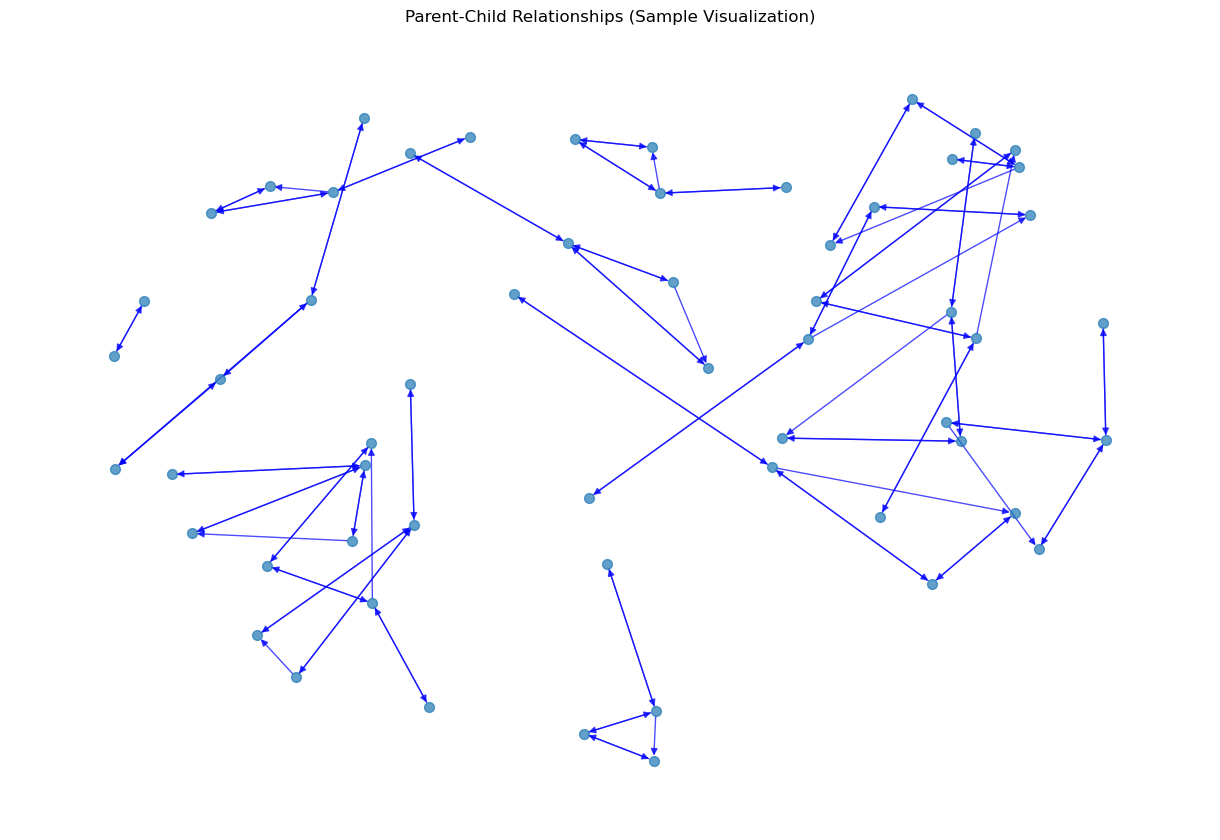

In [71]:
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt

# Connect to Neo4j
graph = Graph(
    os.getenv("NEO4J_URI"), 
    auth=(os.getenv("NEO4J_USER"), os.getenv("NEO4J_PASSWORD"))
)

# Query for relationships (limit to avoid overwhelming visualization)
query = """
MATCH (parent:SurveyGroupVariableNode)-[:HAS_CHILD]->(child:SurveyGroupVariableNode)
RETURN parent.survey_group_variable_id AS parent_id, 
       child.survey_group_variable_id AS child_id
LIMIT 100
"""
results = graph.run(query).data()

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
for row in results:
    G.add_edge(row['parent_id'], row['child_id'])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)  # Positioning algorithm
nx.draw(G, pos, with_labels=False, node_size=50, edge_color="blue", alpha=0.7)
plt.title("Parent-Child Relationships (Sample Visualization)")
plt.show()



# Section 2: Parse and Ingest Ontology (TTL) into Neo4j
We’ll parse the ontology Turtle file using rdflib. We’ll store classes, object properties, and data properties as reference nodes in Neo4j. For now, we won’t apply complex SHACL validation, but we’ll set up the structure for later validation steps.

**Key Points**:
- Parse TTL using rdflib.
- Create OntologyClass, OntologyObjectProperty, and OntologyDataProperty nodes in Neo4j.
- This provides a reference backbone for later data integration and LLM-driven enrichment.


In [2]:
# Section 2: Parse and Ingest Ontology

print("Parsing ontology...")
# Parse ontology
g = Graph()
ontology_path = "./data/ontology_creation/refined_ontology_v1.ttl"
g.parse(ontology_path, format="turtle")

classes = [s for s, p, o in g if str(p).endswith("type") and o.endswith("Class")]
object_properties = [s for s, p, o in g if str(p).endswith("type") and o.endswith("ObjectProperty")]
data_properties = [s for s, p, o in g if str(p).endswith("type") and o.endswith("DatatypeProperty")]

print("Ingesting ontology into Neo4j...")

with driver.session() as session:
    # Create OntologyClass nodes
    for c in classes:
        label = c.split("#")[-1]
        session.run("""
        MERGE (oc:OntologyClass {name: $name, uri: $uri})
        """, name=label, uri=str(c))

    # Create OntologyObjectProperty nodes
    for op in object_properties:
        label = op.split("#")[-1]
        session.run("""
        MERGE (oop:OntologyObjectProperty {name: $name, uri: $uri})
        """, name=label, uri=str(op))

    # Create OntologyDataProperty nodes
    for dp in data_properties:
        label = dp.split("#")[-1]
        session.run("""
        MERGE (odp:OntologyDataProperty {name: $name, uri: $uri})
        """, name=label, uri=str(dp))

print("Ontology parsing and ingestion completed.")


Parsing ontology...
Ingesting ontology into Neo4j...
Ontology parsing and ingestion completed.


# Step 3. Inital data load

Ingest all of the provided data files except for the large directory of chunked group-variable data. 

1. SurveyNode.csv – loads survey nodes.
1. ExamplesNode.csv – links examples to survey nodes.
1. GeographyNode.csv – loads geography nodes (standalone for now).
1. SurveyGroupNode.csv – loads survey groups and links them to survey nodes.
1. SurveyVariablesNoGroupNode.csv – creates a NoGroup node for each survey and links these variables under that pseudo-group.

**Note**:
This code does not iterate through the GroupNodesWithVariables directory. We will handle the large chunked data set separately in a future step. For now, this section ensures that all the basic data (survey, examples, geography, groups, and no-group variables) are loaded into the graph.

**What This Code Does**:
Ensure a consistent pattern and prepares the graph for the next step: ingesting the large, chunked group-variable data set:
1. Surveys: Ingests and sets them as the backbone (:SurveyNode).
1. Examples: Creates :ExamplesNode and links them to their surveys with :HAS_EXAMPLE.
1. Geography: Creates :GeographyNode. If needed, can link them to surveys or to each other.
1. Groups: Creates :SurveyGroupNode and links them to their surveys. This lays the groundwork for grouped variables.
1. No-Group Variables: Treats ungrouped variables as children of a NoGroup group. Creates the NoGroup group node per survey if it doesn’t exist and links variables under it.


In [6]:
constraints = [
    "CREATE CONSTRAINT FOR (g:SurveyGroupNode) REQUIRE g.SurveyGroupID IS UNIQUE;",
    "CREATE CONSTRAINT FOR (s:SurveyNode) REQUIRE s.SurveyID IS UNIQUE;",
    "CREATE CONSTRAINT FOR (v:SurveyVariableNode) REQUIRE v.SurveyGroupVariableID IS UNIQUE;"
]

with driver.session() as session:
    for query in constraints:
        try:
            session.run(query)
            print(f"Constraint applied: {query}")
        except Exception as e:
            print(f"Error applying constraint:\n{query}\n{str(e)}")


Error applying constraint:
CREATE CONSTRAINT FOR (g:SurveyGroupNode) REQUIRE g.SurveyGroupID IS UNIQUE;
{code: Neo.ClientError.Schema.EquivalentSchemaRuleAlreadyExists} {message: An equivalent constraint already exists, 'Constraint( id=5, name='constraint_4702071a', type='UNIQUENESS', schema=(:SurveyGroupNode {SurveyGroupID}), ownedIndex=4 )'.}
Error applying constraint:
CREATE CONSTRAINT FOR (s:SurveyNode) REQUIRE s.SurveyID IS UNIQUE;
{code: Neo.ClientError.Schema.EquivalentSchemaRuleAlreadyExists} {message: An equivalent constraint already exists, 'Constraint( id=3, name='constraint_18316a7e', type='UNIQUENESS', schema=(:SurveyNode {SurveyID}), ownedIndex=2 )'.}
Constraint applied: CREATE CONSTRAINT FOR (v:SurveyVariableNode) REQUIRE v.SurveyGroupVariableID IS UNIQUE;


# Step 4: Merging GroupNodesWithVariables

Below is code for the next step, which involves ingesting the large set of group-variable data stored in multiple CSV files within the GroupNodesWithVariables directory. We will:

1. Iterate over all chunked CSV files in GroupNodesWithVariables.
1. For each chunk:
    - Read the CSV into a DataFrame.
    - (If needed) rename "Variable Name" to "VariableName".
    - For each row, find or create the corresponding :SurveyGroupNode (using SurveyID and GroupName) and :SurveyVariableNode (using SurveyID and VariableName).
    - Link the variable to the group with :HAS_VARIABLE.

**Performance Considerations**:
- This may be time-consuming as the datasets are large: we are going to batch 1000 rows at a time.
- To avoid excessive screen output, we'll track them in groups of 100,000 batches.
- To speed things up, we will set the following indexes are added in Neo4j:

**NOTE**: this syntax is for Neo4j 5.x or later...
```
// Create a uniqueness constraint for SurveyGroupID
CREATE CONSTRAINT FOR (g:SurveyGroupNode)
REQUIRE g.SurveyGroupID IS UNIQUE;

// Create a uniqueness constraint for SurveyID
CREATE CONSTRAINT FOR (s:SurveyNode)
REQUIRE s.SurveyID IS UNIQUE;

// Create a uniqueness constraint for SurveyGroupID and VariableName
CREATE CONSTRAINT FOR (v:SurveyVariableNode)
REQUIRE (v.SurveyGroupID, v.VariableName) IS UNIQUE;

```


In [8]:
import glob
import pandas as pd
from tqdm import tqdm
from neo4j import GraphDatabase
import os

# Retrieve environment variables for Neo4j
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

# Validate that all required environment variables are set
if not NEO4J_URI or not NEO4J_USER or not NEO4J_PASSWORD:
    raise EnvironmentError("Missing Neo4j credentials. Please set NEO4J_URI, NEO4J_USER, and NEO4J_PASSWORD environment variables.")

# Establish the Neo4j driver connection
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Directory containing chunk files
group_variables_dir = "../data/data_extraction/GroupNodesWithVariables/"
chunk_files = sorted(glob.glob(group_variables_dir + "Processed_GroupNode_chunk_*.csv"))

BATCH_SIZE = 1000  # Number of rows per batch
PROGRESS_INTERVAL = 100000  # Display progress every 100,000 rows
total_rows_processed = 0  # Counter to track total rows

with driver.session() as session:
    for chunk_file in chunk_files:
        # Load the CSV into a DataFrame
        df_chunk = pd.read_csv(chunk_file)

        # Standardize column names
        if "Variable Name" in df_chunk.columns:
            df_chunk.rename(columns={"Variable Name": "VariableName"}, inplace=True)
        if "Group" in df_chunk.columns:
            df_chunk.rename(columns={"Group": "GroupName"}, inplace=True)

        # Fill missing values with 'na'
        df_chunk.fillna("na", inplace=True)

        # Create SurveyGroupID if it doesn't already exist
        if "SurveyGroupID" not in df_chunk.columns:
            df_chunk["SurveyGroupID"] = df_chunk["SurveyID"] + "_" + df_chunk["GroupName"]

        # Create SurveyGroupVariableID as the unique key
        df_chunk["SurveyGroupVariableID"] = df_chunk["SurveyGroupID"] + "_" + df_chunk["VariableName"]

        # Dynamically build the SET clause for all columns, escaping names with spaces
        columns_to_ingest = [col for col in df_chunk.columns if col not in ["SurveyID", "GroupName", "VariableName", "SurveyGroupID", "SurveyGroupVariableID"]]
        set_clause = ",\n".join([f"v.`{col}` = row.`{col}`" for col in columns_to_ingest])

        # Process rows in batches
        for start in range(0, len(df_chunk), BATCH_SIZE):
            batch = df_chunk.iloc[start:start + BATCH_SIZE]

            # Prepare parameters for batch
            params_list = [
                {
                    "SurveyGroupID": row["SurveyGroupID"],
                    "VariableName": row["VariableName"],
                    "SurveyGroupVariableID": row["SurveyGroupVariableID"],
                    **{col: row[col] for col in columns_to_ingest}
                }
                for _, row in batch.iterrows()
            ]

            # Send batch as a single transaction
            session.run(f"""
            UNWIND $params_list AS row
            MATCH (g:SurveyGroupNode {{SurveyGroupID: row.SurveyGroupID}})
            MERGE (v:SurveyVariableNode {{
                SurveyGroupID: row.SurveyGroupID,
                VariableName: row.VariableName,
                SurveyGroupVariableID: row.SurveyGroupVariableID
            }})
            ON CREATE SET {set_clause},
                          v.source = "CSV_import",
                          v.enrichment_pass = 0,
                          v.creation_timestamp = timestamp()
            MERGE (g)-[:HAS_VARIABLE]->(v)
            """, {"params_list": params_list})

            # Update total rows processed and display progress
            total_rows_processed += len(batch)
            if total_rows_processed % PROGRESS_INTERVAL == 0:
                print(f"Processed {total_rows_processed} rows so far...")

        print(f"Finished loading {chunk_file}")

print("All group-variable chunks loaded successfully.")


Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_000.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_001.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_002.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_003.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_004.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_005.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_006.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_007.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_008.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_009.csv
Finished l

/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/3202310755.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_chunk.fillna("na", inplace=True)


Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_034.csv


/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/3202310755.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_chunk.fillna("na", inplace=True)


Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_035.csv


/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/3202310755.py:30: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_chunk = pd.read_csv(chunk_file)


Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_036.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_037.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_038.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_039.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_040.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_041.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_042.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_043.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_044.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_045.csv
Finished l

/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/3202310755.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_chunk.fillna("na", inplace=True)


Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_047.csv


/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/3202310755.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_chunk.fillna("na", inplace=True)


Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_048.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_049.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_050.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_051.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_052.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_053.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_054.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_055.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_056.csv
Finished loading ../data/data_extraction/GroupNodesWithVariables/Processed_GroupNode_chunk_057.csv
Finished l

## Step 5: Quick data check and validation
Focusing on data validation and quality checks before proceeding with LLM-based enrichment. This step involves:
1. Creating Constraints and Indexes in Neo4j:
    - To ensure data integrity and improve query performance, we’ll add uniqueness constraints and indexes. This helps detect unexpected duplicates and speeds up queries for enrichment and analysis.

**Data Validation and Constraints**:
Now that all data (surveys, examples, geography, groups, variables) is ingested, the next logical step is to validate and improve the data quality. This involves:
- Adding Neo4j constraints to ensure uniqueness of certain identifiers (e.g., SurveyID, (SurveyID, GroupName), (SurveyID, VariableName)).
- Reviewing logs and metrics to confirm that ingestion completed without errors or anomalies.

**NOTE**: These checks are done before initiating LLM-driven enrichment as we would like to ensure that the knowledge graph is stable and consistent.

In [9]:
# Syntax is for Neo4j 4.5 ... 
# Next Step: Add Constraints

# Add uniqueness constraints
with driver.session() as session:
    try:
        # Create uniqueness constraint for SurveyNode
        session.run("CREATE CONSTRAINT constraint_for_SurveyNode FOR (s:SurveyNode) REQUIRE s.SurveyID IS UNIQUE")
    except Exception as e:
        if "already exists" in str(e):
            print("Constraint for SurveyNode already exists.")
        else:
            raise e

    try:
        # Create uniqueness constraint for SurveyGroupNode
        session.run("CREATE CONSTRAINT constraint_for_SurveyGroupNode FOR (g:SurveyGroupNode) REQUIRE (g.SurveyID, g.GroupName) IS UNIQUE")
    except Exception as e:
        if "already exists" in str(e):
            print("Constraint for SurveyGroupNode already exists.")
        else:
            raise e

    try:
        # Create uniqueness constraint for SurveyVariableNode
        session.run("CREATE CONSTRAINT constraint_for_SurveyVariableNode FOR (v:SurveyVariableNode) REQUIRE (v.SurveyID, v.VariableName) IS UNIQUE")
    except Exception as e:
        if "already exists" in str(e):
            print("Constraint for SurveyVariableNode already exists.")
        else:
            raise e

print("Constraints have been created or verified.")




Constraint for SurveyNode already exists.
Constraint for SurveyGroupNode already exists.
Constraint for SurveyVariableNode already exists.
Constraints have been created or verified.


# Section 3: Graph Enrichment

**Combine Global and Local Enrichment**
1. Start by extracting and enriching globally for consistency. Once global concepts are clear, focus on details (e.g., demographics, geography).
Extract Key Data Points from the graph:
    - Pull out all existing metadata, relationships, and variables already in the Neo4j database.
    - Create a flat structure or table-like output that the LLM can analyze without the need for a complex ontology upfront.

2. Use LLM for Concept Categorization and Discovery:
    - Feed this extracted data into an LLM, asking it to identify concepts, relationships, and patterns.
    - Start simple—ask the LLM to categorize variables, suggest relationships, or highlight potential gaps.

3. Iterate and Integrate Results:
    - After the LLM suggests new concepts or categorizes data, update Neo4j with this information iteratively.

4. Work Backwards to Define Minimal Ontology:
    - Based on the insights, create only the necessary structures (concepts, relationships) to manage and query your data effectively.
  
## Step 1: Extract Key Data Points

In [12]:
from neo4j import GraphDatabase
import pandas as pd
from tqdm import tqdm

# Neo4j connection
NEO4J_URI = "bolt://localhost:7687"  # Update as needed
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Batch size for fetching data
BATCH_SIZE = 1000  # Adjust based on your system capacity
PROGRESS_UPDATE_INTERVAL = 100  # Output a message every 100 batches

def extract_nodes_in_batches():
    with driver.session() as session:
        # Initialize batch variables
        skip = 0
        total_nodes = session.run("MATCH (n) RETURN count(n) AS count").single()["count"]
        all_nodes = []
        batch_count = 0

        # Fetch nodes in batches
        while skip < total_nodes:
            query = f"""
            MATCH (n)
            RETURN labels(n) AS labels, properties(n) AS properties, elementId(n) AS element_id
            SKIP {skip} LIMIT {BATCH_SIZE}
            """
            nodes = session.run(query)
            batch = [{"element_id": record["element_id"], "labels": record["labels"], **record["properties"]} for record in nodes]
            all_nodes.extend(batch)
            skip += BATCH_SIZE
            batch_count += 1

            # Output progress at intervals
            if batch_count % PROGRESS_UPDATE_INTERVAL == 0:
                print(f"Processed {batch_count * BATCH_SIZE} / {total_nodes} nodes.")
        
        return all_nodes

def extract_relationships_in_batches():
    with driver.session() as session:
        # Initialize batch variables
        skip = 0
        total_relationships = session.run("MATCH ()-[r]->() RETURN count(r) AS count").single()["count"]
        all_relationships = []
        batch_count = 0

        # Fetch relationships in batches
        while skip < total_relationships:
            query = f"""
            MATCH (n)-[r]->(m)
            RETURN type(r) AS type, properties(r) AS properties, elementId(r) AS element_id, elementId(n) AS start_id, elementId(m) AS end_id
            SKIP {skip} LIMIT {BATCH_SIZE}
            """
            relationships = session.run(query)
            batch = [{
                "element_id": record["element_id"],
                "type": record["type"],
                "start_id": record["start_id"],
                "end_id": record["end_id"],
                **record["properties"]
            } for record in relationships]
            all_relationships.extend(batch)
            skip += BATCH_SIZE
            batch_count += 1

            # Output progress at intervals
            if batch_count % PROGRESS_UPDATE_INTERVAL == 0:
                print(f"Processed {batch_count * BATCH_SIZE} / {total_relationships} relationships.")
        
        return all_relationships

# Run the extraction in batches
print("Extracting nodes...")
nodes = extract_nodes_in_batches()
nodes_df = pd.DataFrame(nodes)
nodes_df.to_csv("../data/ontology_creation/nodes.csv", index=False)

print("Extracting relationships...")
relationships = extract_relationships_in_batches()
relationships_df = pd.DataFrame(relationships)
relationships_df.to_csv("../data/ontology_creation/relationships.csv", index=False)

print("Node and relationship data extracted to nodes.csv and relationships.csv.")


Extracting nodes...
Processed 100000 / 8326446 nodes.
Processed 200000 / 8326446 nodes.
Processed 300000 / 8326446 nodes.
Processed 400000 / 8326446 nodes.
Processed 500000 / 8326446 nodes.
Processed 600000 / 8326446 nodes.
Processed 700000 / 8326446 nodes.
Processed 800000 / 8326446 nodes.
Processed 900000 / 8326446 nodes.
Processed 1000000 / 8326446 nodes.
Processed 1100000 / 8326446 nodes.
Processed 1200000 / 8326446 nodes.
Processed 1300000 / 8326446 nodes.
Processed 1400000 / 8326446 nodes.
Processed 1500000 / 8326446 nodes.
Processed 1600000 / 8326446 nodes.
Processed 1700000 / 8326446 nodes.
Processed 1800000 / 8326446 nodes.
Processed 1900000 / 8326446 nodes.
Processed 2000000 / 8326446 nodes.
Processed 2100000 / 8326446 nodes.
Processed 2200000 / 8326446 nodes.
Processed 2300000 / 8326446 nodes.
Processed 2400000 / 8326446 nodes.
Processed 2500000 / 8326446 nodes.
Processed 2600000 / 8326446 nodes.
Processed 2700000 / 8326446 nodes.
Processed 2800000 / 8326446 nodes.
Processed

## Step 2. Process Data for LLM
This involves formatting the extracted data into structured, LLM-compatible chunks, ensuring token limits are respected and data is enriched with necessary context (e.g., variable descriptions, relationships, or metadata) for optimal analysis.

**What We Did Previously**
We successfully extracted all nodes and relationships from the Neo4j database, creating a flat structure of metadata and connections for further analysis.

**What We Are Doing Now**
We are processing the extracted data into manageable chunks, standardizing column names, and formatting the information into structured inputs for an LLM. This includes splitting nodes by type, flattening relationships, and chunking data to ensure compatibility with OpenAI’s token limits.

**Goal**
The immediate goal is to leverage an LLM to identify patterns, suggest concept categorizations, enrich metadata, and uncover missing or inferred relationships. The next step will involve integrating the LLM-generated insights back into Neo4j to iteratively refine the knowledge graph.

### Step 2.1: Format the Data for Input
We’ll prepare the data by:
1. Splitting Nodes by Type: Divide the nodes.csv into separate files or DataFrames for each node type (e.g., SurveyNode, SurveyVariableNode).
1. Flattening Relationships: Map relationships to make them human-readable (e.g., {node1} is related to {node2} via {relationship}).
1. Selecting Key Attributes: Focus only on the most relevant columns for the LLM (like VariableName, Description, SurveyID).

In [19]:
import pandas as pd
import os
from tqdm import tqdm

# File paths
nodes_file = "../data/ontology_creation/nodes.csv"
relationships_file = "../data/ontology_creation/relationships.csv"
output_dir = "../data/ontology_creation/formatted_data"
os.makedirs(output_dir, exist_ok=True)

# Load data
nodes = pd.read_csv(nodes_file)
relationships = pd.read_csv(relationships_file)

# Parse the `labels` column to extract node type
nodes["labels"] = nodes["labels"].str.strip("[]").str.replace("'", "").str.split(", ")

# Split nodes by type with tqdm progress bar
print("Splitting nodes by type...")
unique_node_types = nodes["labels"].explode().unique()
for node_type in tqdm(unique_node_types, desc="Processing node types"):
    subset = nodes[nodes["labels"].apply(lambda x: node_type in x)]
    output_path = os.path.join(output_dir, f"{node_type}_nodes.csv")
    subset.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

# Flatten relationships with tqdm progress bar
print("Flattening relationships...")
flattened_relationships = pd.DataFrame()
relationship_chunks = tqdm(
    range(0, len(relationships), 10000), desc="Processing relationships", unit="batch"
)

for start_idx in relationship_chunks:
    chunk = relationships.iloc[start_idx : start_idx + 10000]
    merged_start = chunk.merge(
        nodes[["element_id", "labels"]].rename(columns={"labels": "start_labels"}), 
        left_on="start_id", 
        right_on="element_id"
    )
    merged_end = merged_start.merge(
        nodes[["element_id", "labels"]].rename(columns={"labels": "end_labels"}), 
        left_on="end_id", 
        right_on="element_id"
    )
    flattened_relationships = pd.concat([flattened_relationships, merged_end])

# Retain only the necessary columns
flattened_relationships = flattened_relationships[[
    "type", "start_labels", "end_labels", "start_id", "end_id"
]]

# Save flattened relationships
output_path = os.path.join(output_dir, "flattened_relationships.csv")
flattened_relationships.to_csv(output_path, index=False)
print(f"Saved flattened relationships to {output_path}")


/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/2827371435.py:12: DtypeWarning: Columns (2,3,4,5,6,7,10,12,13,14,15,17,18,19,21,22,23,24,25,26,27,29,30,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes = pd.read_csv(nodes_file)


Splitting nodes by type...


Processing node types:  12%|██▋                  | 1/8 [03:12<22:24, 192.11s/it]

Saved: ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv


Processing node types:  25%|█████▌                | 2/8 [03:17<08:15, 82.56s/it]

Saved: ../data/ontology_creation/formatted_data/OntologyClass_nodes.csv


Processing node types:  38%|████████▎             | 3/8 [03:19<03:47, 45.54s/it]

Saved: ../data/ontology_creation/formatted_data/OntologyObjectProperty_nodes.csv


Processing node types:  50%|███████████           | 4/8 [03:20<01:51, 27.87s/it]

Saved: ../data/ontology_creation/formatted_data/OntologyDataProperty_nodes.csv


Processing node types:  62%|█████████████▊        | 5/8 [03:21<00:54, 18.12s/it]

Saved: ../data/ontology_creation/formatted_data/SurveyNode_nodes.csv


Processing node types:  75%|████████████████▌     | 6/8 [03:22<00:24, 12.32s/it]

Saved: ../data/ontology_creation/formatted_data/ExamplesNode_nodes.csv


Processing node types:  88%|███████████████████▎  | 7/8 [03:23<00:08,  8.57s/it]

Saved: ../data/ontology_creation/formatted_data/GeographyNode_nodes.csv


Processing node types: 100%|██████████████████████| 8/8 [03:24<00:00, 25.55s/it]


Saved: ../data/ontology_creation/formatted_data/SurveyGroupNode_nodes.csv
Flattening relationships...


Processing relationships: 100%|██████████| 833/833 [1:59:18<00:00,  8.59s/batch]


Saved flattened relationships to ../data/ontology_creation/formatted_data/flattened_relationships.csv


### Step 2.2: Create Input Chunks
Split the formatted data into manageable pieces for the LLM. Each chunk should:
- Fit within the OpenAI token limit (4000 tokens for GPT-4, including the prompt).
- Contain enough context for meaningful analysis (e.g., ~100 rows per chunk).


Key Features of this Script:
1. Dynamic Chunk Sizes:
    - Files larger than 1 GB use chunked reading to avoid memory overflows.
    - SurveyVariableNode_nodes.csv (12.15 GB) uses chunks of 50,000 rows.
    - flattened_relationships.csv (1.24 GB) uses chunks of 10,000 rows.
    - All other smaller files use the default chunk size of 100 rows.

1. tqdm Progress Bar:
    - Progress bars monitor the chunking process for both large and small files.

1. Large File Optimization:
    - Files > 1 GB are processed in-memory in smaller chunks using pandas' chunksize.

1. Flexible File Configuration:
    - Easily add new files or adjust chunk sizes for specific files.

In [20]:
import pandas as pd
import os
from tqdm import tqdm

def create_chunks(input_file, chunk_size=100, output_dir="llm_chunks"):
    """
    Splits a large CSV file into smaller chunks.

    Args:
        input_file (str): Path to the input CSV file.
        chunk_size (int): Number of rows per chunk.
        output_dir (str): Directory to save the chunks.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Check file size and determine if we need to use chunked reading
    file_size = os.path.getsize(input_file) / (1024 ** 3)  # Size in GB
    use_chunked_reading = file_size > 1.0  # Use chunked reading for files > 1GB

    if use_chunked_reading:
        print(f"Processing large file {input_file} (Size: {file_size:.2f} GB) with chunked reading...")
        reader = pd.read_csv(input_file, chunksize=chunk_size)
        for i, chunk in enumerate(tqdm(reader, desc=f"Processing {input_file}")):
            output_path = os.path.join(output_dir, f"{os.path.basename(input_file).split('.')[0]}_chunk_{i + 1}.csv")
            chunk.to_csv(output_path, index=False)
            print(f"Saved chunk: {output_path}")
    else:
        print(f"Processing smaller file {input_file} (Size: {file_size:.2f} GB) with direct reading...")
        df = pd.read_csv(input_file)
        chunk_count = len(df) // chunk_size + (1 if len(df) % chunk_size != 0 else 0)

        for i in tqdm(range(chunk_count), desc=f"Processing {input_file}"):
            chunk = df[i * chunk_size:(i + 1) * chunk_size]
            output_path = os.path.join(output_dir, f"{os.path.basename(input_file).split('.')[0]}_chunk_{i + 1}.csv")
            chunk.to_csv(output_path, index=False)
            print(f"Saved chunk: {output_path}")

# File paths and dynamic chunk size settings
input_files = {
    "../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv": 50000,  # 50K rows for largest file
    "../data/ontology_creation/formatted_data/flattened_relationships.csv": 10000,  # 10K rows for second-largest file
    "../data/ontology_creation/formatted_data/SurveyNode_nodes.csv": 100,  # Default for smaller files
    "../data/ontology_creation/formatted_data/GeographyNode_nodes.csv": 100,
    "../data/ontology_creation/formatted_data/SurveyGroupNode_nodes.csv": 100,
    "../data/ontology_creation/formatted_data/ExamplesNode_nodes.csv": 100,
}

# Process all files
for input_file, chunk_size in input_files.items():
    create_chunks(input_file, chunk_size=chunk_size, output_dir="llm_chunks")

print("All files have been chunked successfully!")



Processing large file ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv (Size: 11.31 GB) with chunked reading...


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 1it [00:02,  2.08s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_1.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 2it [00:04,  2.30s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_2.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 3it [00:05,  1.71s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_3.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 4it [00:07,  1.88s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_4.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 5it [00:09,  1.98s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_5.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 6it [00:12,  2.08s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_6.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 7it [00:12,  1.66s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_7.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 8it [00:14,  1.63s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_8.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 9it [00:16,  1.71s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_9.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 10it [00:17,  1.68s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_10.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 11it [00:18,  1.48s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_11.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 12it [00:20,  1.62s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_12.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 13it [00:22,  1.72s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_13.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 14it [00:25,  2.00s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_14.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 15it [00:26,  1.64s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_15.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 16it [00:27,  1.54s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_16.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 17it [00:29,  1.72s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_17.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 18it [00:31,  1.71s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_18.csv


/opt/anaconda3/envs/graphrag_env/lib/python3.11/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (3,5,6,7,12,13,14,15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 19it [00:32,  1.42s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_19.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 20it [00:32,  1.14s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_20.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 21it [00:33,  1.05it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_21.csv


/opt/anaconda3/envs/graphrag_env/lib/python3.11/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 22it [00:33,  1.22it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_22.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 23it [00:34,  1.36it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_23.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 24it [00:34,  1.50it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_24.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 25it [00:35,  1.59it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_25.csv


/opt/anaconda3/envs/graphrag_env/lib/python3.11/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 26it [00:35,  1.70it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_26.csv


/opt/anaconda3/envs/graphrag_env/lib/python3.11/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 27it [00:36,  1.78it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_27.csv


/opt/anaconda3/envs/graphrag_env/lib/python3.11/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 28it [00:36,  1.86it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_28.csv


/opt/anaconda3/envs/graphrag_env/lib/python3.11/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 29it [00:37,  1.91it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_29.csv


/opt/anaconda3/envs/graphrag_env/lib/python3.11/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (3,5,6,7,12,13,14,15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 30it [00:38,  1.33it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_30.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 31it [00:40,  1.15s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_31.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 32it [00:42,  1.48s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_32.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 33it [00:44,  1.51s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_33.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 34it [00:45,  1.49s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_34.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 35it [00:47,  1.52s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_35.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 36it [00:48,  1.51s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_36.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 37it [00:50,  1.53s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_37.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 38it [00:52,  1.59s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_38.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 39it [00:53,  1.60s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_39.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 40it [00:55,  1.62s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_40.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 41it [00:57,  1.60s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_41.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 42it [00:58,  1.62s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_42.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 43it [01:00,  1.60s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_43.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 44it [01:01,  1.61s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_44.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 45it [01:03,  1.59s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_45.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 46it [01:04,  1.54s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_46.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 47it [01:06,  1.55s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_47.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 48it [01:08,  1.53s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_48.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 49it [01:09,  1.57s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_49.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 50it [01:11,  1.62s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_50.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 51it [01:12,  1.56s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_51.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 52it [01:14,  1.55s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_52.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 53it [01:15,  1.45s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_53.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 54it [01:16,  1.23s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_54.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 55it [01:17,  1.07s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_55.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 56it [01:17,  1.03it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_56.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 57it [01:18,  1.11it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_57.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 58it [01:19,  1.18it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_58.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 59it [01:20,  1.11it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_59.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 60it [01:21,  1.00s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_60.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 61it [01:22,  1.05s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_61.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 62it [01:23,  1.01it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_62.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 63it [01:24,  1.02s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_63.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 64it [01:25,  1.12s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_64.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 65it [01:26,  1.02it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_65.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 66it [01:27,  1.13it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_66.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 67it [01:27,  1.21it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_67.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 68it [01:28,  1.24it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_68.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 69it [01:30,  1.03s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_69.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 70it [01:31,  1.18s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_70.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 71it [01:33,  1.31s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_71.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 72it [01:34,  1.15s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_72.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 73it [01:35,  1.32s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_73.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 74it [01:37,  1.52s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_74.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 75it [01:38,  1.30s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_75.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 76it [01:41,  1.63s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_76.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 77it [01:43,  1.85s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_77.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 78it [01:45,  2.02s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_78.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 79it [01:46,  1.65s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_79.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 80it [01:48,  1.56s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_80.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 81it [01:49,  1.52s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_81.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 82it [01:51,  1.57s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_82.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 83it [01:52,  1.39s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_83.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 84it [01:53,  1.47s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_84.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 85it [01:55,  1.63s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_85.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 86it [01:57,  1.55s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_86.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 87it [01:59,  1.70s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_87.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 88it [02:01,  1.88s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_88.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 89it [02:03,  2.01s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_89.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 90it [02:05,  1.95s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_90.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 91it [02:06,  1.62s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_91.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 92it [02:08,  1.61s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_92.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 93it [02:09,  1.54s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_93.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 94it [02:10,  1.48s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_94.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 95it [02:11,  1.35s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_95.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 96it [02:13,  1.59s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_96.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 97it [02:15,  1.67s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_97.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 98it [02:16,  1.46s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_98.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 99it [02:19,  1.72s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_99.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 100it [02:21,  1.85s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_100.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 101it [02:23,  1.82s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_101.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 102it [02:23,  1.52s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_102.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 103it [02:25,  1.70s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_103.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 104it [02:28,  1.82s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_104.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 105it [02:30,  1.98s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_105.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 106it [02:31,  1.69s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_106.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 107it [02:32,  1.48s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_107.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 108it [02:34,  1.64s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_108.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 109it [02:36,  1.85s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_109.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 110it [02:37,  1.55s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_110.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 111it [02:38,  1.50s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_111.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 112it [02:41,  1.74s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_112.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 113it [02:43,  1.84s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_113.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 114it [02:45,  1.90s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_114.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 115it [02:46,  1.58s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_115.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 116it [02:47,  1.62s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_116.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 117it [02:49,  1.68s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_117.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 118it [02:51,  1.74s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_118.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 119it [02:52,  1.47s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_119.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 120it [02:53,  1.35s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_120.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 121it [02:55,  1.66s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_121.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 122it [02:57,  1.75s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_122.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 123it [02:59,  1.84s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_123.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 124it [03:00,  1.54s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_124.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 125it [03:02,  1.57s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_125.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 126it [03:04,  1.64s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_126.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 127it [03:06,  1.77s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_127.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 128it [03:07,  1.49s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_128.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 129it [03:09,  1.61s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_129.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 130it [03:10,  1.66s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_130.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 131it [03:12,  1.76s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_131.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 132it [03:13,  1.49s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_132.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 133it [03:14,  1.32s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_133.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 134it [03:15,  1.18s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_134.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 135it [03:16,  1.10s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_135.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 136it [03:17,  1.03s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_136.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 137it [03:18,  1.03it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_137.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 138it [03:19,  1.01it/s]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_138.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 139it [03:21,  1.40s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_139.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 140it [03:22,  1.37s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_140.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 141it [03:23,  1.24s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_141.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 142it [03:25,  1.56s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_142.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 143it [03:27,  1.69s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_143.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 144it [03:30,  1.97s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_144.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 145it [03:31,  1.70s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_145.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 146it [03:32,  1.50s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_146.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 147it [03:34,  1.64s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_147.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 148it [03:37,  1.85s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_148.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 149it [03:38,  1.72s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_149.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 150it [03:39,  1.47s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_150.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 151it [03:41,  1.72s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_151.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 152it [03:43,  1.73s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_152.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 153it [03:45,  1.95s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_153.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 154it [03:47,  1.82s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_154.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 155it [03:48,  1.52s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_155.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 156it [03:50,  1.71s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_156.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 157it [03:52,  1.83s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_157.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 158it [03:54,  1.78s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_158.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 159it [03:55,  1.53s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_159.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 160it [03:57,  1.83s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_160.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 161it [03:59,  1.87s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_161.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 162it [04:02,  2.10s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_162.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 163it [04:03,  1.81s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_163.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 164it [04:04,  1.54s/it]

Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_164.csv


Processing ../data/ontology_creation/formatted_data/SurveyVariableNode_nodes.csv: 165it [04:05,  1.49s/it]


Saved chunk: llm_chunks/SurveyVariableNode_nodes_chunk_165.csv
Processing large file ../data/ontology_creation/formatted_data/flattened_relationships.csv (Size: 1.16 GB) with chunked reading...


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 4it [00:00, 29.49it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_1.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_2.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_3.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_4.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_5.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_6.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 11it [00:00, 29.45it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_7.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_8.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_9.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_10.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_11.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_12.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_13.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 15it [00:00, 29.68it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_14.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_15.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_16.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_17.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_18.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 19it [00:00, 29.71it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_19.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 22it [00:00, 29.51it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_20.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_21.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_22.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_23.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_24.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 25it [00:00, 28.55it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_25.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 28it [00:00, 28.08it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_26.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_27.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_28.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_29.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_30.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 31it [00:01, 27.34it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_31.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 34it [00:01, 27.88it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_32.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_33.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_34.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_35.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_36.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 37it [00:01, 27.94it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_37.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 40it [00:01, 28.31it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_38.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_39.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_40.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_41.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_42.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 43it [00:01, 28.62it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_43.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 46it [00:01, 26.09it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_44.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_45.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_46.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_47.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_48.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 52it [00:01, 24.57it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_49.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_50.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_51.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_52.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_53.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 58it [00:02, 23.46it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_54.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_55.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_56.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_57.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_58.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_59.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 64it [00:02, 24.49it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_60.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_61.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_62.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_63.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_64.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 70it [00:02, 25.48it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_65.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_66.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_67.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_68.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_69.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_70.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 76it [00:02, 27.24it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_71.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_72.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_73.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_74.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_75.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_76.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 82it [00:03, 26.45it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_77.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_78.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_79.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_80.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_81.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_82.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 85it [00:03, 25.30it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_83.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_84.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_85.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_86.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_87.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 91it [00:03, 25.52it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_88.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_89.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_90.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_91.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_92.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_93.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 97it [00:03, 24.59it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_94.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_95.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_96.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_97.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_98.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 103it [00:03, 24.66it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_99.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_100.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_101.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_102.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_103.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_104.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 109it [00:04, 26.71it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_105.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_106.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_107.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_108.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_109.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_110.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 115it [00:04, 28.04it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_111.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_112.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_113.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_114.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_115.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_116.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 121it [00:04, 28.79it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_117.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_118.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_119.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_120.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_121.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_122.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 127it [00:04, 29.02it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_123.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_124.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_125.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_126.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_127.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_128.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 133it [00:04, 29.19it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_129.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_130.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_131.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_132.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_133.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_134.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 139it [00:05, 28.99it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_135.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_136.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_137.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_138.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_139.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_140.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 145it [00:05, 25.95it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_141.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_142.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_143.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_144.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_145.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 148it [00:05, 23.59it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_146.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_147.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_148.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_149.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_150.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 154it [00:05, 24.48it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_151.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_152.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_153.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_154.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_155.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_156.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 160it [00:06, 24.86it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_157.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_158.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_159.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_160.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_161.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 166it [00:06, 25.93it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_162.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_163.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_164.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_165.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_166.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_167.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 172it [00:06, 27.47it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_168.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_169.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_170.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_171.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_172.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_173.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 179it [00:06, 28.60it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_174.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_175.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_176.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_177.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_178.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_179.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 185it [00:06, 28.91it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_180.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_181.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_182.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_183.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_184.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_185.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 188it [00:07, 28.90it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_186.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_187.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_188.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_189.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_190.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_191.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 195it [00:07, 26.37it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_192.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_193.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_194.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_195.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_196.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 201it [00:07, 25.58it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_197.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_198.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_199.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_200.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_201.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 204it [00:07, 25.08it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_202.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_203.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_204.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_205.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_206.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 210it [00:07, 23.87it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_207.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_208.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_209.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_210.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_211.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 216it [00:08, 23.60it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_212.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_213.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_214.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_215.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_216.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_217.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 222it [00:08, 24.24it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_218.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_219.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_220.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_221.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_222.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 228it [00:08, 24.91it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_223.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_224.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_225.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_226.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_227.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_228.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 231it [00:08, 24.42it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_229.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_230.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_231.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_232.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_233.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 237it [00:09, 24.09it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_234.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_235.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_236.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_237.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_238.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_239.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 243it [00:09, 22.15it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_240.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_241.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_242.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_243.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_244.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 249it [00:09, 24.76it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_245.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_246.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_247.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_248.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_249.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_250.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 255it [00:09, 25.37it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_251.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_252.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_253.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_254.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_255.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_256.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 261it [00:09, 26.64it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_257.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_258.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_259.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_260.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_261.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_262.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 267it [00:10, 26.97it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_263.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_264.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_265.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_266.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_267.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_268.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 273it [00:10, 22.60it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_269.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_270.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_271.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_272.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_273.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 279it [00:10, 24.63it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_274.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_275.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_276.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_277.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_278.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_279.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 285it [00:10, 26.01it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_280.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_281.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_282.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_283.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_284.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_285.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 288it [00:11, 19.61it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_286.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_287.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_288.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 291it [00:11, 14.89it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_289.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_290.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_291.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 295it [00:11, 15.37it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_292.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_293.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_294.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_295.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 299it [00:12, 16.11it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_296.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_297.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_298.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_299.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 305it [00:12, 21.34it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_300.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_301.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_302.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_303.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_304.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_305.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 311it [00:12, 24.36it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_306.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_307.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_308.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_309.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_310.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_311.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 314it [00:12, 22.81it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_312.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_313.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_314.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_315.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 317it [00:12, 20.93it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_316.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_317.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_318.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 320it [00:12, 18.41it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_319.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_320.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_321.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 324it [00:13, 15.36it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_322.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_323.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_324.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_325.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 329it [00:13, 17.91it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_326.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_327.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_328.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_329.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_330.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 335it [00:13, 21.91it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_331.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_332.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_333.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_334.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_335.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_336.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 341it [00:13, 24.78it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_337.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_338.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_339.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_340.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_341.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_342.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 347it [00:14, 26.11it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_343.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_344.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_345.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_346.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_347.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_348.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 353it [00:14, 27.48it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_349.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_350.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_351.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_352.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_353.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_354.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 359it [00:14, 28.16it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_355.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_356.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_357.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_358.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_359.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_360.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 365it [00:14, 28.66it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_361.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_362.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_363.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_364.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_365.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_366.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 371it [00:15, 26.34it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_367.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_368.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_369.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_370.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_371.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 374it [00:15, 23.63it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_372.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_373.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_374.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_375.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 377it [00:15, 21.48it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_376.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_377.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_378.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_379.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 383it [00:15, 20.89it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_380.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_381.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_382.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_383.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_384.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 389it [00:15, 22.58it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_385.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_386.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_387.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_388.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_389.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 392it [00:16, 23.35it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_390.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_391.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_392.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_393.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_394.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 398it [00:16, 21.63it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_395.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_396.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_397.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_398.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_399.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 404it [00:16, 21.84it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_400.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_401.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_402.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_403.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_404.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 407it [00:16, 20.92it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_405.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_406.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_407.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_408.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_409.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 413it [00:17, 22.28it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_410.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_411.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_412.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_413.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_414.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 419it [00:17, 24.68it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_415.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_416.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_417.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_418.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_419.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_420.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 425it [00:17, 25.82it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_421.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_422.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_423.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_424.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_425.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_426.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 431it [00:17, 23.33it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_427.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_428.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_429.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_430.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_431.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 434it [00:17, 23.96it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_432.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_433.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_434.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_435.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_436.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 440it [00:18, 23.53it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_437.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_438.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_439.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_440.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_441.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_442.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 446it [00:18, 24.03it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_443.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_444.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_445.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_446.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_447.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_448.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 452it [00:18, 25.01it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_449.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_450.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_451.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_452.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_453.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 458it [00:18, 24.93it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_454.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_455.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_456.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_457.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_458.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_459.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 464it [00:19, 24.80it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_460.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_461.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_462.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_463.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_464.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 470it [00:19, 24.75it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_465.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_466.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_467.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_468.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_469.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_470.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 473it [00:19, 24.32it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_471.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_472.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_473.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_474.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_475.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 479it [00:19, 25.44it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_476.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_477.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_478.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_479.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_480.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_481.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 485it [00:19, 27.16it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_482.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_483.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_484.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_485.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_486.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_487.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 491it [00:20, 28.25it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_488.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_489.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_490.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_491.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_492.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_493.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 497it [00:20, 28.36it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_494.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_495.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_496.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_497.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_498.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_499.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 503it [00:20, 28.77it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_500.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_501.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_502.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_503.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_504.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_505.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 509it [00:20, 26.99it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_506.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_507.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_508.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_509.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_510.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 515it [00:21, 23.94it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_511.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_512.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_513.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_514.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_515.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 518it [00:21, 24.18it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_516.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_517.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_518.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_519.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_520.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 524it [00:21, 23.62it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_521.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_522.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_523.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_524.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_525.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 530it [00:21, 24.90it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_526.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_527.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_528.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_529.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_530.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_531.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 536it [00:21, 27.03it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_532.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_533.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_534.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_535.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_536.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_537.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 542it [00:22, 27.19it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_538.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_539.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_540.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_541.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_542.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_543.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 548it [00:22, 27.06it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_544.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_545.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_546.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_547.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_548.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_549.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 554it [00:22, 25.82it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_550.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_551.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_552.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_553.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_554.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 557it [00:22, 23.29it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_555.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_556.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_557.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_558.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_559.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 563it [00:22, 23.54it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_560.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_561.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_562.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_563.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_564.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 569it [00:23, 23.90it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_565.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_566.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_567.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_568.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_569.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_570.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 575it [00:23, 25.73it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_571.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_572.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_573.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_574.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_575.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_576.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 581it [00:23, 23.92it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_577.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_578.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_579.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_580.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_581.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 587it [00:23, 24.84it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_582.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_583.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_584.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_585.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_586.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_587.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 590it [00:24, 25.28it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_588.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_589.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_590.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_591.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_592.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 596it [00:24, 25.15it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_593.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_594.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_595.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_596.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_597.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_598.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 602it [00:24, 26.52it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_599.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_600.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_601.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_602.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_603.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_604.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 608it [00:24, 27.86it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_605.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_606.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_607.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_608.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_609.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_610.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 614it [00:24, 24.86it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_611.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_612.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_613.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_614.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_615.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 620it [00:25, 25.23it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_616.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_617.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_618.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_619.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_620.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 623it [00:25, 25.34it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_621.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_622.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_623.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_624.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_625.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 629it [00:25, 24.84it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_626.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_627.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_628.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_629.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_630.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 635it [00:25, 25.74it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_631.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_632.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_633.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_634.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_635.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_636.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 641it [00:26, 26.39it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_637.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_638.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_639.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_640.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_641.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_642.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 647it [00:26, 27.95it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_643.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_644.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_645.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_646.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_647.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_648.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_649.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 653it [00:26, 26.63it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_650.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_651.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_652.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_653.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_654.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 659it [00:26, 24.47it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_655.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_656.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_657.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_658.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_659.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 665it [00:26, 24.36it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_660.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_661.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_662.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_663.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_664.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_665.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 668it [00:27, 24.31it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_666.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_667.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_668.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_669.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_670.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 674it [00:27, 23.80it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_671.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_672.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_673.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_674.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_675.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_676.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 680it [00:27, 23.07it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_677.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_678.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_679.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_680.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_681.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 686it [00:27, 23.55it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_682.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_683.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_684.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_685.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_686.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 689it [00:27, 23.29it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_687.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_688.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_689.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_690.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_691.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 695it [00:28, 23.78it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_692.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_693.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_694.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_695.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_696.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 701it [00:28, 23.95it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_697.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_698.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_699.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_700.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_701.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 707it [00:28, 25.33it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_702.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_703.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_704.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_705.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_706.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_707.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 710it [00:28, 24.32it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_708.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_709.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_710.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_711.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_712.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 716it [00:29, 24.05it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_713.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_714.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_715.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_716.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_717.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 722it [00:29, 24.28it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_718.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_719.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_720.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_721.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_722.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 728it [00:29, 24.86it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_723.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_724.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_725.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_726.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_727.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_728.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 734it [00:29, 25.97it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_729.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_730.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_731.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_732.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_733.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_734.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 740it [00:30, 26.31it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_735.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_736.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_737.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_738.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_739.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_740.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 746it [00:30, 26.69it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_741.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_742.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_743.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_744.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_745.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_746.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 749it [00:30, 26.23it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_747.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_748.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_749.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_750.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_751.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 755it [00:30, 22.35it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_752.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_753.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_754.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_755.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 758it [00:30, 22.22it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_756.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_757.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_758.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_759.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_760.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 764it [00:31, 23.92it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_761.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_762.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_763.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_764.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_765.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_766.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 770it [00:31, 25.12it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_767.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_768.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_769.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_770.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_771.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_772.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 776it [00:31, 26.82it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_773.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_774.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_775.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_776.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_777.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_778.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 782it [00:31, 27.99it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_779.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_780.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_781.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_782.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_783.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_784.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 788it [00:31, 26.35it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_785.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_786.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_787.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_788.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_789.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 794it [00:32, 24.98it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_790.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_791.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_792.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_793.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_794.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 797it [00:32, 24.65it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_795.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_796.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_797.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_798.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_799.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 803it [00:32, 24.37it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_800.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_801.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_802.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_803.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_804.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 809it [00:32, 25.14it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_805.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_806.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_807.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_808.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_809.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_810.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 815it [00:32, 27.06it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_811.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_812.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_813.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_814.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_815.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_816.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 821it [00:33, 28.09it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_817.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_818.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_819.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_820.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_821.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_822.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 827it [00:33, 24.58it/s]

Saved chunk: llm_chunks/flattened_relationships_chunk_823.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_824.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_825.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_826.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_827.csv


Processing ../data/ontology_creation/formatted_data/flattened_relationships.csv: 833it [00:33, 24.73it/s]


Saved chunk: llm_chunks/flattened_relationships_chunk_828.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_829.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_830.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_831.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_832.csv
Saved chunk: llm_chunks/flattened_relationships_chunk_833.csv
Processing smaller file ../data/ontology_creation/formatted_data/SurveyNode_nodes.csv (Size: 0.00 GB) with direct reading...


Processing ../data/ontology_creation/formatted_data/SurveyNode_nodes.csv:   0%| 

Saved chunk: llm_chunks/SurveyNode_nodes_chunk_1.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_2.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_3.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_4.csv


Processing ../data/ontology_creation/formatted_data/SurveyNode_nodes.csv: 100%|█


Saved chunk: llm_chunks/SurveyNode_nodes_chunk_5.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_6.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_7.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_8.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_9.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_10.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_11.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_12.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_13.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_14.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_15.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_16.csv
Saved chunk: llm_chunks/SurveyNode_nodes_chunk_17.csv
Processing smaller file ../data/ontology_creation/formatted_data/GeographyNode_nodes.csv (Size: 0.00 GB) with direct reading...


Processing ../data/ontology_creation/formatted_data/GeographyNode_nodes.csv:  61

Saved chunk: llm_chunks/GeographyNode_nodes_chunk_1.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_2.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_3.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_4.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_5.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_6.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_7.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_8.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_9.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_10.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_11.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_12.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_13.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_14.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_15.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_16.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_17.csv
Saved chunk: llm_chunks/GeographyNode_no

Processing ../data/ontology_creation/formatted_data/GeographyNode_nodes.csv: 100


Saved chunk: llm_chunks/GeographyNode_nodes_chunk_83.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_84.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_85.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_86.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_87.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_88.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_89.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_90.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_91.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_92.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_93.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_94.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_95.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_96.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_97.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_98.csv
Saved chunk: llm_chunks/GeographyNode_nodes_chunk_99.csv
Saved chunk: llm_chunks/Geograp

/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/1663025512.py:29: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)
Processing ../data/ontology_creation/formatted_data/SurveyGroupNode_nodes.csv:  

Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_1.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_2.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_3.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_4.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_5.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_6.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_7.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_8.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_9.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_10.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_11.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_12.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_13.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_14.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_15.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_16.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_17.csv
Saved 

Processing ../data/ontology_creation/formatted_data/SurveyGroupNode_nodes.csv:  

Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_146.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_147.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_148.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_149.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_150.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_151.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_152.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_153.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_154.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_155.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_156.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_157.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_158.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_159.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_160.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_161.csv
Saved chunk: llm_chunks/SurveyGroupNode_

Processing ../data/ontology_creation/formatted_data/SurveyGroupNode_nodes.csv:  

Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_283.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_284.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_285.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_286.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_287.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_288.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_289.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_290.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_291.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_292.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_293.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_294.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_295.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_296.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_297.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_298.csv
Saved chunk: llm_chunks/SurveyGroupNode_

Processing ../data/ontology_creation/formatted_data/SurveyGroupNode_nodes.csv:  

Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_357.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_358.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_359.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_360.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_361.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_362.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_363.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_364.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_365.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_366.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_367.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_368.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_369.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_370.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_371.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_372.csv
Saved chunk: llm_chunks/SurveyGroupNode_

Processing ../data/ontology_creation/formatted_data/SurveyGroupNode_nodes.csv:  

Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_447.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_448.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_449.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_450.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_451.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_452.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_453.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_454.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_455.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_456.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_457.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_458.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_459.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_460.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_461.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_462.csv
Saved chunk: llm_chunks/SurveyGroupNode_

Processing ../data/ontology_creation/formatted_data/SurveyGroupNode_nodes.csv: 1

Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_551.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_552.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_553.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_554.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_555.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_556.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_557.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_558.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_559.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_560.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_561.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_562.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_563.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_564.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_565.csv
Saved chunk: llm_chunks/SurveyGroupNode_nodes_chunk_566.csv
Saved chunk: llm_chunks/SurveyGroupNode_


Processing ../data/ontology_creation/formatted_data/ExamplesNode_nodes.csv:  60%

Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_1.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_2.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_3.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_4.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_5.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_6.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_7.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_8.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_9.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_10.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_11.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_12.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_13.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_14.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_15.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_16.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_17.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_18.csv
S

Processing ../data/ontology_creation/formatted_data/ExamplesNode_nodes.csv: 100%

Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_132.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_133.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_134.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_135.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_136.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_137.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_138.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_139.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_140.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_141.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_142.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_143.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_144.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_145.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_146.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_147.csv
Saved chunk: llm_chunks/ExamplesNode_nodes_chunk_148.csv
Saved chunk: llm_chunks/Example

## Step 2.2: Feed Data Chunks to LLM for Concept Extraction

1. Goal: Use LLM (via OpenAI API) to:
    - Extract concepts, categories, and relationships.
    - Identify potential gaps or enrichments based on the data.

1. Plan:
    - Process each chunk iteratively.
    - Send small, manageable batches of rows to the LLM for analysis (e.g., 10-50 rows per API call).
    - Log the results into separate output files (e.g., JSON or CSV format) for further integration.

1. Implementation:
    - Focus on SurveyVariableNode and flattened_relationships data initially, as these files are core to the knowledge graph.
    - Use a prompt template to guide the LLM in analyzing the data effectively.

In [37]:
from openai import OpenAI
import logging
from tqdm import tqdm
import os
import pandas as pd
import time
from typing import List
import backoff

# Initialize OpenAI client
client = OpenAI()

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("llm_enrichment.log"),
        logging.StreamHandler()  # Also log to console
    ]
)

# Constants
MAX_TOKENS = 7000
RATE_LIMIT_DELAY = 60
EXCLUDE_FILES = ["ExamplesNode_nodes", "flattened_relationships_node", "GeographyNode_nodes"]
MAX_RETRIES = 3
chunk_dir = "../data/ontology_creation/llm_chunks"
results_dir = "../data/ontology_creation/llm_results"
os.makedirs(results_dir, exist_ok=True)

# Add backoff decorator for API calls
@backoff.on_exception(
    backoff.expo,
    (Exception),
    max_tries=MAX_RETRIES,
    giveup=lambda e: "rate_limit_exceeded" not in str(e)
)
def make_api_call(chunk: str) -> str:
    """
    Send a single chunk of data to the OpenAI API.
    """
    prompt = f"Extract key concepts, relationships, and metadata from the following data:\n\n{chunk}"
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are an expert data enrichment assistant."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3
    )
    return response.choices[0].message.content

def split_text_into_chunks(text: str, max_tokens: int = MAX_TOKENS) -> List[str]:
    """
    Split text into smaller chunks based on approximate token count.
    """
    chunks = []
    approx_chars = max_tokens * 4
    words = text.split()
    current_chunk = []
    current_length = 0

    for word in words:
        word_length = len(word) + 1  # +1 for space
        if current_length + word_length > approx_chars:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_length = word_length
        else:
            current_chunk.append(word)
            current_length += word_length

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

def process_with_llm(batch_data: str) -> str:
    """
    Processes data with OpenAI API by splitting into manageable chunks.
    """
    chunks = split_text_into_chunks(batch_data)
    combined_results = []

    for chunk in tqdm(chunks, desc="Processing text chunks", leave=False):
        try:
            result = make_api_call(chunk)
            combined_results.append(result)
            time.sleep(1)
        except Exception as e:
            logging.error(f"Error processing chunk: {e}")
            combined_results.append(f"Error: {str(e)}")

    return "\n\n---\n\n".join(combined_results)

def main():
    # Single-File Test Mode
    test_mode = True
    if test_mode:
        chunk_files = [os.path.join(chunk_dir, "SurveyGroupNode_nodes_chunk_1.csv")]
    else:
        chunk_files = [os.path.join(chunk_dir, f) 
                       for f in os.listdir(chunk_dir) 
                       if f.endswith(".csv") and not any(excluded in f for excluded in EXCLUDE_FILES)]

    logging.info("Starting LLM enrichment process...")
    total_files = len(chunk_files)
    processed_files = 0
    failed_files = []

    try:
        for chunk_file in tqdm(chunk_files, desc="Processing files", total=total_files):
            logging.info(f"Processing file: {chunk_file}")
            try:
                df_chunk = pd.read_csv(chunk_file)
                
                # Focus only on meaningful columns
                if 'GroupName' in df_chunk.columns and 'GroupDescription' in df_chunk.columns:
                    batch_data = df_chunk[['GroupName', 'GroupDescription']].dropna().to_string(index=False)
                elif 'Source' in df_chunk.columns and 'Metadata' in df_chunk.columns:
                    batch_data = df_chunk[['Source', 'Metadata']].dropna().to_string(index=False)
                elif 'Concept' in df_chunk.columns and 'Label' in df_chunk.columns:
                    batch_data = df_chunk[['Concept', 'Label']].dropna().to_string(index=False)
                else:
                    logging.warning(f"No useful columns found in {chunk_file}. Skipping...")
                    continue
                
                # Process data with LLM
                result = process_with_llm(batch_data)

                # Save results
                output_file = os.path.join(results_dir, os.path.basename(chunk_file).replace(".csv", "_results.txt"))
                with open(output_file, "w") as f:
                    f.write(result)

                logging.info(f"Processed and saved: {output_file}")
                processed_files += 1

            except Exception as e:
                failed_files.append(chunk_file)
                logging.error(f"Error processing {chunk_file}: {e}")

    finally:
        # Summary report
        logging.info("\nProcessing Summary:")
        logging.info(f"Total files: {total_files}")
        logging.info(f"Successfully processed: {processed_files}")
        logging.info(f"Failed files: {len(failed_files)}")
        if failed_files:
            logging.error(f"Failed files list: {', '.join(failed_files)}")

if __name__ == "__main__":
    main()


Processing files: 100%|███████████████████████████| 1/1 [00:43<00:00, 43.69s/it]


In [38]:
from openai import OpenAI
import logging
from tqdm import tqdm
import os
import pandas as pd
import time
import backoff  # Required for retries
from typing import List

# Initialize OpenAI client
client = OpenAI()

# Logging Configuration
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("llm_enrichment.log"),  # Write logs to file
        logging.StreamHandler()  # Log to console
    ]
)

# File paths
chunk_dir = "../data/ontology_creation/llm_chunks"
results_dir = "../data/ontology_creation/llm_results"
os.makedirs(results_dir, exist_ok=True)

# Constants
MAX_TOKENS = 6000  # Adjusted for larger input, but under GPT limits
RATE_LIMIT_DELAY = 60
EXCLUDE_FILES = ["ExamplesNode_nodes", "flattened_relationships_node", "GeographyNode_nodes"]
MAX_RETRIES = 3

# Add backoff decorator for retries
@backoff.on_exception(
    backoff.expo,
    (Exception),
    max_tries=MAX_RETRIES,
    giveup=lambda e: "rate_limit_exceeded" not in str(e)
)
def make_api_call(chunk: str) -> str:
    """
    Call OpenAI API with retries
    """
    prompt = f"Extract key concepts and relationships from the following data:\n\n{chunk}"
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are an expert data enrichment assistant."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3
    )
    return response.choices[0].message.content

def split_text_into_chunks(text: str, max_tokens: int = MAX_TOKENS) -> List[str]:
    """
    Split text into smaller chunks based on approximate token count.
    """
    chunks = []
    approx_chars = max_tokens * 4  # Approximation: 1 token ≈ 4 characters
    words = text.split()
    current_chunk = []
    current_length = 0

    for word in words:
        word_length = len(word) + 1  # +1 for space
        if current_length + word_length > approx_chars:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_length = word_length
        else:
            current_chunk.append(word)
            current_length += word_length

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

def process_with_llm(batch_data: str) -> str:
    """
    Process data batch through the OpenAI API.
    """
    chunks = split_text_into_chunks(batch_data)
    combined_results = []

    for chunk in tqdm(chunks, desc="Processing text chunks", leave=False):
        try:
            result = make_api_call(chunk)
            combined_results.append(result)
            time.sleep(1)  # Avoid rate limits
        except Exception as e:
            logging.error(f"Error processing chunk: {e}")
            return f"Error: {str(e)}"

    return "\n\n---\n\n".join(combined_results)

# Main Function
def main():
    """
    Process all chunk files for enrichment.
    """
    total_files = len([f for f in os.listdir(chunk_dir) if f.endswith('.csv')])
    processed_files = 0
    failed_files = []

    for chunk_file in tqdm(os.listdir(chunk_dir), desc="Processing files", total=total_files):
        # Skip non-CSV or excluded files
        if not chunk_file.endswith('.csv') or any(excluded in chunk_file for excluded in EXCLUDE_FILES):
            logging.info(f"Skipping excluded file: {chunk_file}")
            continue

        file_path = os.path.join(chunk_dir, chunk_file)
        try:
            # Read file and prepare batch data
            df_chunk = pd.read_csv(file_path)
            useful_columns = [col for col in df_chunk.columns if col in ["GroupName", "GroupDescription", "Source", "Metadata", "Concept", "Label"]]
            df_filtered = df_chunk[useful_columns].dropna(how="all")  # Remove rows with all blank fields

            if df_filtered.empty:
                logging.info(f"Skipping empty file after filtering: {chunk_file}")
                continue

            batch_data = df_filtered.to_string(index=False)

            # Process data with LLM
            result = process_with_llm(batch_data)

            # Save results
            output_file = os.path.join(results_dir, os.path.basename(chunk_file).replace(".csv", "_results.txt"))
            with open(output_file, "w") as f:
                f.write(result)

            logging.info(f"Processed and saved: {output_file}")
            processed_files += 1

        except Exception as e:
            failed_files.append(chunk_file)
            logging.error(f"Error processing {chunk_file}: {e}")

    # Summary
    logging.info("\nProcessing Summary:")
    logging.info(f"Total files: {total_files}")
    logging.info(f"Successfully processed: {processed_files}")
    logging.info(f"Failed files: {len(failed_files)}")
    if failed_files:
        logging.warning(f"Failed files: {', '.join(failed_files)}")

if __name__ == "__main__":
    main()


Processing files:   0%|                   | 2/1997 [09:14<153:45:54, 277.47s/it]


KeyboardInterrupt: 

In [44]:
import pandas as pd
import hashlib
import os
from tqdm import tqdm
import logging

# Global sets to track duplicates and mappings
global_seen_hashes = set()
global_dedup_mapping = {}  # {OriginalID: RetainedID}

# Configure Logging
logging.basicConfig(
    filename="dedup_log.txt",  # Log file for skipped files
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
    filemode="w",
)

# Deduplication function with mapping
def deduplicate_with_mapping(df, unique_id_col, columns_to_hash):
    """
    Deduplicate a DataFrame while tracking mappings of original IDs to retained IDs.

    Args:
        df (pd.DataFrame): Input DataFrame.
        unique_id_col (str): Column name for unique identifiers.
        columns_to_hash (list): Columns used for deduplication.

    Returns:
        pd.DataFrame: Deduplicated DataFrame.
    """
    def hash_text(text):
        return hashlib.sha256(text.encode("utf-8")).hexdigest() if pd.notna(text) else None

    deduped_rows = []
    for _, row in df.iterrows():
        row_content = " ".join(row[columns_to_hash].fillna("").astype(str))
        row_hash = hash_text(row_content)
        
        if row_hash in global_seen_hashes:
            retained_id = global_dedup_mapping[row_hash]
            global_dedup_mapping[row[unique_id_col]] = retained_id
        else:
            global_seen_hashes.add(row_hash)
            global_dedup_mapping[row[unique_id_col]] = row[unique_id_col]
            global_dedup_mapping[row_hash] = row[unique_id_col]
            deduped_rows.append(row)
    
    return pd.DataFrame(deduped_rows)

# Deduplicate all files
def process_files_for_deduplication(input_dir, output_dir, dedup_map_path, batch_size=100):
    os.makedirs(output_dir, exist_ok=True)
    chunk_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]
    total_batches = len(chunk_files) // batch_size + (1 if len(chunk_files) % batch_size else 0)

    # Suppress skipped file outputs
    skipped_files = []

    for batch_idx in range(total_batches):
        batch_files = chunk_files[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        print(f"Processing batch {batch_idx + 1}/{total_batches}: Files {len(batch_files)}")

        # Use tqdm for clean progress bars
        for file in tqdm(batch_files, desc=f"Batch {batch_idx + 1}", leave=True):
            file_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, file)

            # Determine deduplication logic based on file name
            if "SurveyGroupNode" in file:
                unique_id_col = "SurveyGroupID"
                columns_to_hash = ["GroupName", "GroupDescription"]
            elif "SurveyNode" in file:
                unique_id_col = "SurveyID"
                columns_to_hash = ["Source", "Metadata"]
            elif "SurveyVariableNode" in file:
                unique_id_col = "SurveyGroupVariableID"
                columns_to_hash = ["Concept", "Label"]
            else:
                skipped_files.append(file)
                logging.info(f"Skipped unrecognized file: {file}")
                continue

            # Deduplication process
            df = pd.read_csv(file_path)
            deduped_df = deduplicate_with_mapping(df, unique_id_col, columns_to_hash)
            deduped_df.to_csv(output_path, index=False)

    # Save deduplication map
    dedup_map_df = pd.DataFrame(global_dedup_mapping.items(), columns=["OriginalID", "RetainedID"])
    dedup_map_df.to_csv(dedup_map_path, index=False)
    print(f"Deduplication map saved to: {dedup_map_path}")

    # Final summary for skipped files
    if skipped_files:
        print(f"Skipped {len(skipped_files)} unrecognized files. See dedup_log.txt for details.")

# Paths and execution
input_dir = "../data/ontology_creation/llm_chunks"
output_dir = "../data/ontology_creation/deduped_chunks"
dedup_map_path = "../data/ontology_creation/dedup_map.csv"

print("Starting deduplication with mapping...")
process_files_for_deduplication(input_dir, output_dir, dedup_map_path)
print("Deduplication complete.")


Starting deduplication with mapping...
Processing batch 1/20: Files 100


Batch 1: 100%|████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


Processing batch 2/20: Files 100


Batch 2: 100%|████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


Processing batch 3/20: Files 100


Batch 3: 100%|████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


Processing batch 4/20: Files 100


Batch 4: 100%|████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


Processing batch 5/20: Files 100


Batch 5: 100%|████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]


Processing batch 6/20: Files 100


Batch 6: 100%|████████████████████████████████| 100/100 [00:22<00:00,  4.49it/s]


Processing batch 7/20: Files 100


Batch 7: 100%|████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


Processing batch 8/20: Files 100


Batch 8: 100%|████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]


Processing batch 9/20: Files 100


Batch 9:  77%|█████████████████████████▍       | 77/100 [00:30<00:15,  1.45it/s]/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/4093341321.py:85: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
Batch 9: 100%|████████████████████████████████| 100/100 [00:58<00:00,  1.69it/s]


Processing batch 10/20: Files 100


Batch 10:  79%|████████████████████████▍      | 79/100 [00:00<00:00, 172.68it/s]/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/4093341321.py:85: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
Batch 10: 100%|███████████████████████████████| 100/100 [00:29<00:00,  3.33it/s]


Processing batch 11/20: Files 100


Batch 11:  15%|████▊                           | 15/100 [00:29<03:05,  2.18s/it]/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/4093341321.py:85: DtypeWarning: Columns (3,5,6,7,12,13,14,15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
Batch 11: 100%|███████████████████████████████| 100/100 [00:36<00:00,  2.70it/s]


Processing batch 12/20: Files 100


Batch 12:  12%|███▊                            | 12/100 [00:14<02:02,  1.39s/it]/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/4093341321.py:85: DtypeWarning: Columns (3,5,6,7,12,13,14,15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
Batch 12:  33%|██████████▌                     | 33/100 [01:28<03:40,  3.29s/it]/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/4093341321.py:85: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
Batch 12: 100%|███████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


Processing batch 13/20: Files 100


Batch 13:  19%|█████▉                         | 19/100 [00:00<00:00, 172.74it/s]/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/4093341321.py:85: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
Batch 13: 100%|███████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


Processing batch 14/20: Files 100


Batch 14:  49%|███████████████▋                | 49/100 [00:07<00:10,  4.88it/s]/var/folders/s1/yqb3d76d7053f7dyy9fwtkzw0000gp/T/ipykernel_11561/4093341321.py:85: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
Batch 14: 100%|███████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Processing batch 15/20: Files 100


Batch 15: 100%|███████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Processing batch 16/20: Files 100


Batch 16: 100%|███████████████████████████████| 100/100 [00:22<00:00,  4.47it/s]


Processing batch 17/20: Files 100


Batch 17: 100%|███████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


Processing batch 18/20: Files 100


Batch 18: 100%|███████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Processing batch 19/20: Files 100


Batch 19: 100%|███████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Processing batch 20/20: Files 97


Batch 20: 100%|█████████████████████████████████| 97/97 [00:40<00:00,  2.41it/s]


Deduplication map saved to: ../data/ontology_creation/dedup_map.csv
Skipped 1151 unrecognized files. See dedup_log.txt for details.
Deduplication complete.


## Double-checking the skipped file count to be sure it was only the ones we wanted to skip

In [48]:
import os
import logging

# Explicit log file path
log_file = "../data/ontology_creation/dedup_log.txt"
os.makedirs(os.path.dirname(log_file), exist_ok=True)  # Ensure directory exists

# Reconfigure logger
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_file, mode="w"),  # Log skipped files
        logging.StreamHandler()
    ]
)

# Input directory and excluded file patterns
chunk_dir = "../data/ontology_creation/llm_chunks"
EXCLUDE_FILES = ["ExamplesNode_nodes", "flattened_relationships", "GeographyNode_nodes"]

# Track skipped files
skipped_files = []

# Iterate over files to identify skipped ones
for file in os.listdir(chunk_dir):
    if any(excluded in file for excluded in EXCLUDE_FILES):
        skipped_files.append(file)

# Log the skipped file count and files
logging.info(f"Skipped file count: {len(skipped_files)}")
for file in skipped_files:
    logging.warning(f"Skipping unrecognized file: {file}")

print(f"Skipped file count: {len(skipped_files)}")
print(f"Skipped files logged to: {log_file}")


Skipped file count: 1151
Skipped files logged to: ../data/ontology_creation/dedup_log.txt


# Notes
- Collection of different issues to note for historical and learning purposes
___

## Summary: Handling YearNode Duplicates and Relationships

1. **Issue Identification**:
   - Discovered duplicate `YearNode` entries, including cases like `"1984"` and `1984`, which resulted from inconsistencies in formatting (strings vs. integers).
   - Observed duplicates due to merging and reformatting operations, causing duplicate nodes to exist with relationships attached.

2. **Duplicate Resolution**:
   - Identified duplicate `YearNode` entries using a Cypher query:
     ```cypher
     MATCH (y:YearNode)
     WITH y.year AS year, COLLECT(y) AS nodes, COUNT(*) AS count
     WHERE count > 1
     RETURN year, nodes, count;
     ```
   - Removed duplicate nodes while preserving one instance using:
     ```cypher
     MATCH (y:YearNode)
     WITH y.year AS year, COLLECT(y) AS nodes, COUNT(*) AS count
     WHERE count > 1
     WITH nodes[1..] AS duplicate_nodes
     UNWIND duplicate_nodes AS node
     DETACH DELETE node;
     ```

3. **Ensuring Consistency**:
   - After duplicate cleanup, verified the absence of further duplicates:
     ```cypher
     MATCH (y:YearNode)
     WITH y.year AS year, COUNT(*) AS count
     WHERE count > 1
     RETURN year, count;
     ```

4. **Enforced Constraints**:
   - Enforced a uniqueness constraint on `YearNode` to ensure future consistency:
     ```cypher
     CREATE CONSTRAINT unique_year_node FOR (y:YearNode) REQUIRE y.year IS UNIQUE;
     ```

5. **Relationship Preservation**:
   - Detached and re-created necessary relationships to maintain graph integrity during the deduplication process:
     ```cypher
     MATCH (main:YearNode)
     WITH main.year AS year, COLLECT(main) AS nodes
     WHERE size(nodes) > 1
     WITH nodes[1..] AS duplicates, nodes[0] AS main
     UNWIND duplicates AS duplicate
     MATCH (startNode)-[r1]->(duplicate)
     MERGE (startNode)-[r2:TYPE(r1)]->(main)
     DELETE r1;

     MATCH (duplicate)-[r1]->(endNode)
     MERGE (main)-[r2:TYPE(r1)]->(endNode)
     DELETE r1;

     DETACH DELETE duplicate;
     ```

6. **Validation**:
   - Confirmed all `YearNode` entries are unique and properly connected:
     ```cypher
     MATCH (y:YearNode)
     RETURN COUNT(y) AS total_year_nodes;
     ```

7. **Lessons Learned**:
   - Standardizing data types (e.g., ensuring all years are integers) and enforcing constraints early in the process would have prevented the issue.
   - Use of progress bars and batch updates in larger datasets remains crucial for scalability and transparency in execution.

---

If you want me to refine this summary further or include any additional steps, feel free to let me know!

# Constraints and Relationship Activities Summary

## Overview
This document summarizes the constraints and relationships applied to the Neo4j database to ensure data integrity, optimize queries, and establish proper linkages between nodes.

---

## Constraints Applied
To ensure data consistency and integrity, the following unique constraints were applied:

1. **SurveyNode**:
   - Unique constraint on `survey_id`.
   - Example: Each `SurveyNode` must have a distinct `survey_id`.

2. **SurveyGroupNode**:
   - Unique constraint on `survey_group_id`.
   - Example: Each `SurveyGroupNode` must have a unique `survey_group_id`.

3. **SurveyVariableNode**:
   - Unique constraint on `survey_group_variable_id`.
   - Example: Each `SurveyVariableNode` must have a distinct `survey_group_variable_id`.

4. **GroupNode**:
   - Unique constraint on `group_name`.
   - Example: Each `GroupNode` must have a unique `group_name`.

---

## Relationships Established
The following relationships were defined to connect nodes based on their logical hierarchy:

1. **SurveyNode to SurveyGroupNode**:
   - Relationship: `:HAS_GROUP`
   - Description: Connects a `SurveyNode` to its corresponding `SurveyGroupNode` using `survey_id`.
   - Example: `(s:SurveyNode)-[:HAS_GROUP]->(g:SurveyGroupNode)`

2. **SurveyGroupNode to SurveyVariableNode**:
   - Relationship: `:HAS_VARIABLE`
   - Description: Links a `SurveyGroupNode` to its associated `SurveyVariableNode` using `survey_group_id`.
   - Example: `(g:SurveyGroupNode)-[:HAS_VARIABLE]->(v:SurveyVariableNode)`

3. **SurveyGroupNode to GroupNode**:
   - Relationship: `:METADATA`
   - Description: Links a `SurveyGroupNode` to its metadata stored in `GroupNode` using `group_name`.
   - Example: `(g:SurveyGroupNode)-[:METADATA]->(m:GroupNode)`

---

## Validation and Cleanup Activities

1. **Missing Metadata Links**:
   - Query:
     ```cypher
     MATCH (g:SurveyGroupNode)-[:METADATA]->(m:GroupNode)
     WHERE m.group_name IS NULL
     RETURN COUNT(*) AS missing_metadata_links;
     ```
   - Action: Identified and resolved cases where `GroupNode` metadata was missing for `SurveyGroupNode`.

2. **Duplicate Year Nodes**:
   - Ensured no duplicate `YearNode` entries exist by merging nodes with the same `year` property.
   - Recreated relationships from nodes before removing duplicates.

3. **Orphaned Relationships**:
   - Identified and cleaned up relationships pointing to nodes without valid references.
   - Query example for checking orphaned nodes:
     ```cypher
     MATCH (n) WHERE NOT (n)--() RETURN COUNT(n) AS orphaned_node_count;
     ```

4. **Normalized Year Values**:
   - Converted all year properties to integers.
   - Removed invalid or malformed year nodes (`e.g., "0"` or strings like `"1984"`).
   - Assigned default `9999` for missing or invalid year properties.

---

## Future Recommendations
1. Regularly validate data integrity using queries to identify orphaned nodes, duplicate entries, or missing properties.
2. Maintain constraints and indexes as the schema evolves to improve query performance.
3. Document all changes to the schema and relationships to ensure transparency and reproducibility.


# **Addressing Missing Indexes and Optimizing Neo4j Queries**
**This was an issue with the analysis, as a single thread unoptimized run would take an estimated 48 hours to completion. Before adding parallization (multithreaded process) we opted to optimize the backend first**

## Adding release_year into other tables

### **Documentation Summary**

#### **Purpose:**
1. Create relationships between `SurveyGroupNode` and `SurveyNode` as well as `SurveyVariableNode` and `SurveyNode`.
2. Propagate `release_year` for efficient downstream querying.

#### **Steps:**
1. **Link `SurveyGroupNode` to `SurveyNode`:**
   - Uses `survey_group_id` to establish relationships in batches.

2. **Link `SurveyVariableNode` to `SurveyNode` via `SurveyGroupNode`:**
   - Links `SurveyVariableNode` entries indirectly through `SurveyGroupNode`.

3. **Propagate `release_year`:**
   - Updates `release_year` in `SurveyGroupNode` from `SurveyNode`.
   - Updates `year` in `SurveyVariableNode` from `SurveyNode`.

#### **Outputs:**
- All nodes properly linked.
- `release_year` available in `SurveyGroupNode`.
- `year` populated in `SurveyVariableNode`.

---
